In [1]:
#In this notebook I use the numerical scheme to compute system-bath matrix elements and 
#generate the parameters of the effective Hamiltonian of a cavity containing onee molecule
using LinearAlgebra
using Plots
using DelimitedFiles
using FFTW
using Dierckx
using LaTeXStrings
using ColorSchemes
#small library that includes most of the needed functions
include("../src/FeshBachNonOver.jl")



LinSpect (generic function with 1 method)

# The bare cavity case

Here I just try to make sure the strategy works qualitatively for the bare-cavity scenario




In [73]:
#Parameters to define the profile of the dielectric permittivity in this one-dimensional model
#as well as the system modes spatial profile

L=1.0
#k=10.01

gridpts=500
Grid=LinRange(0.,L,gridpts)
deltaq=abs(Grid[1]-Grid[2])
#this is the epsilon profile
eps1=6 
eps2=6

epsilon=ones(Float64,gridpts);

ptsL=1
ptsR=1

epsilon[1:ptsL].=eps1
epsilon[gridpts-ptsR+1:gridpts].=eps2;

intGridpts=gridpts-ptsL-ptsR #the points that expand the interior part of the microcavity
intL=deltaq*intGridpts #The length of the inside of the microcavity
intGrid=LinRange(0.,intL,intGridpts)


number=1
dim=2;

In [74]:
#Building the system modes and their respective frequencies

SystMods=zeros(ComplexF64,(gridpts,dim))
ModFreqs=zeros(Float64,dim)
for i in 1:dim
   SystMods[(ptsL+1):(gridpts-ptsR),i]=sqrt(2/intL)*sin.(i*pi*intGrid/intL) 
   ModFreqs[i]=pi*i/L
end

In [75]:
#kdum=35

rfs_pts=ptsL+ptsR
rfs=zeros(Float64,ptsL+ptsR)

rfs[1:ptsL]=Grid[1:ptsL]
rfs[ptsL+1:rfs_pts]=Grid[gridpts-ptsR+1:gridpts];

#We are going to consider a Dirac delta profile for the 'potential' that appears when we make the analogy
#of the Maxwell to the Schrodinger equation
#The dirac delta profile amounts to consider a value different from zero for the potential at a particular
#point of the grid:

Vbase1=zeros(Float64,rfs_pts)
Vbase2=zeros(Float64,rfs_pts)
Vbase1[1]=2.0
Vbase1[2]=2.0;
Vbase2[1]=1.0;
Vbase2[2]=1.0;


In [76]:
#****CALCULATION OF SYSTEM BATH COUPLINGS****

#We define the number of points for the frequency grid
#Freq_pts=1500
Freq_pts=4000
Freqs=LinRange(0.5,20,Freq_pts) #range of the frequency grid
ScatMats=zeros(ComplexF64,(2,2,Freq_pts)); #array to store the background scattering matrix
HSB=zeros(ComplexF64,(2,dim,Freq_pts))


for i in 1:Freq_pts
        
    V=-Vbase1*Freqs[i]^2/2
    
    HSB[:,:,i],ScatMats[:,:,i]= calcSysBathNO(Grid,rfs,V,epsilon,SystMods,ModFreqs,Freqs[i])
    
end

In [64]:
#****CALCULATION OF SYSTEM BATH COUPLINGS****

#We define the number of points for the frequency grid
#Freq_pts=1500
Freq_pts=4000
Freqs=LinRange(0.5,20,Freq_pts) #range of the frequency grid
ScatMats2=zeros(ComplexF64,(2,2,Freq_pts)); #array to store the background scattering matrix
HSB2=zeros(ComplexF64,(2,dim,Freq_pts))


for i in 1:Freq_pts
        
    V=-Vbase2*Freqs[i]^2/2
    
    HSB2[:,:,i],ScatMats2[:,:,i]= calcSysBathNO(Grid,rfs,V,epsilon,SystMods,ModFreqs,Freqs[i])
    
end


LoadError: InterruptException:

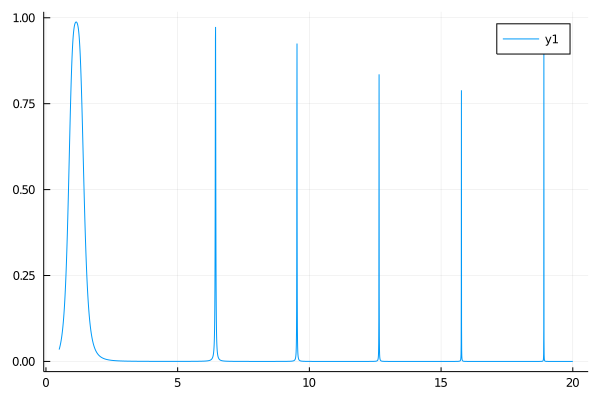

In [70]:
#Background scattering matrix...
plot(Freqs,abs.(ScatMats[1,1,:]).^2)
#plot!(Freqs,abs.(ScatMats2[1,1,:]).^2)

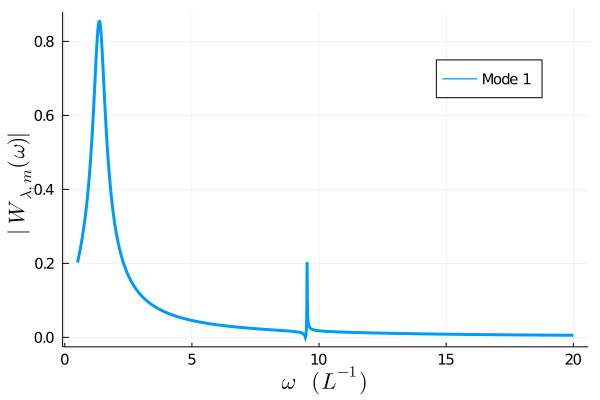

In [72]:
#Profiles of the system-bath couplings

plot(Freqs,abs.(HSB[2,1,:]),linewidth=3,xlabel=L"\omega\quad (L^{-1})",
    ylabel=L"| W_{\lambda,m}(\omega) |",xtickfont=10, ytickfont=10,guidefontsize=15,label="Mode 1",legendfontsize=10,legend=(0.8,0.8))
#plot!(Freqs,abs.(HSB[2,2,:]),linewidth=3,legendfontsize=10,label="Mode 2")
#plot!(Freqs,abs.(HSB2[2,1,:]),linewidth=3,label=L"n_{0}^{2}d=1")
#plot!(Freqs,abs.(HSB[1,1,:]))
#savefig("Couplings_1mode.pdf")

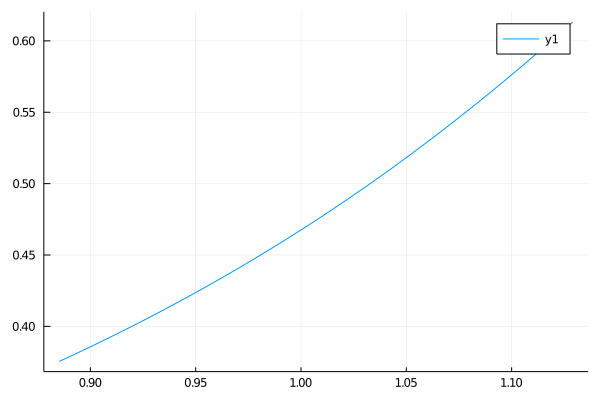

In [34]:
plot(Freqs[80:130],abs.(HSB[2,1,80:130]))

In [77]:
#Computing the I/O scattering matrix
SIO=zeros(ComplexF64,(2,2,Freq_pts))
#SIO2=zeros(ComplexF64,(2,2,Freq_pts))
#This scaling must be done for the correct calculation of the I/O scattering matrix under the rotating wave approximation
for i in 1:dim
    HSB[1,i,:]=sqrt(ModFreqs[i])*HSB[1,i,:]
    HSB[2,i,:]=sqrt(ModFreqs[i])*HSB[2,i,:]
   # HSB2[1,i,:]=sqrt(ModFreqs[i])*HSB2[1,i,:]
   # HSB2[2,i,:]=sqrt(ModFreqs[i])*HSB2[2,i,:]
end
 

for i in 1:Freq_pts
    
    SIO[:,:,i]=BuildSRot(dim,ModFreqs,HSB,Freqs,i)
   # SIO2[:,:,i]=BuildSRot(dim,ModFreqs,HSB2,Freqs,i)
    
end

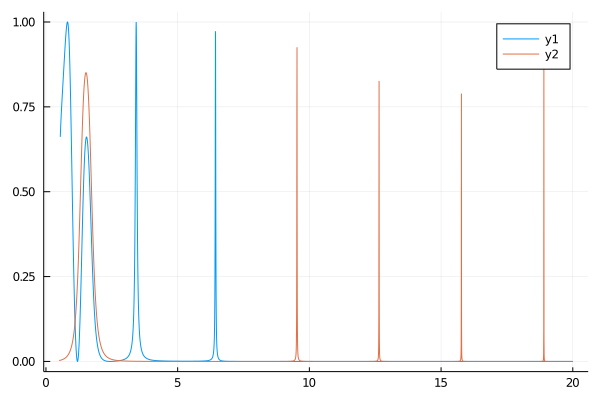

In [78]:
plot(Freqs[10:Freq_pts],abs.(SIO[1,2,10:Freq_pts]).^2)
plot!(Freqs,abs.(ScatMats[1,1,:]).^2)

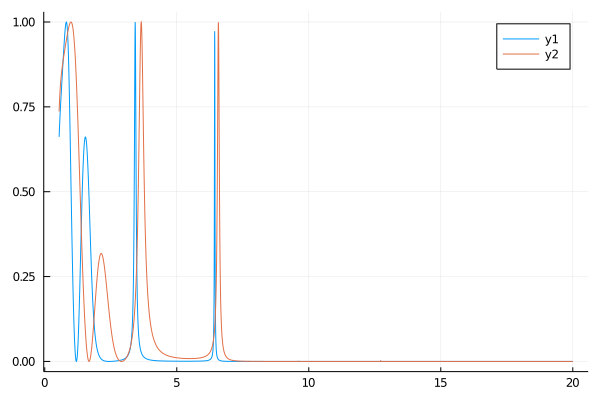

In [79]:
plot(Freqs[10:Freq_pts],abs.(SIO[1,2,10:Freq_pts]).^2)
plot!(Freqs[10:Freq_pts],abs.(SIO2[1,2,10:Freq_pts]).^2)

In [38]:
abs.(SIO[:,:,60])

2×2 Array{Float64,2}:
 0.100705  0.994916
 0.994916  0.100705

In [80]:
#Calculation of the total scattering matrix

STot=zeros(ComplexF64,(2,2,Freq_pts))
#STot2=zeros(ComplexF64,(2,2,Freq_pts))
for i in 1:Freq_pts
    #STot[:,:,i]=*(ScatMatTest[:,:,i],SIO[:,:,i])
    STot[:,:,i]=*(SIO[:,:,i],ScatMats[:,:,i])
    #STot2[:,:,i]=*(SIO2[:,:,i],ScatMats2[:,:,i])
    
end


In [82]:
#plot(Freqs[10:Freq_pts],abs.(SIO[1,2,10:Freq_pts]).^2,linewidth=3,xlabel=L"\omega\quad (L^{-1})",
#    xtickfont=10, ytickfont=10,guidefontsize=15,label=L"T_{io}",legendfontsize=10,legend=(0.7,0.95))
#plot!(Freqs,abs.(ScatMats[1,1,:]).^2,linewidth=3,label=L"T_{bg}")
plot(Freqs[10:Freq_pts],abs.(STot[1,1,10:Freq_pts]).^2,linewidth=2,label="Transmission")
savefig("Trans2modes.pdf")

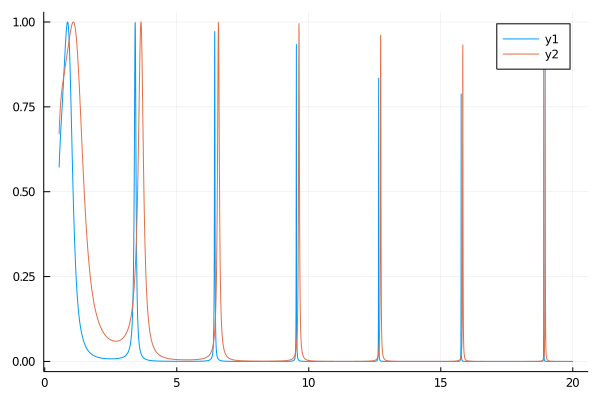

In [16]:
#Transmission spectra
plot(Freqs[10:Freq_pts],abs.(STot[1,1,10:Freq_pts]).^2)
plot!(Freqs[10:Freq_pts],abs.(STot2[1,1,10:Freq_pts]).^2)
#savefig("Numerical_Transmission.pdf")

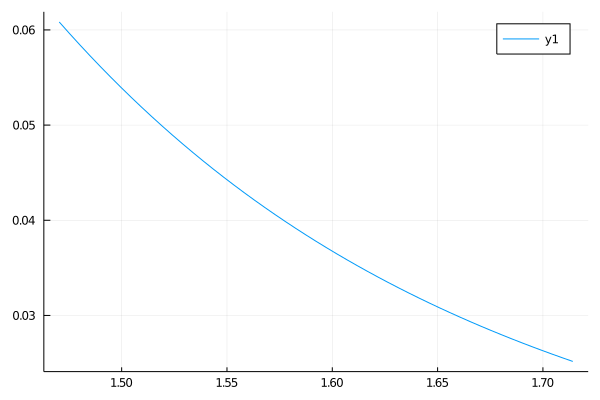

In [17]:
#Transmission spectra
plot(Freqs[200:250],abs.(STot[1,1,200:250]).^2)

In [15]:
Freqs[451]*0.192*2

2.4398985990660442

In [16]:
abs.(STot[1,1,451]).^2

0.020165218960688343

In [17]:
plotattr(:Series) 

Defined Series attributes are:
arrow, bar_edges, bar_position, bar_width, bins, colorbar_entry, connections, contour_labels, contours, extra_kwargs, fill_z, fillalpha, fillcolor, fillrange, group, hover, label, levels, line_z, linealpha, linecolor, linestyle, linewidth, marker_z, markeralpha, markercolor, markershape, markersize, markerstrokealpha, markerstrokecolor, markerstrokestyle, markerstrokewidth, match_dimensions, normalize, orientation, primary, quiver, ribbon, series_annotations, seriesalpha, seriescolor, seriestype, show_empty_bins, smooth, stride, subplot, weights, x, xerror, y, yerror, z, zerror


In [18]:
plotattr("legend")

legend {Bool (show the legend?) or (x,y) tuple or Symbol (legend position)}
key, leg

Bottom left corner of legend is placed at (x,y).  Symbol values: `:none`; `:best`; `:inline`; `:inside`; `:legend`; any valid combination of `:(outer ?)(top/bottom ?)(right/left ?)`, i.e.: `:top`, `:topright`, `:outerleft`, `:outerbottomright` ... (note: only some may be supported in each backend)
Subplot attribute,  default: best


In [19]:
plotattr(:Subplot)

Defined Subplot attributes are:
annotations, aspect_ratio, background_color_inside, background_color_legend, background_color_subplot, bottom_margin, camera, clims, color_palette, colorbar, colorbar_fontfamily, colorbar_title, colorbar_title_location, colorbar_titlefontcolor, colorbar_titlefontfamily, colorbar_titlefonthalign, colorbar_titlefontrotation, colorbar_titlefontsize, colorbar_titlefontvalign, extra_kwargs, fontfamily_subplot, foreground_color_legend, foreground_color_subplot, foreground_color_title, framestyle, left_margin, legend, legendfontcolor, legendfontfamily, legendfonthalign, legendfontrotation, legendfontsize, legendfontvalign, legendtitle, legendtitlefontcolor, legendtitlefontfamily, legendtitlefonthalign, legendtitlefontrotation, legendtitlefontsize, legendtitlefontvalign, margin, projection, right_margin, subplot_index, title, titlefontcolor, titlefontfamily, titlefonthalign, titlefontrotation, titlefontsize, titlefontvalign, titlelocation, top_margin


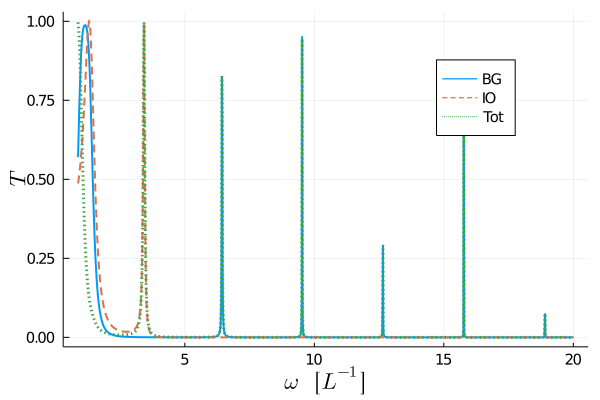

In [20]:
#Summary of results for this part....
plot(Freqs[30:1500],abs.(ScatMats[1,1,30:1500]).^2,linewidth=2,xlabel=L"\omega\quad [L^{-1}]",
    ylabel=L"T",xtickfont=10, ytickfont=10,guidefontsize=15,label="BG",legendfontsize=10,legend=(0.8,0.8))
plot!(Freqs[30:1500],abs.(SIO[1,2,30:1500]).^2,linestyle=:dash,linewidth=2,label="IO")
plot!(Freqs[30:1500],abs.(STot[1,1,30:1500]).^2,linestyle=:dot,linewidth=3,label="Tot")

#savefig("LowDiss.pdf")


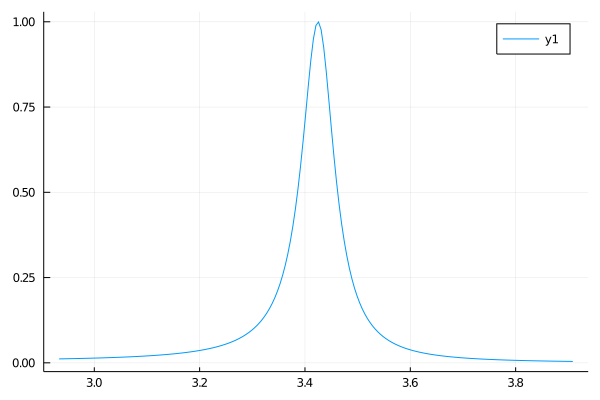

In [89]:
#Lets focus on the first well defined resonance
plot(Freqs[500:700],abs.(STot[1,1,500:700]).^2)

In [22]:
Freqs[200]

3.0887258172114738

In [23]:
Freqs[250]

3.739159439626418

In [24]:
Freqs[220]

3.348899266177452

In [25]:
abs(STot[1,1,226])

0.998252412081135

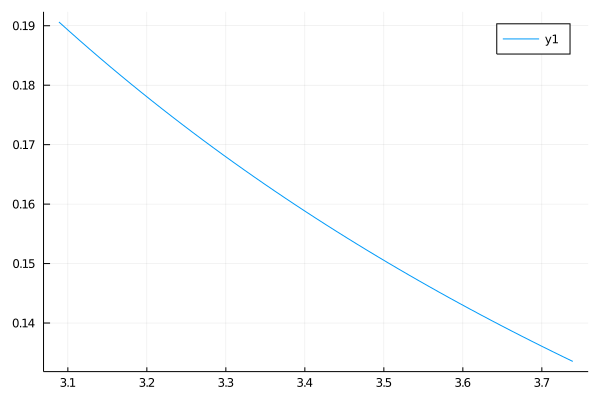

In [26]:
plot(Freqs[200:250],abs.(HSB[1,1,200:250]))

# Calculation of the parameters for the simulations

In [24]:
#For purposes of data manipulation, we define structures that store tthe paraneters to be used in the
#MCTDH calculations

mutable struct ParamNumSim
    RenormSysFreq::Float64
    FreqBathMod::Float64
    Damping::Float64
    AbsLeftCoup::Float64
    LeftCoup::ComplexF64
    RightCoup::ComplexF64
    TotT::Float64
    deltaT::Float64
    
end



In [25]:
#Looking at the input-output scattering matrix behaviour above, we note that the absence of well defined resonances
#and linewidths hints to nonmarkovian nature in the system-bath coupling. To deal with this,
#and for testing purposes lets consider a few frequency points and test our effective equation of motion approach 
#for each point.

#The chosen frequencies are 
#Freqs[150],Freqs[60],Freqs[80]

#freqIDs=[87,90,93,96,99,102,105,108,111,114,117,120] #The indexes of the frequencies of interest
#freqIDs=200:1:250
freqIDs=500:1:700
LFreqs=length(freqIDs)
freqsToProc=zeros(Float64,LFreqs)
for i in 1:LFreqs
    freqsToProc[i]=Freqs[freqIDs[i]]
end

PPvalues=zeros(ComplexF64,LFreqs)
DampValues=zeros(ComplexF64,LFreqs)

for i in 1:LFreqs

    PPvalues[i]=PPvalueRot(HSB,Freqs,freqIDs[i],1,1)
    DampValues[i]=pi*im*HSB[1,1,freqIDs[i]]*conj(HSB[1,1,freqIDs[i]]) +pi*im*HSB[2,1,freqIDs[i]]*conj(HSB[2,1,freqIDs[i]])

end
#REMINDER: Notice that the HSB coupling constants are scaled appropiately to use the RWA.


#For the calculation of the I/O scattering matrix consistent with the rotating wave approximation,
#we can define an effective Hamiltonian where the frequencies are scaled appropiately (see my notes)

#We introduce a useful conversion factor that converts the units we chose (\hbar=c=L=1) to eV. We confer to the length
#L=0.5 \mu m
CovToEv=0.197*2

#PPvalues in units of Ev

PPvaluesEV=CovToEv*PPvalues
#Damping values in En
DampValuesEV=CovToEv*DampValues


#we map the frequencies of interest to E(k), and do the conversion to eV. Notice that it is very important to
#keep in mind the mapping freqsToProc<->E_ks, even though they can be very distant from one another in numerical
#values.
E_ks=CovToEv*freqsToProc.^2/2

Elamb=CovToEv*ModFreqs[1]^2/2 #this is the mapping of the system mode frequency



##***HERE WE NEED TO BE CAREFUL, AS THESE ESTIMATIONS SEEM CRITICAL
#Prospective times at which we stop the simulation (in femtoseconds)

#CutOffTimes=0.658*log(2)./abs.(DampValuesEV)

#System-bath coupling constants at the frequencies of interest
EffHSBLeft=zeros(ComplexF64,LFreqs)
EffHSBRight=zeros(ComplexF64,LFreqs)

for i in 1:LFreqs
    EffHSBLeft[i]=HSB[1,1,freqIDs[i]]
    EffHSBRight[i]=HSB[2,1,freqIDs[i]]
    
    
    
end


#conversion to sqrt(eV), those are the units of this guy...
EffHSBLeft=sqrt(CovToEv)*EffHSBLeft
EffHSBRight=sqrt(CovToEv)*EffHSBRight;


#**************Construction of array of structures to store the parameters for each frequency
pts = LFreqs # I want the array to be of length
# create an uninitialized 1D array of size `x`
arrayOfStructs = Array{ParamNumSim, 1}(undef, pts); # or `Vector{Coords}(undef, x)`

# initialize the array elements using default constructor

#IMPORTANT: for convenience in the processing of results, lets consider the same deltaT and timecutoff in the
#simulations. We use the smallest coupling energy scale of the range of frequencies considered
#to define the simulation time cutoff:
#*************

AbsWL=abs(EffHSBLeft[LFreqs])
TimeCut=2*pi*0.658/(AbsWL*0.25)
    
FreqMax=100.0

deltaT=round(0.658*pi/FreqMax,digits=2)

    #Lets redefine the TimeCut variable to accomodate an integer number of time steps

N=round(TimeCut/deltaT)

    #The new TimeCut is given by

TimeCut=N*deltaT



#****************
for i = 1:pts
    #renormalize the frequency of the system mode
    r=real(Elamb-PPvaluesEV[i])
    
    damp=Float64(imag(DampValuesEV[i]))
    
           
    arrayOfStructs[i] = ParamNumSim(r, E_ks[i], damp,abs(EffHSBLeft[i]),EffHSBLeft[i],EffHSBRight[i],TimeCut,deltaT)
    # or you can use splatting if you already have values
    # arrayOfStructs[i] = Coords(rand(3)...)
end



In [26]:
arrayOfStructs[100]

ParamNumSim(2.3115118511077126, 2.298775761035157, 0.06137071101553805, 0.09883042051507786, -0.016203278096672886 - 0.09749310641326905im, 0.042013510196310576 + 0.08945567047522258im, 213.46, 0.02)

In [58]:
#RenormSysFreq::Float64
#    FreqBathMod::Float64
#    Damping::Float64
#    AbsLeftCoup::Float64
#    LeftCoup::ComplexF64
#    RightCoup::ComplexF64
#    TotT::Float64
#    deltaT::Float64
    

In [21]:
freqIDs[27]

226

In [22]:
Freqs[226]

1.5971492873218303

In [23]:
arrayOfStructs[27].Damping

2.8134822997852194

In [62]:
(pi*im*HSB[1,1,freqIDs[17]]*conj(HSB[1,1,freqIDs[17]]) +pi*im*HSB[2,1,freqIDs[17]]*conj(HSB[2,1,freqIDs[17]]))*CovToEv

6.83481049534862e-19 + 0.07008095293083075im

In [72]:
(pi*im*HSB[1,1,freqIDs[17]]*conj(HSB[1,1,freqIDs[17]]) +pi*im*HSB[2,1,freqIDs[17]]*conj(HSB[2,1,freqIDs[17]]))*CovToEv

0.0 + 0.2283340901659846im

# Processing of simulation results

In [92]:
#I only consider the results at 2.902 eV, to see to what extent we can reproduce the I/O scattering matrix
AmpDum=readdlm("./MCTDH_bare_cav/BareCavSmallDiss/Cavity_Resonant/expectationJul"); 

Timepts,columns=size(AmpDum)

#Due to limitations in the MCTDH code, I need to formulate the problem in atomic units. To 
#define the dimensionless annhilitation operator a, we scale the time-dependent coordinate and 
#position derivatives and sum them appropietly:

#conversion of eV to atomic units...
#wcAt=wc*ConvEvToFreq
#dampAt=0.00736/2
#dampAt=0.0


#For purposes of simplicity in data handling, we define the next array:
MicAmp=zeros(ComplexF64,(Timepts,3))
#MicAmpC=zeros(ComplexF64,(Timepts,3))
BathAmp=zeros(ComplexF64,(Timepts,3))

#PhotExc=zeros(ComplexF64,(Timepts,3))


for i in 1:Timepts
    scale=AmpDum[i,2] #norm of the wavefunction. We need to scale each of expectation values computed by MCTDH
    #scale=1.0 #For the simulation of this driven oscillator, we need this scaling factor equal 
    #because the program computes the expectation value over the norm of the wavefunction
    
    MicAmp[i,1]=AmpDum[i,1] #Time coordinate
    MicAmp[i,2]=AmpDum[i,3]*scale #real part of coordinate
    MicAmp[i,2]+=im*AmpDum[i,4]*scale
    
       
    BathAmp[i,1]=AmpDum[i,1] #Time coordinate
    BathAmp[i,2]=AmpDum[i,5]*scale #real part of coordinate
    BathAmp[i,2]+=im*AmpDum[i,6]*scale
   
   # PhotExc[i,1]=AmpDum[i,1]
    #PhotExc[i,2]=AmpDum[i,7]*scale
    #PhotExc[i,2]+=im*AmpDum[i,8]*scale
    
end




deltaT=abs(MicAmp[1,1]-MicAmp[2,1]);
Ttime=abs(MicAmp[1,1]-MicAmp[Timepts,1]) #This is the total time of the simulation, in fs!!



125.32

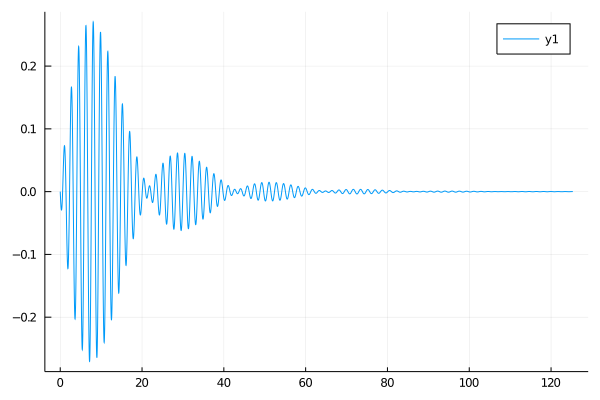

In [93]:
plot(real(MicAmp[:,1]),imag(MicAmp[:,2]))

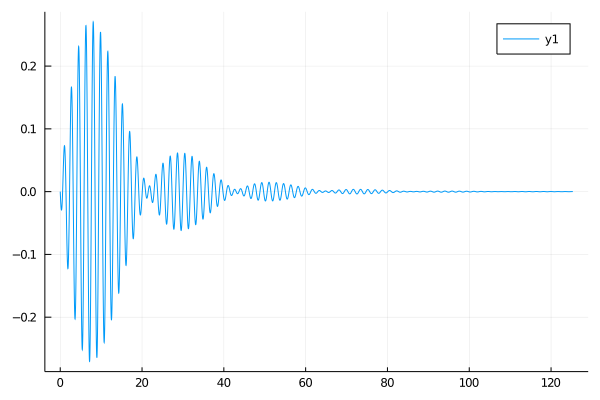

In [94]:
plot(real(MicAmp[:,1]),imag(MicAmp[:,2]))

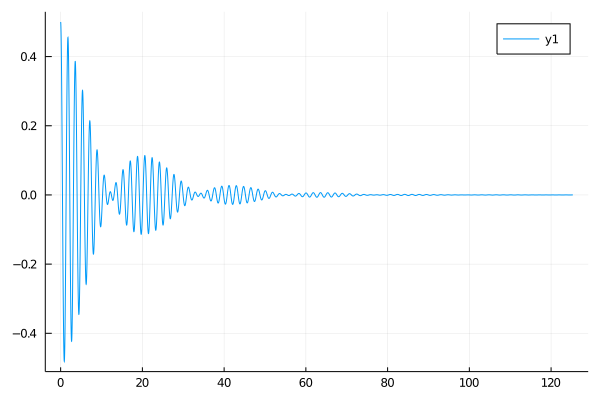

In [95]:
plot(real(MicAmp[:,1]),real(BathAmp[:,2]))

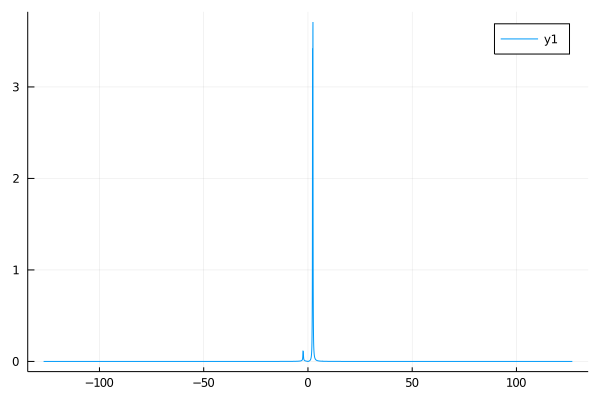

In [96]:
FouMic=ifft(MicAmp[:,2])*length(MicAmp[:,2])*deltaT

FreqsFFT=0.658*fftfreq(length(MicAmp[:,2]))*2*pi/deltaT ;#Here we take advantage of the equal size along all dimensions
  
FreqsFFT=fftshift(FreqsFFT)
FouMic=fftshift(FouMic);
plot(FreqsFFT,abs.(FouMic))


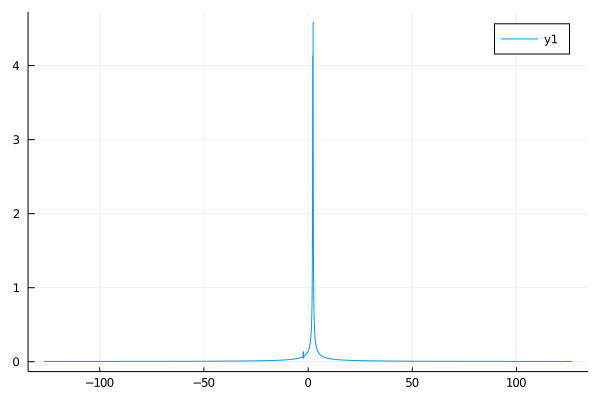

In [97]:
FouBath=ifft(BathAmp[:,2])*length(MicAmp[:,2])*deltaT
FreqsFFT=0.658*fftfreq(length(MicAmp[:,2]))*2*pi/deltaT ;#Here we take advantage of the equal size along all dimensions
  
FreqsFFT=fftshift(FreqsFFT)
FouBath=fftshift(FouBath);
plot(FreqsFFT,abs.(FouBath))



In [98]:
#we use extrapolations to estimate the spectrum at frequencies where we know the exact system-bath couplings,
#which are used to calculate the I/O scattering matrix

spRMic=Spline1D(real(FreqsFFT), real(FouMic); w=ones(length(FreqsFFT)), k=3, bc="nearest", s=0.0);
spImMic=Spline1D(real(FreqsFFT),imag(FouMic); w=ones(length(FreqsFFT)), k=3, bc="nearest", s=0.0);
spRBath=Spline1D(real(FreqsFFT), real(FouBath); w=ones(length(FreqsFFT)), k=3, bc="nearest", s=0.0);
spImBath=Spline1D(real(FreqsFFT), imag(FouBath); w=ones(length(FreqsFFT)), k=3, bc="nearest", s=0.0);


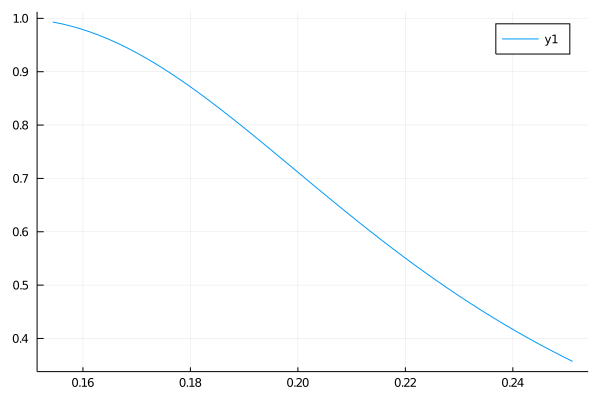

In [99]:
#Lets focus on the first well defined resonance
plot(Freqs[80:130].^2 *CovToEv/2,abs.(STot[1,1,80:130]).^2)

In [37]:
FRangeIdx=80:1:130

80:1:130

In [38]:
length(FRangeIdx)

51

In [125]:
#lets consider a range of frequencies for which we know the system-bath coupling constants
FRangeIdx=freqIDs
Rangepts=length(FRangeIdx)
FRangeIO=zeros(Float64,Rangepts)
for i in 1:Rangepts
    FRangeIO[i]=Freqs[FRangeIdx[i]].^2 *CovToEv/2 #Freqs in eVs!!!
end


#calculation "by hand" of the IO scattering matrix for each frequency
SIO_Num=zeros(ComplexF64,(2,2,Rangepts))

#debugging...
ReflectP=zeros(ComplexF64,Rangepts)
TransP=zeros(ComplexF64,Rangepts)
ImagRef=zeros(ComplexF64,Rangepts)


for i in 1:Rangepts
   #retrieve the system-bath coupling for each frequency, as well as the relative phase between the degenerate modes
    #conversion to sqrt(eV), those are the units of this guy...
    CoupLeft=sqrt(CovToEv)*HSB[1,1,FRangeIdx[i]] #left
    CoupRight=sqrt(CovToEv)*HSB[2,1,FRangeIdx[i]]; #right

    PsiLeft=angle(CoupLeft)
    PsiRight=angle(CoupRight)
    
    ELR=exp(-im*(PsiLeft-PsiRight)) #difference in phases of couplings
    AuxRatio=abs(CoupRight)/abs(CoupLeft)
    #ratio of bath and microcavity amplitudes...We assume that the bath that drives the system is always from the left
    #such that the we can scale that result appropiately to get the corresponding result for the right bath
    Ratio=(evaluate(spRMic,FRangeIO[i])+im*evaluate(spImMic,FRangeIO[i]))/(evaluate(spRBath,FRangeIO[i])+im*evaluate(spImBath,FRangeIO[i]))
    
    SIO_Num[1,1,i]=1-2*pi*im*abs(CoupLeft)*Ratio
    SIO_Num[1,2,i]=-2*pi*im*abs(CoupLeft)*AuxRatio*ELR*Ratio
    SIO_Num[2,1,i]=-2*pi*im*abs(CoupRight)*conj(ELR)*Ratio
    SIO_Num[2,2,i]=1-2*pi*im*abs(CoupRight)*AuxRatio*Ratio
    
    ReflectP[i]=-2*pi*im*abs(CoupLeft)*Ratio
    TransP[i]=-2*pi*im*abs(CoupLeft)*AuxRatio*ELR*Ratio
    ImagRef[i]=imag(2*pi*im*abs(CoupLeft)*Ratio)
    
    
    
end




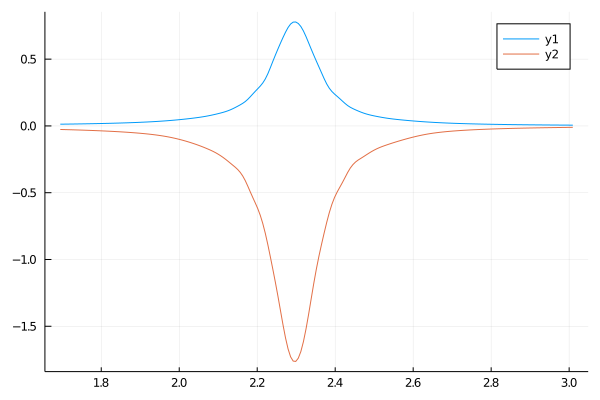

In [136]:
#plot(FRangeIO,abs.(ReflectP).^2+2*real(ReflectP))
plot(FRangeIO,abs.(ReflectP).^2)
plot!(FRangeIO,2*real(ReflectP))
#plot!(FRangeIO,abs.(TransP).^2)
#plot!(FRangeIO,real(ImagRef))


In [101]:
FRangeIdx[length(FRangeIdx)]

700

In [145]:
plot(FRangeIO,abs.(SIO[1,1,FRangeIdx[1]:FRangeIdx[length(FRangeIdx)]]).^2,linewidth=3,xlabel=L"\omega\quad (eV)",
    xtickfont=10, ytickfont=10,guidefontsize=15,label="Exact",legendfontsize=10,legend=(0.8,0.85))
plot!(FRangeIO,abs.(SIO_Num[1,1,:]).^2,linewidth=3,label="Effective")
savefig("Reflection.pdf")

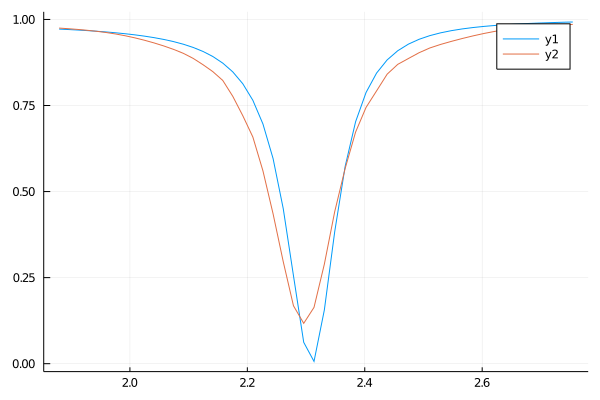

In [64]:
plot(FRangeIO,real(SIO[1,1,FRangeIdx[1]:FRangeIdx[length(FRangeIdx)]]))
plot!(FRangeIO,real(SIO_Num[1,1,:]))

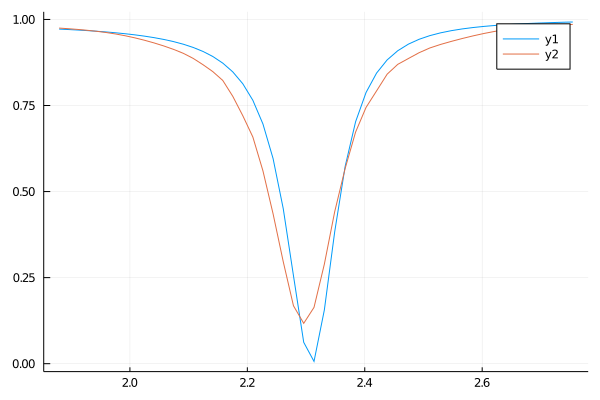

In [65]:
plot(FRangeIO,real(SIO[1,1,FRangeIdx[1]:FRangeIdx[length(FRangeIdx)]]))
plot!(FRangeIO,real(SIO_Num[1,1,:]))

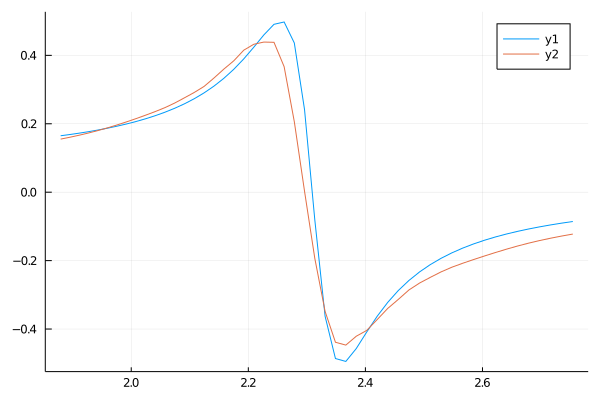

In [66]:
plot(FRangeIO,imag(SIO[1,1,FRangeIdx[1]:FRangeIdx[length(FRangeIdx)]]))
plot!(FRangeIO,imag(SIO_Num[1,1,:]))

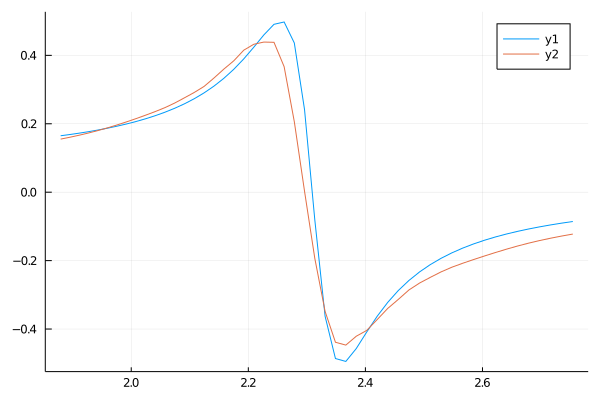

In [67]:
plot(FRangeIO,imag(SIO[1,1,FRangeIdx[1]:FRangeIdx[length(FRangeIdx)]]))
plot!(FRangeIO,imag(SIO_Num[1,1,:]))

In [280]:
31.33*4

125.32

In [144]:
plot(FRangeIO,abs.(SIO[1,2,FRangeIdx[1]:FRangeIdx[length(FRangeIdx)]]).^2,linewidth=3,xlabel=L"\omega\quad (eV)",
    xtickfont=10, ytickfont=10,guidefontsize=15,label="Exact",legendfontsize=10,legend=(0.8,0.85))
plot!(FRangeIO,abs.(SIO_Num[1,2,:]).^2,linewidth=3,label="Effective")
savefig("Transmission.pdf")

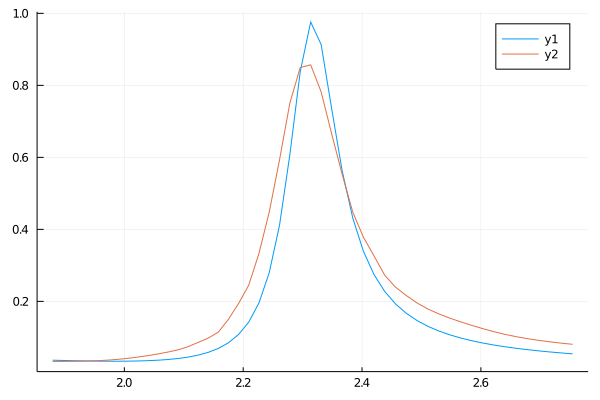

In [47]:
plot(FRangeIO,real(SIO[1,2,FRangeIdx[1]:FRangeIdx[length(FRangeIdx)]]))
plot!(FRangeIO,real(SIO_Num[1,2,:]))

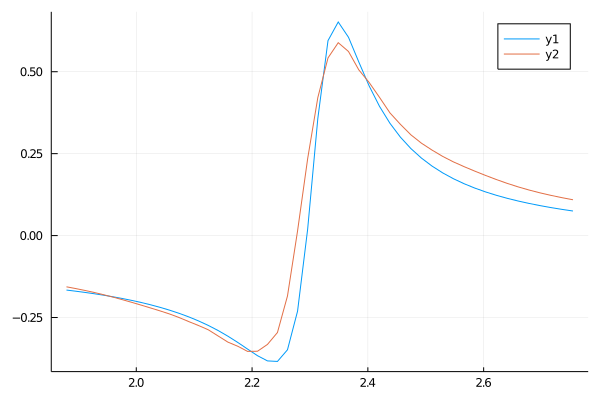

In [48]:
plot(FRangeIO,imag(SIO[2,1,FRangeIdx[1]:FRangeIdx[length(FRangeIdx)]]))
plot!(FRangeIO,imag(SIO_Num[2,1,:]))

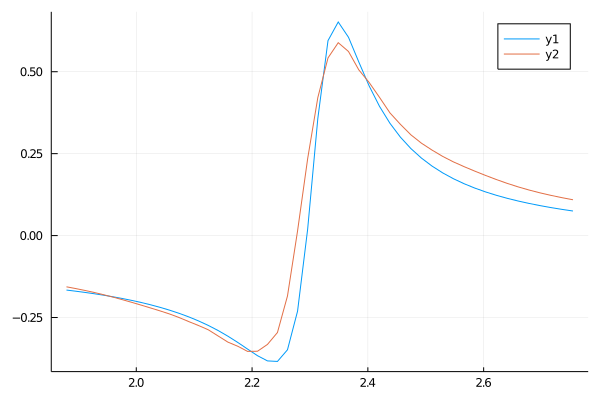

In [49]:
plot(FRangeIO,imag(SIO[2,1,FRangeIdx[1]:FRangeIdx[length(FRangeIdx)]]))
plot!(FRangeIO,imag(SIO_Num[2,1,:]))

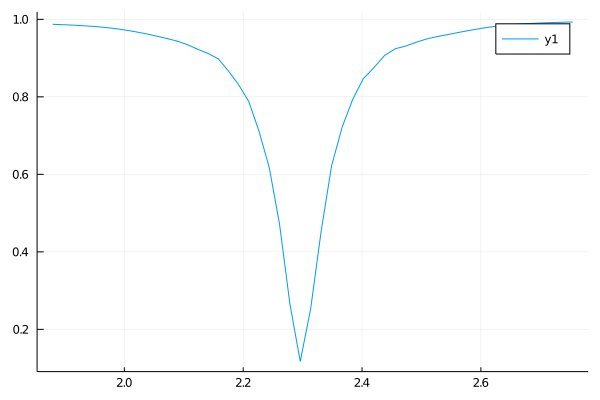

In [50]:
#TODO: Analysis of data...

plot(FRangeIO,abs.(SIO_Num[1,1,:]))

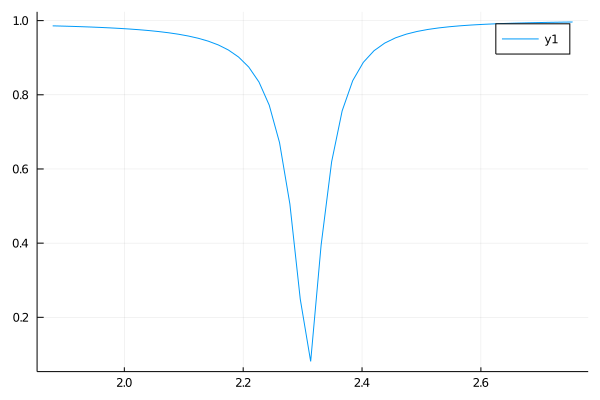

In [51]:
plot(FRangeIO,abs.(SIO[1,1,FRangeIdx[1]:FRangeIdx[length(FRangeIdx)]]))

In [35]:
#How does the Total (product of background and I/O scattering matrix) look like?
STot_Num=zeros(ComplexF64,(2,2,Rangepts))

for i in 1:Rangepts
    
    STot_Num[:,:,i]=*(ScatMats[:,:,FRangeIdx[i]],SIO_Num[:,:,i])
    
end


In [36]:
125.32/2


62.66

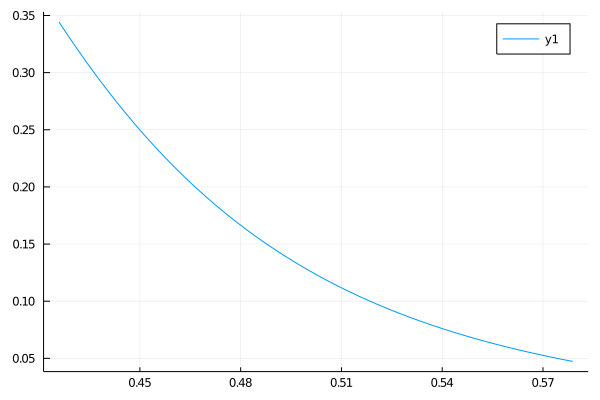

In [37]:
plot(FRangeIO,abs.(STot_Num[1,1,:]).^2)

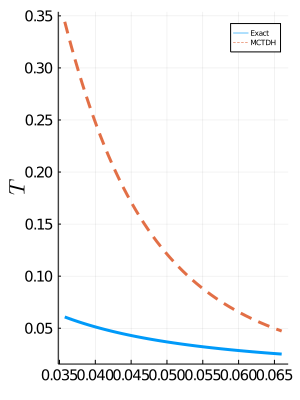

In [38]:
p1=plot(0.5*CovToEv*FRangeIO.^2,abs.(STot[1,1,FRangeIdx[1]:FRangeIdx[length(FRangeIdx)]]).^2,
linewidth=3,size = (300, 400), #xlims=(0.75,1.45),
ylabel=L"T",xtickfont=10, ytickfont=10,guidefontsize=15,label="Exact",legendfontsize=5)
plot!(0.5*CovToEv*FRangeIO.^2,abs.(STot_Num[1,1,:]).^2,linewidth=3,label="MCTDH",linestyle=:dash)
annotate!(0.75,1.06,"a)")
#savefig("ComparisonBare.pdf")

#plot(Freqs[30:1500],abs.(ScatMats[1,1,30:1500]).^2,linewidth=2,xlabel=L"\omega\quad [L^{-1}]",
#    ylabel=L"T",xtickfont=10, ytickfont=10,guidefontsize=15,label="BG",legendfontsize=10,legend=(0.8,0.8))
#plot!(Freqs[30:1500],abs.(SIO[1,2,30:1500]).^2,linestyle=:dash,linewidth=2,label="IO")
#plot!(Freqs[30:1500],abs.(STot[1,1,30:1500]).^2,linestyle=:dot,linewidth=3,label="Tot")


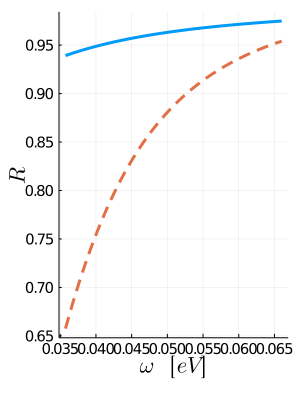

In [39]:
p2=plot(0.5*CovToEv*FRangeIO.^2,abs.(STot[1,2,FRangeIdx[1]:FRangeIdx[length(FRangeIdx)]]).^2,
linewidth=3,xlabel=L"\omega\quad [eV]", size = (300, 400), #xlims=(0.75,1.45),
ylabel=L"R",xtickfont=10, ytickfont=10,guidefontsize=15,label="Exact",legendfontsize=10)
plot!(0.5*CovToEv*FRangeIO.^2,abs.(STot_Num[1,2,:]).^2,linewidth=3,label="MCTDH",linestyle=:dash,legend=:false)
annotate!(0.75,1.06,"b)")

In [364]:
plot(p1,p2,layout=(2,1))
savefig("ComparisonBare.pdf")

In [299]:
plotattr(:Series)

Defined Series attributes are:
arrow, bar_edges, bar_position, bar_width, bins, colorbar_entry, connections, contour_labels, contours, extra_kwargs, fill_z, fillalpha, fillcolor, fillrange, group, hover, label, levels, line_z, linealpha, linecolor, linestyle, linewidth, marker_z, markeralpha, markercolor, markershape, markersize, markerstrokealpha, markerstrokecolor, markerstrokestyle, markerstrokewidth, match_dimensions, normalize, orientation, primary, quiver, ribbon, series_annotations, seriesalpha, seriescolor, seriestype, show_empty_bins, smooth, stride, subplot, weights, x, xerror, y, yerror, z, zerror


In [306]:
plotattr("lims")

lims {NTuple{2,Number} or Symbol}

Force axis limits.  Only finite values are used (you can set only the right limit with `xlims = (-Inf, 2)` for example). `:round` widens the limit to the nearest round number ie. [0.1,3.6]=>[0.0,4.0]
Axis attribute,  default: auto


In [227]:
atan(0.1/2)

0.049958395721942765

In [229]:
(0.1/sin(0.049958395721942765))^4

16.0801

In [230]:
0.0801^0.25

0.5319957085933101

In [233]:
(2^2-im*0.5319957085933101^2)^0.5

2.00124960961895 - 0.07071067811865477im

In [236]:
0.5319957085933101^2/(2*2)

0.07075485849042454

In [235]:
2*0.1*2

0.4

In [237]:
#wc=2.309
#gamma=0.0606

phi_2=atan(0.0606/2.309);
dum=0.0606/sin(phi_2)

Omega=(dum^4-2.309^4)^0.25




0.4448802889468713

In [239]:
0.4448802889468713^2/(2*2.309)

0.04285804926233255

# Incorporation of the molecular degrees of freedom

# 1 Molecule : Intermediate coupling case

# 1 Molecule, intermediate coupling: linear absorption

In [988]:
#I only consider the results at 2.902 eV, to see to what extent we can reproduce the I/O scattering matrix
#AmpDum=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/Cavity_Resonant/expectationJul"); 

AmpDum=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/Multipacket/EgV0P0/Cavity_Resonant/expectationJul")


Timepts,columns=size(AmpDum)

#Due to limitations in the MCTDH code, I need to formulate the problem in atomic units. To 
#define the dimensionless annhilitation operator a, we scale the time-dependent coordinate and 
#position derivatives and sum them appropietly:

#conversion of eV to atomic units...
#wcAt=wc*ConvEvToFreq
#dampAt=0.00736/2
#dampAt=0.0


#For purposes of simplicity in data handling, we define the next array:
MicAmpMol=zeros(ComplexF64,(Timepts,2))
#MicAmpC=zeros(ComplexF64,(Timepts,3))
BathAmpMol=zeros(ComplexF64,(Timepts,2))

#ExcExp=zeros(ComplexF64,(Timepts,2))



for i in 1:Timepts
    scale=AmpDum[i,2] #norm of the wavefunction. We need to scale each of expectation values computed by MCTDH
    #scale=1.0 #For the simulation of this driven oscillator, we need this scaling factor equal 
    #because the program computes the expectation value over the norm of the wavefunction
    
    MicAmpMol[i,1]=AmpDum[i,1] #Time coordinate
    MicAmpMol[i,2]=AmpDum[i,3]*scale #real part of coordinate
    MicAmpMol[i,2]+=im*AmpDum[i,4]*scale
    
       
    BathAmpMol[i,1]=AmpDum[i,1] #Time coordinate
    BathAmpMol[i,2]=AmpDum[i,5]*scale #real part of coordinate
    BathAmpMol[i,2]+=im*AmpDum[i,6]*scale
    
    #ExcExp[i,1]=AmpDum[i,1]
    #ExcExp[i,2]=AmpDum[i,7]*scale
    #ExcExp[i,2]+=im*AmpDum[i,8]*scale
   
    #MicAmpC[i,1]=AmpDum[i,1]
    #MicAmpC[i,2]=AmpDum[i,7]*scale
    #MicAmpC[i,2]+=im*AmpDum[i,8]*scale
    
end




deltaT=abs(MicAmpMol[1,1]-MicAmpMol[2,1]);
Ttime=abs(MicAmpMol[1,1]-MicAmpMol[Timepts,1]) #This is the total time of the simulation, in fs!!




125.32

In [989]:
Timepts/2


3856.5

In [737]:
4.5-2.4115

2.0885

In [738]:
Timepts/2

3856.5

In [739]:
62.66/4

15.665

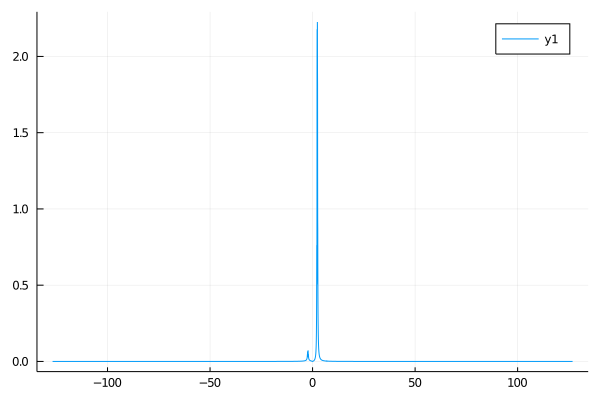

In [990]:
FouMicMol=ifft(MicAmpMol[:,2])*length(MicAmpMol[:,2])*deltaT

FreqsFFTMol=0.658*fftfreq(length(MicAmpMol[:,2]))*2*pi/deltaT ;#Here we take advantage of the equal size along all dimensions
  
FreqsFFTMol=fftshift(FreqsFFTMol)
FouMicMol=fftshift(FouMicMol);
plot(FreqsFFTMol,abs.(FouMicMol))

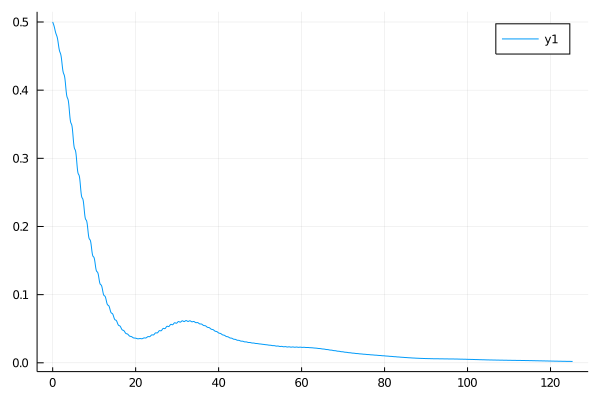

In [991]:
plot(real(BathAmpMol[:,1]),abs.(BathAmpMol[:,2]))

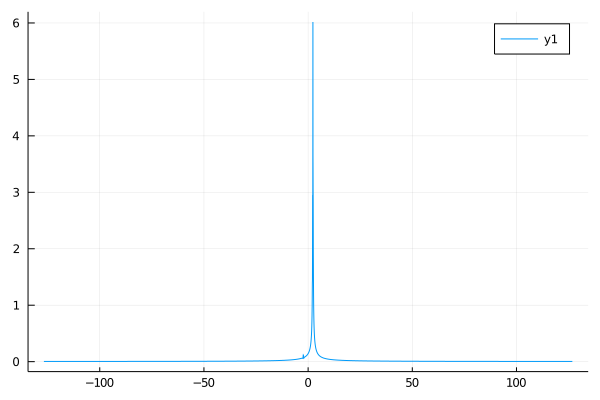

In [992]:
FouBathMol=ifft(BathAmpMol[:,2])*length(MicAmpMol[:,2])*deltaT
FreqsFFTMol=0.658*fftfreq(length(MicAmpMol[:,2]))*2*pi/deltaT ;#Here we take advantage of the equal size along all dimensions
  
FreqsFFTMol=fftshift(FreqsFFTMol)
FouBathMol=fftshift(FouBathMol);
plot(FreqsFFTMol,abs.(FouBathMol))


In [993]:
spRMicMol=Spline1D(real(FreqsFFTMol), real(FouMicMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);
spImMicMol=Spline1D(real(FreqsFFTMol),imag(FouMicMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);
spRBathMol=Spline1D(real(FreqsFFTMol), real(FouBathMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);
spImBathMol=Spline1D(real(FreqsFFTMol), imag(FouBathMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);


In [994]:
#lets consider a range of frequencies for which we know the system-bath coupling constants
FRangeIdx=500:1:700 #WARNING: this is the range of indexes of the frequencies of interest. This must be selected
#such that they cover the frequency of the bath used in our effective model...

Rangepts=length(FRangeIdx)
FRangeIO=zeros(Float64,Rangepts)
for i in 1:Rangepts
    FRangeIO[i]=Freqs[FRangeIdx[i]].^2 *CovToEv/2 #Freqs in eVs!!!
end



#FRangeIO=Freqs[500:700].^2 *CovToEv/2 #Freqs in eVs!!! These parameters are already defined in the molecular-free
#section

#calculation "by hand" of the IO scattering matrix for each frequency
SIO_NumMol=zeros(ComplexF64,(2,2,Rangepts))

for i in 1:Rangepts
   #retrieve the system-bath coupling for each frequency, as well as the relative phase between the degenerate modes
    #conversion to sqrt(eV), those are the units of this guy...
    CoupLeft=sqrt(CovToEv)*HSB[1,1,FRangeIdx[i]] #left
    CoupRight=sqrt(CovToEv)*HSB[2,1,FRangeIdx[i]]; #right

    PsiLeft=angle(CoupLeft)
    PsiRight=angle(CoupRight)
    
    ELR=exp(-im*(PsiLeft-PsiRight)) #difference in phases of couplings
    AuxRatio=abs(CoupRight)/abs(CoupLeft)
    #ratio of bath and microcavity amplitudes...We assume that the bath that drives the system is always from the left
    #such that the we can scale that result appropiately to get the corresponding result for the right bath
    Ratio=(evaluate(spRMicMol,FRangeIO[i])+im*evaluate(spImMicMol,FRangeIO[i]))/(evaluate(spRBathMol,FRangeIO[i])+im*evaluate(spImBathMol,FRangeIO[i]))
    
    SIO_NumMol[1,1,i]=1-2*pi*im*abs(CoupLeft)*Ratio
    SIO_NumMol[1,2,i]=-2*pi*im*abs(CoupLeft)*AuxRatio*ELR*Ratio
    SIO_NumMol[2,1,i]=-2*pi*im*abs(CoupRight)*conj(ELR)*Ratio
    SIO_NumMol[2,2,i]=1-2*pi*im*abs(CoupRight)*AuxRatio*Ratio
    
    
    
end




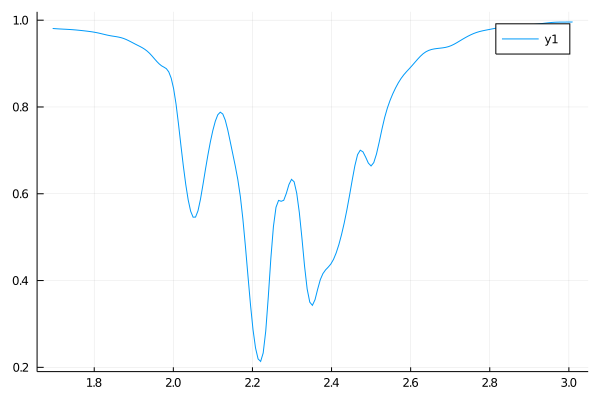

In [995]:
plot(FRangeIO,abs.(SIO_NumMol[1,1,:]).^2)

In [996]:
#How does the Total (product of background and I/O scattering matrix) look like?
STot_NumMol=zeros(ComplexF64,(2,2,Rangepts))

for i in 1:Rangepts
    
    STot_NumMol[:,:,i]=*(ScatMats[:,:,FRangeIdx[i]],SIO_NumMol[:,:,i])
    
end


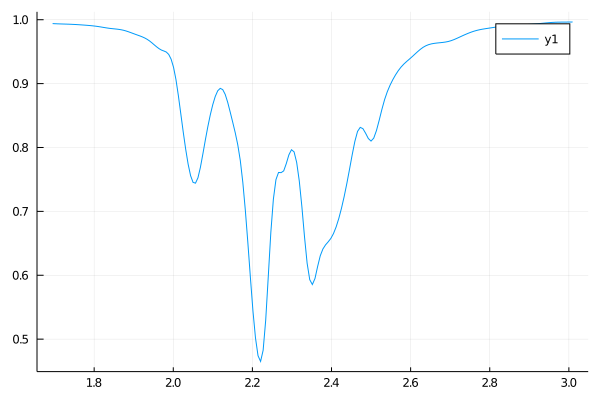

In [997]:
plot(FRangeIO,abs.(STot_NumMol[1,2,:]))

In [998]:
#Calculation of the molecular absorption
#Load the data associated to the different wavepackets...
EeV0P0_Exc=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/Multipacket/CrossMaster/EeV0P0Cross_Exc")
EeV0P0_Phot=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/Multipacket/CrossMaster/EeV0P0Cross_Phot")

EeV1P0_Exc=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/Multipacket/CrossMaster/EeV1P0Cross_Exc")
EeV1P0_Phot=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/Multipacket/CrossMaster/EeV1P0Cross_Phot")

EgV0P1_Exc=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/Multipacket/CrossMaster/EgV0P1Cross_Exc")
EgV0P1_Phot=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/Multipacket/CrossMaster/EgV0P1Cross_Phot");

EeV2P0_Exc=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/Multipacket/CrossMaster/EeV2P0Cross_Exc")
EeV2P0_Phot=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/Multipacket/CrossMaster/EeV2P0Cross_Phot")

#I think this contribution is essential for the linear response...
EgV0P0_Exc=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/Multipacket/CrossMaster/EgV0P0Cross_Exc")
EgV0P0_Phot=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/Multipacket/CrossMaster/EgV0P0Cross_Phot");



#Alternative 'auxiliary states'

#EeV0P0_Exc=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/MultiPacket2/CrossMaster/EeV0P0Cross_Exc")
#EeV0P0_Phot=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/MultiPacket2/CrossMaster/EeV0P0Cross_Phot")

#EeV1P0_Exc=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/MultiPacket2/CrossMaster/EeV1P0Cross_Exc")
#EeV1P0_Phot=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/MultiPacket2/CrossMaster/EeV1P0Cross_Phot")

#EgV0P1_Exc=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/MultiPacket2/CrossMaster/EgV0P1Cross_Exc")
#EgV0P1_Phot=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/MultiPacket2/CrossMaster/EgV0P1Cross_Phot");




Timepts,=size(EeV0P0_Exc)

(7713, 5)

In [999]:
Timepts

7713

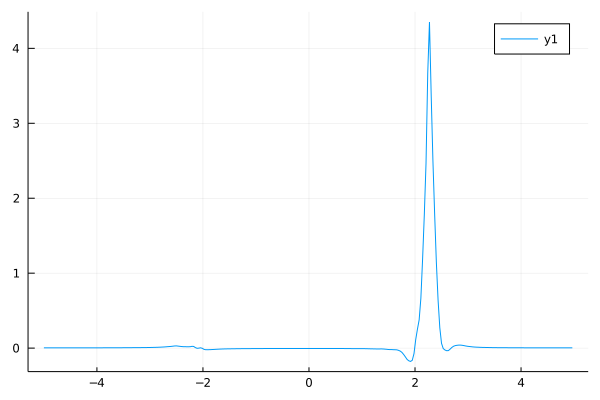

In [1000]:
init=1
#endT=Timepts-3000
endT=Timepts

WRange=10. #Frequency range goes from -WRange/2 to WRange/2, in eV

SampTime=2*pi*0.658/WRange #sampling rate in fs

SampRate=Int64(div(2*pi*0.658/WRange,deltaT,RoundDown))

#total number of points:
TotPts=endT-init+1

#number of points to sample:
SampPts=Int64(div(TotPts,SampRate,RoundDown))

Filtered1=zeros(ComplexF64,SampPts)
Filtered2=zeros(ComplexF64,SampPts)
Filtered3=zeros(ComplexF64,SampPts)
Filtered4=zeros(ComplexF64,SampPts)
Filtered5=zeros(ComplexF64,SampPts)
Filtered6=zeros(ComplexF64,SampPts)
Filtered7=zeros(ComplexF64,SampPts)
Filtered8=zeros(ComplexF64,SampPts)
Filtered9=zeros(ComplexF64,SampPts)
Filtered10=zeros(ComplexF64,SampPts)





for i in 1:SampPts
    Filtered1[i]=conj(EgV0P1_Phot[init+i*SampRate-1,2]+im*EgV0P1_Phot[init+i*SampRate-1,3])
    Filtered2[i]=EgV0P1_Exc[init+i*SampRate-1,2]+im*EgV0P1_Exc[init+i*SampRate-1,3]

    #excited electronic, zero phonon, zero photon
    Filtered3[i]=conj(EeV1P0_Phot[init+i*SampRate-1,2]+im*EeV1P0_Phot[init+i*SampRate-1,3])
    Filtered4[i]=EeV1P0_Exc[init+i*SampRate-1,2]+im*EeV1P0_Exc[init+i*SampRate-1,3]

    #excited electronic, one phonon, zero photon
    Filtered5[i]=conj(EeV0P0_Phot[init+i*SampRate-1,2]+im*EeV0P0_Phot[init+i*SampRate-1,3])
    Filtered6[i]=EeV0P0_Exc[init+i*SampRate-1,2]+im*EeV0P0_Exc[init+i*SampRate-1,3]
    
    Filtered7[i]=conj(EeV2P0_Phot[init+i*SampRate-1,2]+im*EeV2P0_Phot[init+i*SampRate-1,3])
    Filtered8[i]=EeV2P0_Exc[init+i*SampRate-1,2]+im*EeV2P0_Exc[init+i*SampRate-1,3]
    
    Filtered9[i]=conj(EgV0P0_Phot[init+i*SampRate-1,2]+im*EgV0P0_Phot[init+i*SampRate-1,3])
    Filtered10[i]=EgV0P0_Exc[init+i*SampRate-1,2]+im*EgV0P0_Exc[init+i*SampRate-1,3]

    #One excitation in the photon field: ground electronic, zero phonon, 1 photon
    #Filtered7[i]=conj(Exc0Vib1PhotCross_Phot[init+i*SampRate-1,2]+im*Exc0Vib1PhotCross_Phot[init+i*SampRate-1,3])
    #Filtered8[i]=Exc0Vib1PhotCross_Exc[init:endT,2]+im*Exc0Vib1PhotCross_Exc[init:endT,3]
 
    
end


#Filtered1=conj(EgV0P1_Phot[init:endT,2]+im*EgV0P1_Phot[init:endT,3])
#Filtered2=EgV0P1_Exc[init:endT,2]+im*EgV0P1_Exc[init:endT,3]

#Filtered3=conj(EeV1P0_Phot[init:endT,2]+im*EeV1P0_Phot[init:endT,3])
#Filtered4=EeV1P0_Exc[init:endT,2]+im*EeV1P0_Exc[init:endT,3]

#Filtered5=conj(EeV0P0_Phot[init:endT,2]+im*EeV0P0_Phot[init:endT,3])
#Filtered6=EeV0P0_Exc[init:endT,2]+im*EeV0P0_Exc[init:endT,3]

#One excitation in the photon field...
#Filtered7=conj(Exc0Vib1PhotCross_Phot[init:endT,2]+im*Exc0Vib1PhotCross_Phot[init:endT,3])
#Filtered8=Exc0Vib1PhotCross_Exc[init:endT,2]+im*Exc0Vib1PhotCross_Exc[init:endT,3]

#Application of filter
for i in 1:length(Filtered1)
    Filtered1[i]=Filtered1[i]*cos(pi*i/(2*length(Filtered1[:,1])))
    Filtered2[i]=Filtered2[i]*cos(pi*i/(2*length(Filtered2[:,1])))
    
    Filtered3[i]=Filtered3[i]*cos(pi*i/(2*length(Filtered3[:,1])))
    Filtered4[i]=Filtered4[i]*cos(pi*i/(2*length(Filtered4[:,1])))
    
    Filtered5[i]=Filtered5[i]*cos(pi*i/(2*length(Filtered5[:,1])))
    Filtered6[i]=Filtered6[i]*cos(pi*i/(2*length(Filtered6[:,1])))
    
    Filtered7[i]=Filtered7[i]*cos(pi*i/(2*length(Filtered7[:,1])))
    Filtered8[i]=Filtered8[i]*cos(pi*i/(2*length(Filtered8[:,1])))
    
    #Filtered7[i]=Filtered7[i]*cos(pi*i/(2*length(Filtered7[:,1])))
    Filtered9[i]=Filtered9[i]*cos(pi*i/(2*length(Filtered9[:,1])))
    Filtered10[i]=Filtered10[i]*cos(pi*i/(2*length(Filtered10[:,1])))
    
    
end



FreqsTest=0.658*fftfreq(length(Filtered1[:,1]))*2*pi/SampTime

#FouTest=ifft(Exc0Vib0PhotCross_Exc[:,2]+im*Exc0Vib0PhotCross_Exc[:,3])
FouTest1=ifft(Filtered1)*TotTSim/0.658
FouTest2=ifft(Filtered2)*TotTSim/0.658

FouTest3=ifft(Filtered3)*TotTSim/0.658
FouTest4=ifft(Filtered4)*TotTSim/0.658

FouTest5=ifft(Filtered5)*TotTSim/0.658
FouTest6=ifft(Filtered6)*TotTSim/0.658

FouTest7=ifft(Filtered7)*TotTSim/0.658
FouTest8=ifft(Filtered8)*TotTSim/0.658

FouTest9=ifft(Filtered9)*TotTSim/0.658
FouTest10=ifft(Filtered10)*TotTSim/0.658
#****
#l=3855
#for i in 1:length(FouTest)
#    FouTest[i]=exp(im*l*FreqsTest[i])*FouTest[i]
#end

#****


FreqsTest=fftshift(FreqsTest)
FouTest1=fftshift(FouTest1);
FouTest2=fftshift(FouTest2);

FouTest3=fftshift(FouTest3);
FouTest4=fftshift(FouTest4);

FouTest5=fftshift(FouTest5);
FouTest6=fftshift(FouTest6);

FouTest7=fftshift(FouTest7)
FouTest8=fftshift(FouTest8);

FouTest9=fftshift(FouTest9)
FouTest10=fftshift(FouTest10);



Product1=conj(FouTest1).*FouTest2

Product2=conj(FouTest3).*FouTest4

Product3=conj(FouTest5).*FouTest6

Product4=conj(FouTest7).*FouTest8

Product5=conj(FouTest9).*FouTest10

#plot(FreqsTest[2300:2500],(imag(Product[2300:2500])))
#plot(FreqsTest[3850:4000],imag(Product1[3850:4000]))
#plot!(FreqsTest[3850:4000],imag(Product2[3850:4000]))
#plot!(FreqsTest[3850:4000],imag(Product3[3850:4000]))

plot(FreqsTest,-(imag(Product3)+imag(Product2)+imag(Product1)+imag(Product4)+imag(Product5)))

#plot(FreqsTest[2350:2500],-(imag(Product3[2350:2500])+imag(Product2[2350:2500])+imag(Product1[2350:2500])))


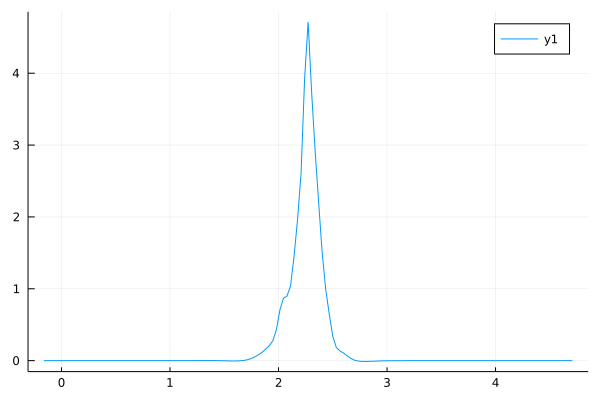

In [1001]:
TotalAbs=-(imag(Product3)+imag(Product5))*2*sqrt(2)*0.2*(2.314-0.2)

plot(FreqsTest[150:300],TotalAbs[150:300]) #These contributions capture the molecular linear response of
#the system (to be proven more rigorously...)

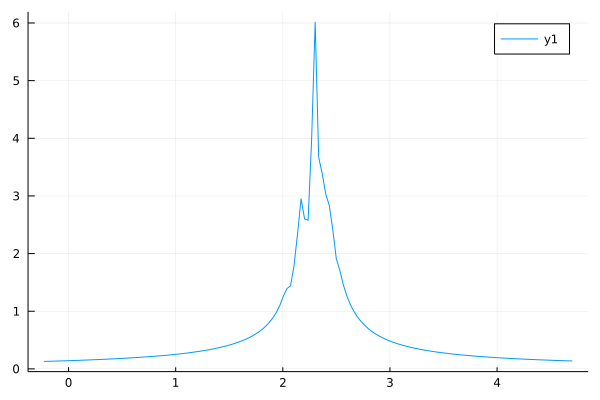

In [1002]:
#Following our bare-molecule approach we compute the expectation value of the frequency-resolved number of
#driving photons...

#We use the amplitude of the input photons that already introduced above...


plot(FreqsFFTMol[3850:4000],abs.(FouBathMol[3850:4000]))



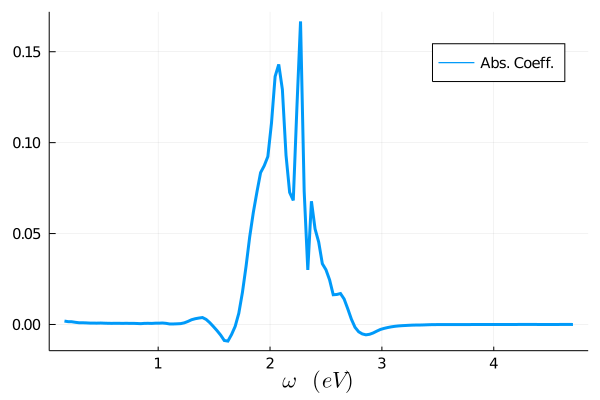

In [1003]:
spInput=Spline1D(FreqsFFTMol[3850:4000], abs.(FouBathMol[3850:4000]).^2; w=ones(length(FreqsFFTMol[3850:4000])),
    k=3, bc="nearest", s=0.0);

NormAbs=zeros(Float64,length(FreqsTest[150:300]))


for i in 1:length(FreqsTest[150:300])
    
    NormAbs[i]=TotalAbs[150+i-1]/(FreqsTest[150+i-1]*(evaluate(spInput,FreqsTest[150+i-1])/0.658))
    #NormAbs[i]=TotalAbs[3920+i-1]/abs(evaluate(spInput,FreqsTest[3920+i-1]))
    
end


plot(FreqsTest[160:300],(NormAbs[10:length(NormAbs)-1]),linewidth=3,xlabel=L"\omega\quad (eV)",
    xtickfont=10, ytickfont=10,guidefontsize=15,label="Abs. Coeff.",legendfontsize=10,legend=(0.8,0.85))
#savefig("Abs_inter1mol.pdf")

In [1004]:
spAbs=Spline1D(FreqsTest[160:300], NormAbs[10:length(NormAbs)-1]; w=ones(length(FreqsTest[160:300])), k=3, bc="nearest", s=0.0);

AdjustedAbsInter1Mol=zeros(Float64,length(FRangeIO))

for i in 1:length(FRangeIO)
    AdjustedAbsInter1Mol[i]= evaluate(spAbs,FRangeIO[i])
    
end

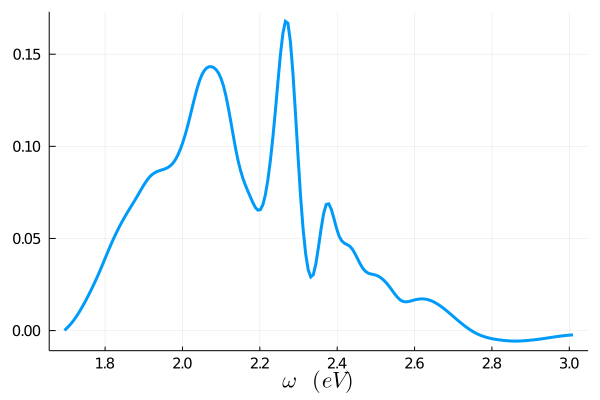

In [1005]:
plot(FRangeIO,AdjustedAbsInter1Mol,linewidth=3,xlabel=L"\omega\quad (eV)",
    xtickfont=10, ytickfont=10,guidefontsize=15,label="Abs. Coeff.",legend=false)
#savefig("Abs_inter1mol.pdf")

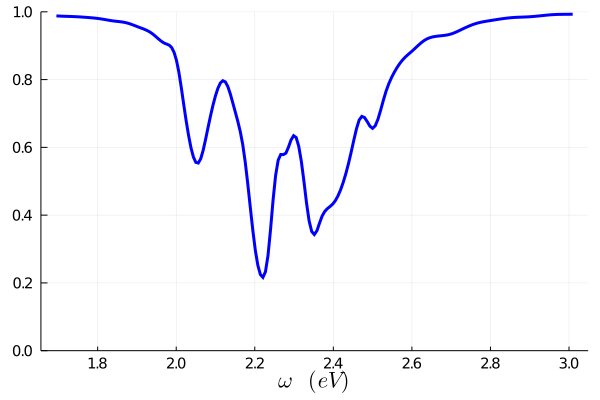

In [1006]:
#copy data in an array for further plotting below
RefInter1Mol=zeros(Float64,length(STot_NumMol[1,2,:]))

for i in 1:length(STot_NumMol[1,2,:])
    RefInter1Mol[i]=abs(STot_NumMol[1,2,i])^2
    
    
end


#plot(FRangeIO,abs.(STot_NumMol[1,2,:]).^2,linewidth=3,xlabel=L"\omega\quad (eV)",color=:blue,
#    xtickfont=10, ytickfont=10,guidefontsize=15,label="R. Coeff.",legend=false,ylims=(0,1))

plot(FRangeIO,RefInter1Mol,linewidth=3,xlabel=L"\omega\quad (eV)",color=:blue,
    xtickfont=10, ytickfont=10,guidefontsize=15,label="R. Coeff.",legend=false,ylims=(0,1))

#savefig("Ref_inter1mol.pdf")

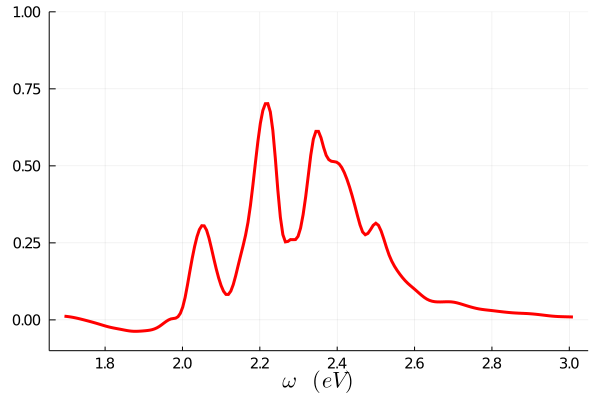

In [1008]:
TransInter1Mol=zeros(Float64,length(STot_NumMol[1,1,:]))

for i in 1:length(STot_NumMol[1,2,:])
    TransInter1Mol[i]=1-RefInter1Mol[i]-AdjustedAbsInter1Mol[i]
    
    
end


plot(FRangeIO,TransInter1Mol,linewidth=3,xlabel=L"\omega\quad (eV)",color=:red,
    xtickfont=10, ytickfont=10,guidefontsize=15,label="T. Coeff.",legend=false,ylims=(-0.1,1))

#plot(FRangeIO,ones(Float64,length(STot_NumMol[1,1,:]))-abs.(STot_NumMol[1,2,:]).^2-AdjustedAbs,linewidth=3,xlabel=L"\omega\quad (eV)",color=:red,
#    xtickfont=10, ytickfont=10,guidefontsize=15,label="T. Coeff.",legend=false,ylims=(-0.1,1))
#savefig("Trans_inter1mol.pdf")

# 1 Molecule, intermediate coupling: transient absorption

In [1009]:
#Load the data associated to the different wavepackets...
Cross_Phot20=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/20Cross_Phot_Gel_1Cav")
Cross_Exc20=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/20Cross_Exc_Gel_1Cav")

Cross_Phot40=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/40Cross_Phot_Gel_1Cav")
Cross_Exc40=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/40Cross_Exc_Gel_1Cav")

Cross_Phot60=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/60Cross_Phot_Gel_1Cav")
Cross_Exc60=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/60Cross_Exc_Gel_1Cav")

Cross_Phot80=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/80Cross_Phot_Gel_1Cav")
Cross_Exc80=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/80Cross_Exc_Gel_1Cav")

Cross_Phot100=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/100Cross_Phot_Gel_1Cav")
Cross_Exc100=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/100Cross_Exc_Gel_1Cav");



In [1010]:
#Load the data associated to the different wavepackets...
Cross_Phot201V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/20Cross_Phot_G1Cav1V")
Cross_Exc201V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/20Cross_Exc_G1Cav1V")

Cross_Phot401V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/40Cross_Phot_G1Cav1V")
Cross_Exc401V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/40Cross_Exc_G1Cav1V")

Cross_Phot601V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/60Cross_Phot_G1Cav1V")
Cross_Exc601V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/60Cross_Exc_G1Cav1V")

Cross_Phot801V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/80Cross_Phot_G1Cav1V")
Cross_Exc801V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/80Cross_Exc_G1Cav1V")

Cross_Phot1001V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/100Cross_Phot_G1Cav1V")
Cross_Exc1001V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/100Cross_Exc_G1Cav1V");


In [1011]:
#Load the data associated to the different wavepackets...
Cross_Phot202V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/20Cross_Phot_G1Cav2V")
Cross_Exc202V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/20Cross_Exc_G1Cav2V")

Cross_Phot402V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/40Cross_Phot_G1Cav2V")
Cross_Exc402V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/40Cross_Exc_G1Cav2V")

Cross_Phot602V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/60Cross_Phot_G1Cav2V")
Cross_Exc602V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/60Cross_Exc_G1Cav2V")

Cross_Phot802V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/80Cross_Phot_G1Cav2V")
Cross_Exc802V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/80Cross_Exc_G1Cav2V")

Cross_Phot1002V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/100Cross_Phot_G1Cav2V")
Cross_Exc1002V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Inter/NonLinear/CrossMaster/100Cross_Exc_G1Cav2V");

Timepts,=size(Cross_Phot20Exc_el);
deltaT=abs(Cross_Phot20Exc_el[1,1]-Cross_Phot20Exc_el[2,1])

LoadError: UndefVarError: Cross_Phot20Exc_el not defined

In [1012]:
#For ease of data management, we store the all the relevant correlation functions in 2 arrays of length 
#Timepts x number of delay times x number of auxiliary states

init=1
#endT=Timepts-3000
endT=Timepts
DelayN=5
AuxStates=3
TotTSim=deltaT*abs(Timepts-init+1)

PhotContrib=zeros(ComplexF64,(abs(Timepts-init+1),DelayN,AuxStates));
ExcContrib=zeros(ComplexF64,(abs(Timepts-init+1),DelayN,AuxStates));

FFTPhot=zeros(ComplexF64,(abs(Timepts-init+1),DelayN,AuxStates));
FFTExc=zeros(ComplexF64,(abs(Timepts-init+1),DelayN,AuxStates));

#We store the transient absoprtion spectrum for each of the delay times, and spllit it in the different 
#contributions...
TAbs=zeros(ComplexF64,(abs(Timepts-init+1),DelayN,AuxStates));


In [114]:
#Copying data...
PhotContrib[:,1,1]=conj(Cross_Phot20[init:endT,2]+im*Cross_Phot20[init:endT,3])
PhotContrib[:,2,1]=conj(Cross_Phot40[init:endT,2]+im*Cross_Phot40[init:endT,3])
PhotContrib[:,3,1]=conj(Cross_Phot60[init:endT,2]+im*Cross_Phot60[init:endT,3])
PhotContrib[:,4,1]=conj(Cross_Phot80[init:endT,2]+im*Cross_Phot80[init:endT,3])
PhotContrib[:,5,1]=conj(Cross_Phot100[init:endT,2]+im*Cross_Phot100[init:endT,3])

PhotContrib[:,1,2]=conj(Cross_Phot201V[init:endT,2]+im*Cross_Phot201V[init:endT,3])
PhotContrib[:,2,2]=conj(Cross_Phot401V[init:endT,2]+im*Cross_Phot401V[init:endT,3])
PhotContrib[:,3,2]=conj(Cross_Phot601V[init:endT,2]+im*Cross_Phot601V[init:endT,3])
PhotContrib[:,4,2]=conj(Cross_Phot801V[init:endT,2]+im*Cross_Phot801V[init:endT,3])
PhotContrib[:,5,2]=conj(Cross_Phot1001V[init:endT,2]+im*Cross_Phot1001V[init:endT,3])

PhotContrib[:,1,3]=conj(Cross_Phot202V[init:endT,2]+im*Cross_Phot202V[init:endT,3])
PhotContrib[:,2,3]=conj(Cross_Phot402V[init:endT,2]+im*Cross_Phot402V[init:endT,3])
PhotContrib[:,3,3]=conj(Cross_Phot602V[init:endT,2]+im*Cross_Phot602V[init:endT,3])
PhotContrib[:,4,3]=conj(Cross_Phot802V[init:endT,2]+im*Cross_Phot802V[init:endT,3])
PhotContrib[:,5,3]=conj(Cross_Phot1002V[init:endT,2]+im*Cross_Phot1002V[init:endT,3])


ExcContrib[:,1,1]=Cross_Exc20[init:endT,2]+im*Cross_Exc20[init:endT,3]
ExcContrib[:,2,1]=Cross_Exc40[init:endT,2]+im*Cross_Exc40[init:endT,3]
ExcContrib[:,3,1]=Cross_Exc60[init:endT,2]+im*Cross_Exc60[init:endT,3]
ExcContrib[:,4,1]=Cross_Exc80[init:endT,2]+im*Cross_Exc80[init:endT,3]
ExcContrib[:,5,1]=Cross_Exc100[init:endT,2]+im*Cross_Exc100[init:endT,3]

ExcContrib[:,1,2]=Cross_Exc201V[init:endT,2]+im*Cross_Exc201V[init:endT,3]
ExcContrib[:,2,2]=Cross_Exc401V[init:endT,2]+im*Cross_Exc401V[init:endT,3]
ExcContrib[:,3,2]=Cross_Exc601V[init:endT,2]+im*Cross_Exc601V[init:endT,3]
ExcContrib[:,4,2]=Cross_Exc801V[init:endT,2]+im*Cross_Exc801V[init:endT,3]
ExcContrib[:,5,2]=Cross_Exc1001V[init:endT,2]+im*Cross_Exc1001V[init:endT,3]

ExcContrib[:,1,3]=Cross_Exc202V[init:endT,2]+im*Cross_Exc202V[init:endT,3]
ExcContrib[:,2,3]=Cross_Exc402V[init:endT,2]+im*Cross_Exc402V[init:endT,3]
ExcContrib[:,3,3]=Cross_Exc602V[init:endT,2]+im*Cross_Exc602V[init:endT,3]
ExcContrib[:,4,3]=Cross_Exc802V[init:endT,2]+im*Cross_Exc802V[init:endT,3]
ExcContrib[:,5,3]=Cross_Exc1002V[init:endT,2]+im*Cross_Exc1002V[init:endT,3]



#Application of filter
#for i in 1:length(PhotContrib[:,1,1])
    
#    PhotContrib[i,:,:]=PhotContrib[i,:,:]*cos(pi*i/(2*length(PhotContrib[:,1,1])))
#    ExcContrib[i,:,:]=ExcContrib[i,:,:]*cos(pi*i/(2*length(ExcContrib[:,1,1])))
    
     
    
#end



FreqsTest=0.658*fftfreq(length(PhotContrib[:,1,1]))*2*pi/deltaT

for i in 1:length(PhotContrib[1,:,1]) #loop over the delay times
    
    for j in 1:length(PhotContrib[1,1,:]) #loop pver the contributions...
        FFTPhot[:,i,j]=ifft(PhotContrib[:,i,j])*TotTSim/0.658
        FFTExc[:,i,j]=ifft(ExcContrib[:,i,j])*TotTSim/0.658
        
        FFTPhot[:,i,j]=fftshift(FFTPhot[:,i,j])
        FFTExc[:,i,j]=fftshift(FFTExc[:,i,j])
        
    end
    
end

FreqsTest=fftshift(FreqsTest)



#We wrap up the result...

for i in 1:length(PhotContrib[1,:,1]) #loop over the delay times
    
    for j in 1:length(PhotContrib[1,1,:]) #loop pver the contributions...
        TAbs[:,i,j]=conj(FFTPhot[:,i,j]).*FFTExc[:,i,j]
    end
end







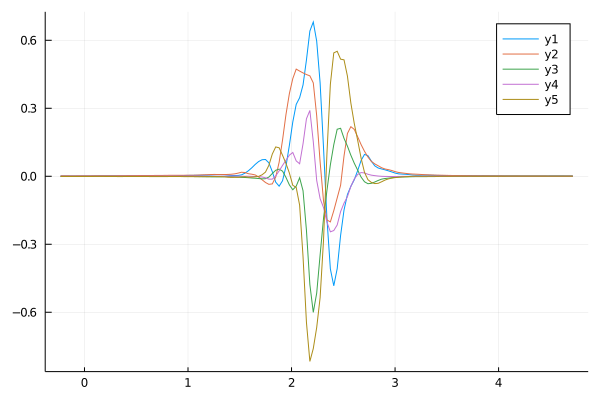

In [115]:
plot(FreqsTest[3850:4000],-imag(TAbs[3850:4000,1,1]))
plot!(FreqsTest[3850:4000],-imag(TAbs[3850:4000,2,1]))
plot!(FreqsTest[3850:4000],-imag(TAbs[3850:4000,3,1]))
plot!(FreqsTest[3850:4000],-imag(TAbs[3850:4000,4,1]))
plot!(FreqsTest[3850:4000],-imag(TAbs[3850:4000,5,1]))

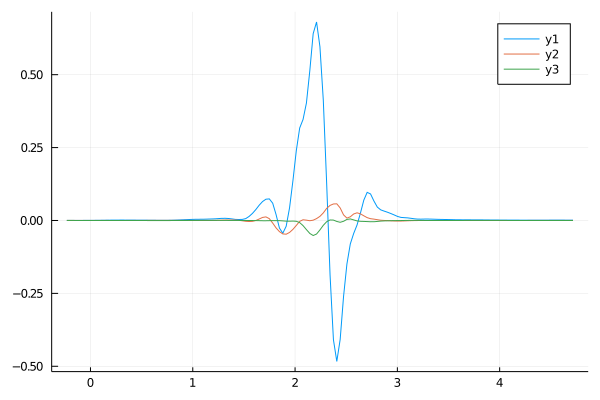

In [116]:
plot(FreqsTest[3850:4000],-imag(TAbs[3850:4000,1,1])) #Earliest delay time
plot!(FreqsTest[3850:4000],-imag(TAbs[3850:4000,1,2]))
plot!(FreqsTest[3850:4000],-imag(TAbs[3850:4000,1,3]))

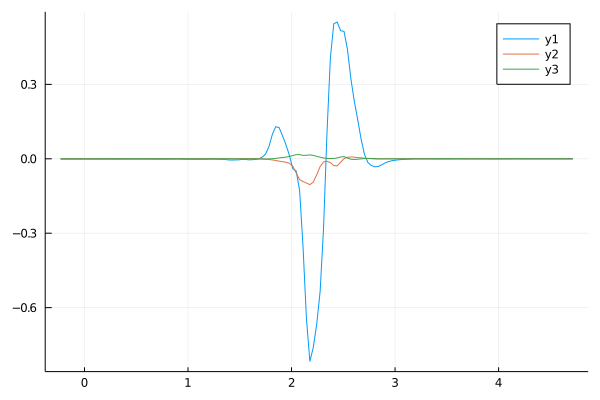

In [117]:
plot(FreqsTest[3850:4000],-imag(TAbs[3850:4000,5,1])) #Latest delay time
plot!(FreqsTest[3850:4000],-imag(TAbs[3850:4000,5,2]))
plot!(FreqsTest[3850:4000],-imag(TAbs[3850:4000,5,3]))

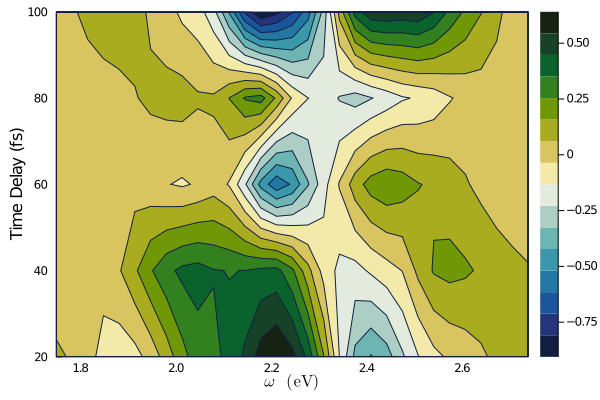

In [132]:
#rearranging data for plotting...
z=zeros(ComplexF64,(abs(endT-init+1),DelayN));

for i in 1:DelayN
    for j in 1:AuxStates
        z[:,i]+=TAbs[:,i,j]
        
    end
    
    
end

#x is the frequencies, y is the delay time...
y=[20.0,40.0, 60.0, 80.0, 100.0]  

#seriescolor=cgrad(ColorSchemes.leonardo.colors)
#contourf(FreqsTest[3900:3950], y, -imag(transpose(z[3900:3950,:])))


#contourf(FreqsTest[3900:3950], y, -imag(transpose(z[3900:3950,:])),seriescolor=cgrad(ColorSchemes.leonardo.colors))
#contourf(FreqsTest[3910:3940], y, -imag(transpose(z[3910:3940,:])),c=:cork)
contourf(FreqsTest[3910:3940], y, -imag(transpose(z[3910:3940,:])),c=:delta,ylabel="Time Delay (fs)",
    xlabel=L"\omega \quad (\textrm{eV})")

#contourf(FreqsTest[3910:3940], y, -imag(transpose(z[3910:3940,:])),c=:PuBu_5,ylabel="Time Delay (fs)",
#    xlabel=L"\omega \quad (\textrm{eV})")

#savefig("Abs_Detuning.pdf")


# 1 Molecule: weak coupling case

# 1 Molecule, weak coupling case: Linear Response

In [1595]:
#I only consider the results at 2.902 eV, to see to what extent we can reproduce the I/O scattering matrix
#AmpDum=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/Cavity_Resonant/expectationJul"); Using these file
#we obtain well-behaved results

AmpDum=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/Multipacket/EgV0P0/Cavity_Resonant/expectationJul")

Timepts,columns=size(AmpDum)

#Due to limitations in the MCTDH code, I need to formulate the problem in atomic units. To 
#define the dimensionless annhilitation operator a, we scale the time-dependent coordinate and 
#position derivatives and sum them appropietly:

#conversion of eV to atomic units...
#wcAt=wc*ConvEvToFreq
#dampAt=0.00736/2
#dampAt=0.0


#For purposes of simplicity in data handling, we define the next array:
MicAmpMol=zeros(ComplexF64,(Timepts,2))
#MicAmpC=zeros(ComplexF64,(Timepts,3))
BathAmpMol=zeros(ComplexF64,(Timepts,2))

#ExcExp=zeros(ComplexF64,(Timepts,2))

#PhotExc=zeros(ComplexF64,(Timepts,2))

#CohrExc=zeros(ComplexF64,(Timepts,2))


for i in 1:Timepts
    scale=AmpDum[i,2] #norm of the wavefunction. We need to scale each of expectation values computed by MCTDH
    #scale=1.0 #For the simulation of this driven oscillator, we need this scaling factor equal 
    #because the program computes the expectation value over the norm of the wavefunction
    
    MicAmpMol[i,1]=AmpDum[i,1] #Time coordinate
    MicAmpMol[i,2]=AmpDum[i,3]*scale #real part of coordinate
    MicAmpMol[i,2]+=im*AmpDum[i,4]*scale
    
       
    BathAmpMol[i,1]=AmpDum[i,1] #Time coordinate
    BathAmpMol[i,2]=AmpDum[i,5]*scale #real part of coordinate
    BathAmpMol[i,2]+=im*AmpDum[i,6]*scale
    
    #ExcExp[i,1]=AmpDum[i,1]
    #ExcExp[i,2]=AmpDum[i,7]*scale
    #ExcExp[i,2]+=im*AmpDum[i,8]*scale
    
    #PhotExc[i,1]=AmpDum[i,1]
    #PhotExc[i,2]=AmpDum[i,9]*scale
    #PhotExc[i,2]+=im*AmpDum[i,10]*scale
    
    #CohrExc[i,1]=AmpDum[i,1]
    #CohrExc[i,2]=AmpDum[i,11]*scale
    #CohrExc[i,2]+=im*AmpDum[i,12]*scale
   
    #MicAmpC[i,1]=AmpDum[i,1]
    #MicAmpC[i,2]=AmpDum[i,7]*scale
    #MicAmpC[i,2]+=im*AmpDum[i,8]*scale
    
end




deltaT=abs(MicAmpMol[1,1]-MicAmpMol[2,1]);
Ttime=abs(MicAmpMol[1,1]-MicAmpMol[Timepts,1]) #This is the total time of the simulation, in fs!!



125.32

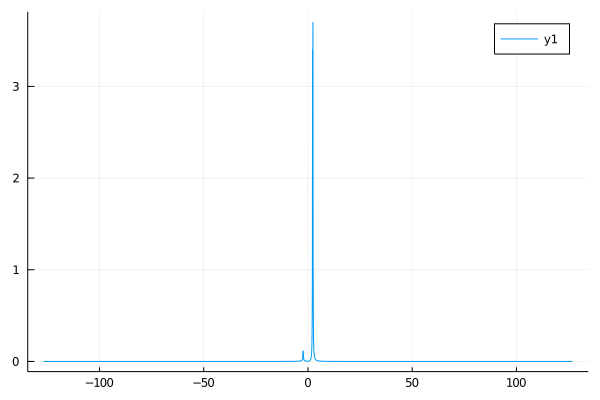

In [1596]:
FouMicMol=ifft(MicAmpMol[:,2])*length(MicAmpMol[:,2])*deltaT

FreqsFFTMol=0.658*fftfreq(length(MicAmpMol[:,2]))*2*pi/deltaT ;#Here we take advantage of the equal size along all dimensions
  
FreqsFFTMol=fftshift(FreqsFFTMol)
FouMicMol=fftshift(FouMicMol);
plot(FreqsFFTMol,abs.(FouMicMol))

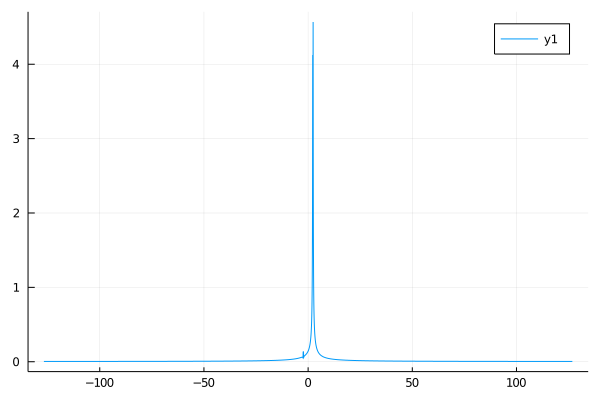

In [1597]:
FouBathMol=ifft(BathAmpMol[:,2])*length(MicAmpMol[:,2])*deltaT
FreqsFFTMol=0.658*fftfreq(length(MicAmpMol[:,2]))*2*pi/deltaT ;#Here we take advantage of the equal size along all dimensions
  
FreqsFFTMol=fftshift(FreqsFFTMol)
FouBathMol=fftshift(FouBathMol);
plot(FreqsFFTMol,abs.(FouBathMol))

In [1598]:
spRMicMol=Spline1D(real(FreqsFFTMol), real(FouMicMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);
spImMicMol=Spline1D(real(FreqsFFTMol),imag(FouMicMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);
spRBathMol=Spline1D(real(FreqsFFTMol), real(FouBathMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);
spImBathMol=Spline1D(real(FreqsFFTMol), imag(FouBathMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);

In [1599]:
#lets consider a range of frequencies for which we know the system-bath coupling constants
FRangeIdx=500:1:700 #WARNING: this is the range of indexes of the frequencies of interest. This must be selected
#such that they cover the frequency of the bath used in our effective model...

Rangepts=length(FRangeIdx)
FRangeIO=zeros(Float64,Rangepts)
for i in 1:Rangepts
    FRangeIO[i]=Freqs[FRangeIdx[i]].^2 *CovToEv/2 #Freqs in eVs!!!
end


#Rangepts=length(FRangeIdx)
#FRangeIO=Freqs[200:250].^2 *CovToEv/2 #Freqs in eVs!!! These parameters are already defined in the molecular-free
#section

#calculation "by hand" of the IO scattering matrix for each frequency
SIO_NumMol=zeros(ComplexF64,(2,2,Rangepts))

for i in 1:Rangepts
   #retrieve the system-bath coupling for each frequency, as well as the relative phase between the degenerate modes
    #conversion to sqrt(eV), those are the units of this guy...
    CoupLeft=sqrt(CovToEv)*HSB[1,1,FRangeIdx[i]] #left
    CoupRight=sqrt(CovToEv)*HSB[2,1,FRangeIdx[i]]; #right

    PsiLeft=angle(CoupLeft)
    PsiRight=angle(CoupRight)
    
    ELR=exp(-im*(PsiLeft-PsiRight)) #difference in phases of couplings
    AuxRatio=abs(CoupRight)/abs(CoupLeft)
    #ratio of bath and microcavity amplitudes...We assume that the bath that drives the system is always from the left
    #such that the we can scale that result appropiately to get the corresponding result for the right bath
    Ratio=(evaluate(spRMicMol,FRangeIO[i])+im*evaluate(spImMicMol,FRangeIO[i]))/(evaluate(spRBathMol,FRangeIO[i])+im*evaluate(spImBathMol,FRangeIO[i]))
    
    SIO_NumMol[1,1,i]=1-2*pi*im*abs(CoupLeft)*Ratio
    SIO_NumMol[1,2,i]=-2*pi*im*abs(CoupLeft)*AuxRatio*ELR*Ratio
    SIO_NumMol[2,1,i]=-2*pi*im*abs(CoupRight)*conj(ELR)*Ratio
    SIO_NumMol[2,2,i]=1-2*pi*im*abs(CoupRight)*AuxRatio*Ratio
    
    
    
end


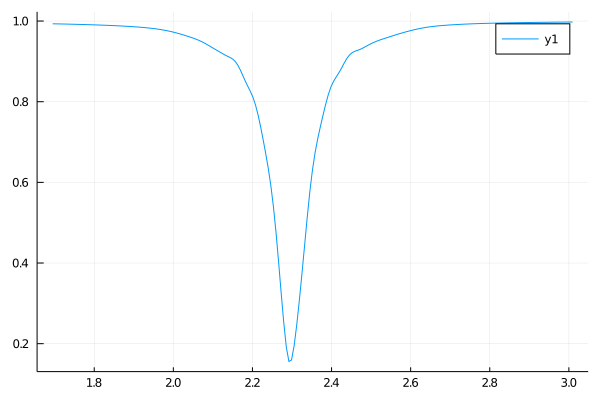

In [1600]:
plot(FRangeIO,abs.(SIO_NumMol[1,1,:]))

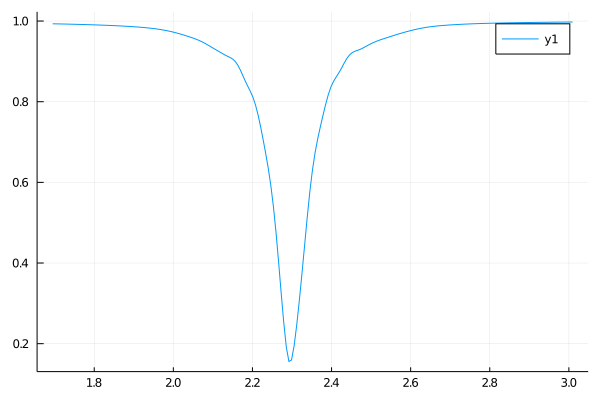

In [1601]:
plot(FRangeIO,abs.(SIO_NumMol[1,1,:]))

In [1602]:
#How does the Total (product of background and I/O scattering matrix) look like?
STot_NumMol=zeros(ComplexF64,(2,2,Rangepts))

for i in 1:Rangepts
    
    STot_NumMol[:,:,i]=*(ScatMats[:,:,FRangeIdx[i]],SIO_NumMol[:,:,i])
    
end

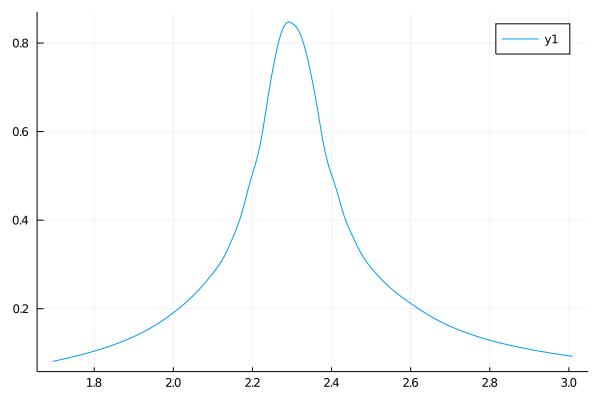

In [1603]:
plot(FRangeIO,abs.(STot_NumMol[1,1,:]))

In [1604]:
#Calculation of the molecular absorption
#Load the data associated to the different wavepackets...
EeV0P0_Exc=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/Multipacket/CrossMaster/EeV0P0Cross_Exc")
EeV0P0_Phot=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/Multipacket/CrossMaster/EeV0P0Cross_Phot")

EeV1P0_Exc=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/Multipacket/CrossMaster/EeV1P0Cross_Exc")
EeV1P0_Phot=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/Multipacket/CrossMaster/EeV1P0Cross_Phot")

EgV0P1_Exc=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/Multipacket/CrossMaster/EgV0P1Cross_Exc")
EgV0P1_Phot=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/Multipacket/CrossMaster/EgV0P1Cross_Phot");

EgV0P0_Exc=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/Multipacket/CrossMaster/EgV0P0Cross_Exc")
EgV0P0_Phot=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/Multipacket/CrossMaster/EgV0P0Cross_Phot");





Timepts,=size(EeV0P0_Exc)

(7713, 5)

In [1605]:
(Timepts-000)/2

3856.5

In [1606]:
SampTime

0.4134335932124168

In [1412]:
size(FreqsTest)

(308,)

In [1413]:

FreqsTest[2]-FreqsTest[1]

0.032467532467532756

In [1414]:
2*pi*0.658/abs(EeV0P0_Exc[1,1]-EeV0P0_Exc[7713,1])


0.03299023246189091

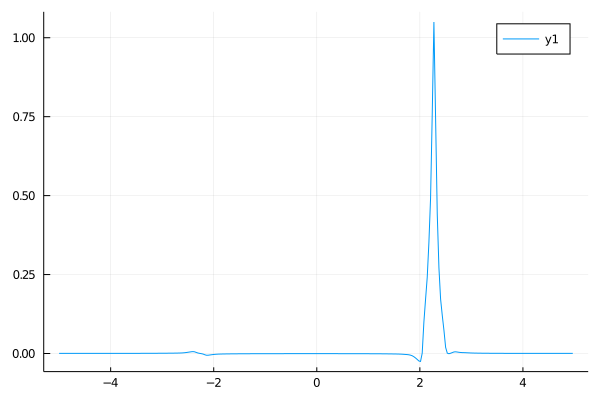

In [1607]:
init=1
#endT=Timepts-3000
endT=Timepts

TotTSim=abs(EeV0P0_Exc[init,1]-EeV0P0_Exc[endT,1]) #in fs

WRange=10. #Frequency range goes from -WRange/2 to WRange/2, in eV

SampTime=2*pi*0.658/WRange 

#sampling rate in fs
SampRate=Int64(div(2*pi*0.658/WRange,deltaT,RoundDown))

#total number of points:
TotPts=endT-init+1

#number of points to sample:
SampPts=Int64(div(TotPts,SampRate,RoundDown))

Filtered1=zeros(ComplexF64,SampPts)
Filtered2=zeros(ComplexF64,SampPts)
Filtered3=zeros(ComplexF64,SampPts)
Filtered4=zeros(ComplexF64,SampPts)
Filtered5=zeros(ComplexF64,SampPts)
Filtered6=zeros(ComplexF64,SampPts)
Filtered7=zeros(ComplexF64,SampPts)
Filtered8=zeros(ComplexF64,SampPts)






for i in 1:SampPts
    Filtered1[i]=conj(EgV0P1_Phot[init+i*SampRate-1,2]+im*EgV0P1_Phot[init+i*SampRate-1,3])
    Filtered2[i]=EgV0P1_Exc[init+i*SampRate-1,2]+im*EgV0P1_Exc[init+i*SampRate-1,3]

    #excited electronic, zero phonon, zero photon
    Filtered3[i]=conj(EeV1P0_Phot[init+i*SampRate-1,2]+im*EeV1P0_Phot[init+i*SampRate-1,3])
    Filtered4[i]=EeV1P0_Exc[init+i*SampRate-1,2]+im*EeV1P0_Exc[init+i*SampRate-1,3]

    #excited electronic, one phonon, zero photon
    Filtered5[i]=conj(EeV0P0_Phot[init+i*SampRate-1,2]+im*EeV0P0_Phot[init+i*SampRate-1,3])
    Filtered6[i]=EeV0P0_Exc[init+i*SampRate-1,2]+im*EeV0P0_Exc[init+i*SampRate-1,3]
    
    Filtered7[i]=conj(EgV0P0_Phot[init+i*SampRate-1,2]+im*EgV0P0_Phot[init+i*SampRate-1,3])
    Filtered8[i]=EgV0P0_Exc[init+i*SampRate-1,2]+im*EgV0P0_Exc[init+i*SampRate-1,3]

    #One excitation in the photon field: ground electronic, zero phonon, 1 photon
    #Filtered7[i]=conj(Exc0Vib1PhotCross_Phot[init+i*SampRate-1,2]+im*Exc0Vib1PhotCross_Phot[init+i*SampRate-1,3])
    #Filtered8[i]=Exc0Vib1PhotCross_Exc[init:endT,2]+im*Exc0Vib1PhotCross_Exc[init:endT,3]
 
    
end


#Application of filter
for i in 1:length(Filtered1)
    Filtered1[i]=Filtered1[i]#*cos(pi*i/(2*length(Filtered1[:,1])))
    Filtered2[i]=Filtered2[i]#*cos(pi*i/(2*length(Filtered2[:,1])))
    
    Filtered3[i]=Filtered3[i]#*cos(pi*i/(2*length(Filtered3[:,1])))
    Filtered4[i]=Filtered4[i]#*cos(pi*i/(2*length(Filtered4[:,1])))
    
    Filtered5[i]=Filtered5[i]#*cos(pi*i/(2*length(Filtered5[:,1])))
    Filtered6[i]=Filtered6[i]#*cos(pi*i/(2*length(Filtered6[:,1])))
    
    Filtered7[i]=Filtered7[i]#*cos(pi*i/(2*length(Filtered7[:,1])))
    Filtered8[i]=Filtered8[i]#*cos(pi*i/(2*length(Filtered8[:,1])))
    
    
    
end



FreqsTest=0.658*fftfreq(length(Filtered1[:,1]))*2*pi/SampTime


FouTest1=ifft(Filtered1)*TotTSim/0.658 #Fourier transform in units of eV^-1
FouTest2=ifft(Filtered2)*TotTSim/0.658 

FouTest3=ifft(Filtered3)*TotTSim/0.658 
FouTest4=ifft(Filtered4)*TotTSim/0.658 

FouTest5=ifft(Filtered5)*TotTSim/0.658 
FouTest6=ifft(Filtered6)*TotTSim/0.658 

FouTest7=ifft(Filtered7)*TotTSim/0.658 
FouTest8=ifft(Filtered8)*TotTSim/0.658 


#****
#l=3855
#for i in 1:length(FouTest)
#    FouTest[i]=exp(im*l*FreqsTest[i])*FouTest[i]
#end

#****


FreqsTest=fftshift(FreqsTest)
FouTest1=fftshift(FouTest1);
FouTest2=fftshift(FouTest2);

FouTest3=fftshift(FouTest3);
FouTest4=fftshift(FouTest4);

FouTest5=fftshift(FouTest5);
FouTest6=fftshift(FouTest6);

FouTest7=fftshift(FouTest7)
FouTest8=fftshift(FouTest8);



Product1=conj(FouTest1).*(FouTest2)

Product2=conj(FouTest3).*(FouTest4)

Product3=conj(FouTest5).*(FouTest6)

Product4=conj(FouTest7).*FouTest8

#plot(FreqsTest[2300:2500],(imag(Product[2300:2500])))
#plot(FreqsTest[3850:4000],imag(Product1[3850:4000]))
#plot!(FreqsTest[3850:4000],imag(Product2[3850:4000]))
#plot!(FreqsTest[3850:4000],imag(Product3[3850:4000]))

#plot(FreqsTest[3850:4000],-(imag(Product3[3850:4000])+imag(Product2[3850:4000]+imag(Product1[3850:4000]))))

#plot(FreqsTest[1350:1500],abs.(imag(Product3[1350:1500])+imag(Product2[1350:1500])+imag(Product1[1350:1500])))

plot(FreqsTest,-(imag(Product4)+imag(Product3)+imag(Product2)+imag(Product1)))


In [1608]:
AbsCorrExcWeak1Mol=zeros(ComplexF64,length(EgV0P0_Exc[:,2]))
AbsCorrPhotWeak1Mol=zeros(ComplexF64,length(EgV0P0_Phot[:,2]))

for i in 1:length(EgV0P0_Exc[:,2])
    AbsCorrExcWeak1Mol[i]=EgV0P0_Exc[i,2]+im*EgV0P0_Exc[i,3]
    AbsCorrPhotWeak1Mol[i]=EgV0P0_Phot[i,2]+im*EgV0P0_Phot[i,3]
    
end

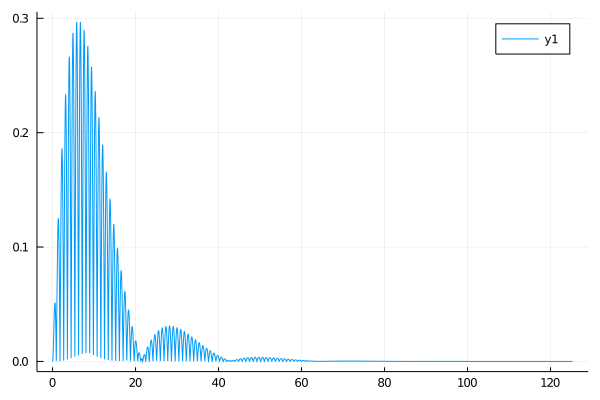

In [1609]:
plot(real(MicAmpMol[:,1]),abs.(AbsCorrPhotWeak1Mol))

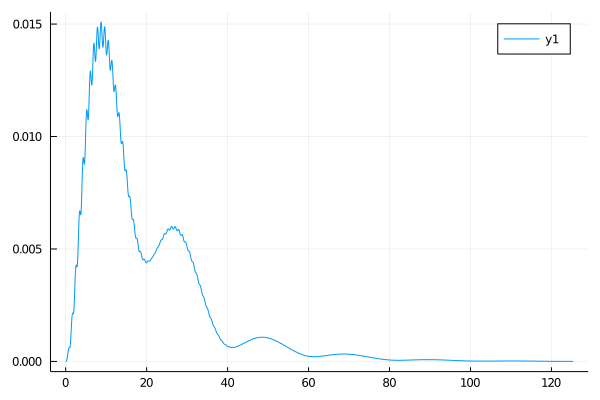

In [1610]:
plot(real(MicAmpMol[:,1]),abs.(AbsCorrExcWeak1Mol))

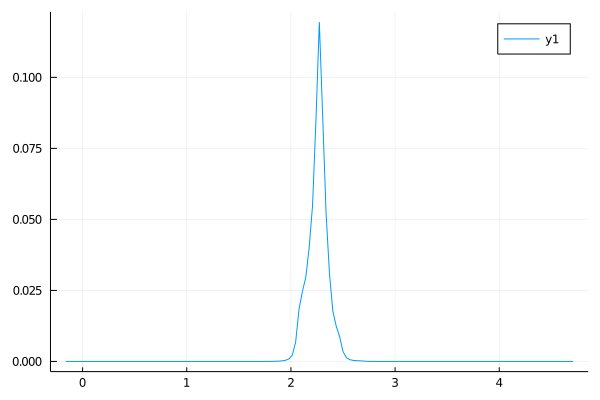

In [1611]:
TotalAbs=-(imag(Product4)*2*sqrt(2)*0.02*(2.314-0.2)) #we are scaling the absorption by the single-molecule
#-cavity coupling and the frequency of the electronic transition
                                                

plot(FreqsTest[150:300],TotalAbs[150:300])
#These are the contributions to first order in the external field-cavity coupling...



In [1612]:
FouBathMolWeak1Mol=zeros(ComplexF64,length(FreqsFFTMol[3850:4000]))

for i in 1:length(FreqsFFTMol[3850:4000])
    FouBathMolWeak1Mol[i]=FouBathMol[i+3850-1]
end



#plot(FreqsFFTMol[3850:4000], abs.(FouBathMol[3850:4000]).^2)

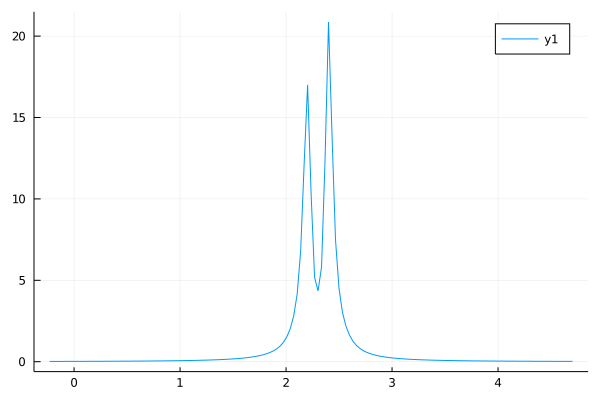

In [1613]:
plot(FreqsFFTMol[3850:4000], abs.(FouBathMolWeak1Mol).^2)

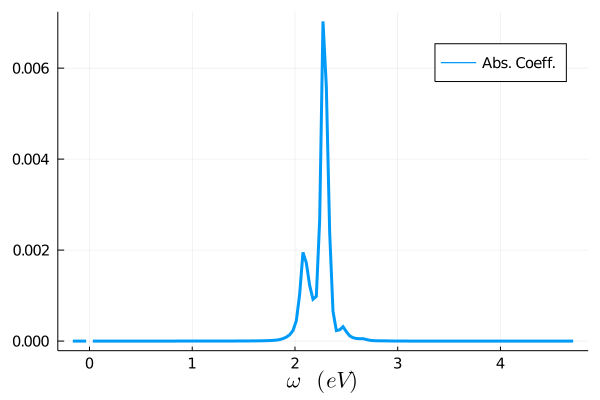

In [1614]:
#spInput=Spline1D(FreqsFFTMol[3850:4000], abs.(FouBathMol[3850:4000]).^2; w=ones(length(FreqsFFTMol[3850:4000])),
#    k=3, bc="nearest", s=0.0);

spInput=Spline1D(FreqsFFTMol[3850:4000], abs.(FouBathMolWeak1Mol).^2; w=ones(length(FreqsFFTMol[3850:4000])),
    k=3, bc="nearest", s=0.0);

NormAbs=zeros(Float64,length(FreqsTest[150:300]))


for i in 1:length(FreqsTest[150:300])
    
    NormAbs[i]=TotalAbs[150+i-1]/(FreqsTest[150+i-1]*(evaluate(spInput,FreqsTest[150+i-1]))/0.658)
    #NormAbs[i]=TotalAbs[3920+i-1]/abs(evaluate(spInput,FreqsTest[3920+i-1]))
    
end

#This should be the (unitless ) absorption coefficient... which it is my understanding it is 
#directly related to the absoprtion cross-section
plot(FreqsTest[150:300],(NormAbs),linewidth=3,xlabel=L"\omega\quad (eV)",
    xtickfont=10, ytickfont=10,guidefontsize=15,label="Abs. Coeff.",legendfontsize=10,legend=(0.8,0.85))
#savefig("Abs_weak1mol.pdf")

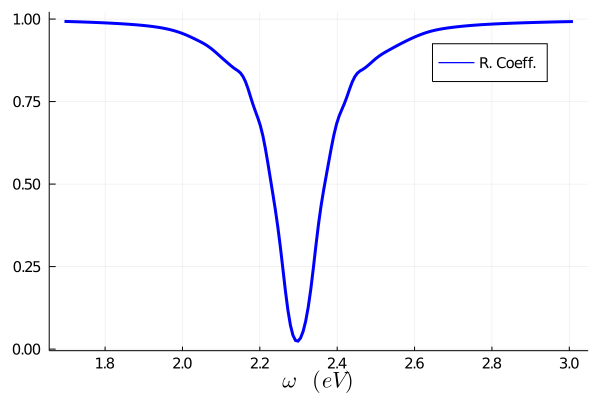

In [1615]:
#Plotting the reflection and transmission spectra
plot(FRangeIO,abs.(STot_NumMol[1,2,:]).^2,linewidth=3,xlabel=L"\omega\quad (eV)",color=:blue,
    xtickfont=10, ytickfont=10,guidefontsize=15,label="R. Coeff.",legendfontsize=10,legend=(0.8,0.85))


In [1616]:
FreqsTest[157]

0.06493506493506494

In [1617]:
#we interpolate the absorption spectrum...

spAbs=Spline1D(FreqsTest[157:300], NormAbs[7:length(NormAbs)-1]; w=ones(length(FreqsTest[157:300])), k=3, bc="nearest", s=0.0);

AdjustedAbsWeak1Mol=zeros(Float64,length(FRangeIO))

for i in 1:length(FRangeIO)
    AdjustedAbsWeak1Mol[i]= evaluate(spAbs,FRangeIO[i])
    
end



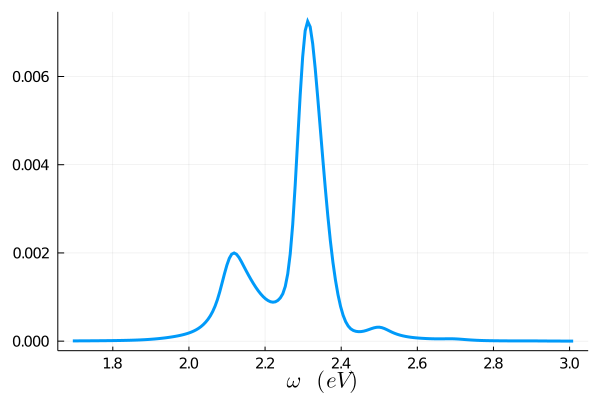

In [1618]:
plot(FRangeIO,AdjustedAbsWeak1Mol,linewidth=3,xlabel=L"\omega\quad (eV)",
    xtickfont=10, ytickfont=10,guidefontsize=15,label="Abs. Coeff.",legend=false)
#savefig("Abs_weak1mol.pdf")

In [1037]:
#We compute the total (contributions from the background and I/O components) transmission spectrum,
#by simply substracting absorption+reflection from 1:



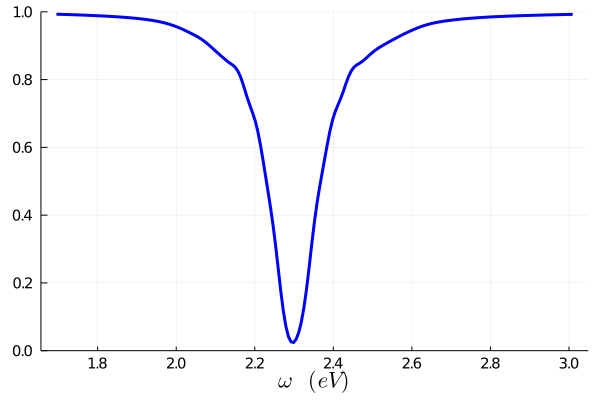

In [1619]:
RefWeak1Mol=zeros(Float64,length(FRangeIO))
for i in 1:length(FRangeIO)
    RefWeak1Mol[i]=abs(STot_NumMol[1,2,i])^2
end


plot(FRangeIO,RefWeak1Mol,linewidth=3,xlabel=L"\omega\quad (eV)",color=:blue,
    xtickfont=10, ytickfont=10,guidefontsize=15,label="R. Coeff.",legend=false,ylims=(0,1))

#plot(FRangeIO,abs.(STot_NumMol[1,2,:]).^2,linewidth=3,xlabel=L"\omega\quad (eV)",color=:blue,
#    xtickfont=10, ytickfont=10,guidefontsize=15,label="R. Coeff.",legend=false,ylims=(0,1))
#savefig("Ref_weak1mol.pdf")

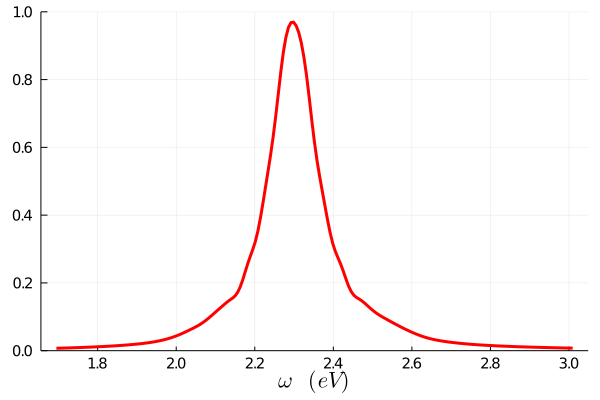

In [1620]:
TransWeak1Mol=zeros(Float64,length(FRangeIO))

for i in 1:length(FRangeIO)
    TransWeak1Mol[i]=1-RefWeak1Mol[i]-AdjustedAbsWeak1Mol[i]
end


plot(FRangeIO,TransWeak1Mol,linewidth=3,xlabel=L"\omega\quad (eV)",color=:red,
    xtickfont=10, ytickfont=10,guidefontsize=15,label="T. Coeff.",legend=false,ylims=(0,1))

#plot(FRangeIO,ones(Float64,length(STot_NumMol[1,1,:]))-abs.(STot_NumMol[1,2,:]).^2-AdjustedAbs,linewidth=3,xlabel=L"\omega\quad (eV)",color=:red,
#    xtickfont=10, ytickfont=10,guidefontsize=15,label="T. Coeff.",legend=false,ylims=(0,1))

#savefig("Trans_weak1mol.pdf")


201

# 1 Molecule, weak coupling case: Transient absorption

In [297]:
#Load the data associated to the different wavepackets...
#HERE I MISTAKELY USED AN AUXILIARY STATE THAT DOES NOT ACCOUNT FOR THE LEADING CONTRIBUTIONS TO 
#THE TRANSIENT ABSORPTION...
#
#Cross_Phot20Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/20Cross_Phot_Exc_el")
#Cross_Exc20Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/20Cross_Exc_Exc_el")

#Cross_Phot40Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/40Cross_Phot_Exc_el")
#Cross_Exc40Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/40Cross_Exc_Exc_el")

#Cross_Phot60Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/60Cross_Phot_Exc_el")
#Cross_Exc60Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/60Cross_Exc_Exc_el")

#Cross_Phot80Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/80Cross_Phot_Exc_el")
#Cross_Exc80Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/80Cross_Exc_Exc_el")

#Cross_Phot100Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/100Cross_Phot_Exc_el")
#Cross_Exc100Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/100Cross_Exc_Exc_el");

#Timepts,=size(Cross_Phot20Exc_el);
#deltaT=abs(Cross_Phot20Exc_el[1,1]-Cross_Phot20Exc_el[2,1])

0.01625

In [12]:
#Load the data associated to the different wavepackets...
Cross_Phot20GV1P1=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/20Cross_Phot_GV1P1")
Cross_Exc20GV1P1=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/20Cross_Exc_GV1P1")

Cross_Phot40GV1P1=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/40Cross_Phot_GV1P1")
Cross_Exc40GV1P1=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/40Cross_Exc_GV1P1")

Cross_Phot60GV1P1=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/60Cross_Phot_GV1P1")
Cross_Exc60GV1P1=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/60Cross_Exc_GV1P1")

Cross_Phot80GV1P1=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/80Cross_Phot_GV1P1")
Cross_Exc80GV1P1=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/80Cross_Exc_GV1P1")

Cross_Phot100GV1P1=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/100Cross_Phot_GV1P1")
Cross_Exc100GV1P1=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/100Cross_Exc_GV1P1");



In [13]:
Cross_Phot20Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/20Cross_Phot_Gel_1Cav")
Cross_Exc20Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/20Cross_Exc_Gel_1Cav")

Cross_Phot40Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/40Cross_Phot_Gel_1Cav")
Cross_Exc40Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/40Cross_Exc_Gel_1Cav")

Cross_Phot60Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/60Cross_Phot_Gel_1Cav")
Cross_Exc60Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/60Cross_Exc_Gel_1Cav")

Cross_Phot80Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/80Cross_Phot_Gel_1Cav")
Cross_Exc80Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/80Cross_Exc_Gel_1Cav")

Cross_Phot100Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/100Cross_Phot_Gel_1Cav")
Cross_Exc100Exc_el=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/CrossMaster/100Cross_Exc_Gel_1Cav");

Timepts,=size(Cross_Phot20Exc_el);
deltaT=abs(Cross_Phot20Exc_el[1,1]-Cross_Phot20Exc_el[2,1])
timecoord=Cross_Phot20Exc_el[:,1];

In [6]:
Timepts-500

7213

In [7]:
500*deltaT

8.125

In [14]:
#For ease of data management, we store the all the relevant correlation functions in 2 arrays of length 
#Timepts x number of delay times x number of auxiliary states

init=1
#endT=Timepts-3000
endT=Timepts
TotTSim=abs(Cross_Phot20Exc_el[init,1]-Cross_Phot20Exc_el[endT,1])

DelayN=5
AuxStates=2

PhotContrib=zeros(ComplexF64,(abs(endT-init+1),DelayN,AuxStates));
ExcContrib=zeros(ComplexF64,(abs(endT-init+1),DelayN,AuxStates));

FFTPhot=zeros(ComplexF64,(abs(endT-init+1),DelayN,AuxStates));
FFTExc=zeros(ComplexF64,(abs(endT-init+1),DelayN,AuxStates));

#We store the transient absoprtion spectrum for each of the delay times, and spllit it in the different 
#contributions...
TAbs=zeros(ComplexF64,(abs(endT-init+1),DelayN,AuxStates));

In [15]:
#Copying data...
PhotContrib[:,1,1]=conj(Cross_Phot20GV1P1[init:endT,2]+im*Cross_Phot20GV1P1[init:endT,3])
PhotContrib[:,2,1]=conj(Cross_Phot40GV1P1[init:endT,2]+im*Cross_Phot40GV1P1[init:endT,3])
PhotContrib[:,3,1]=conj(Cross_Phot60GV1P1[init:endT,2]+im*Cross_Phot60GV1P1[init:endT,3])
PhotContrib[:,4,1]=conj(Cross_Phot80GV1P1[init:endT,2]+im*Cross_Phot80GV1P1[init:endT,3])
PhotContrib[:,5,1]=conj(Cross_Phot100GV1P1[init:endT,2]+im*Cross_Phot100GV1P1[init:endT,3])

PhotContrib[:,1,2]=conj(Cross_Phot20Exc_el[init:endT,2]+im*Cross_Phot20Exc_el[init:endT,3])
PhotContrib[:,2,2]=conj(Cross_Phot40Exc_el[init:endT,2]+im*Cross_Phot40Exc_el[init:endT,3])
PhotContrib[:,3,2]=conj(Cross_Phot60Exc_el[init:endT,2]+im*Cross_Phot60Exc_el[init:endT,3])
PhotContrib[:,4,2]=conj(Cross_Phot80Exc_el[init:endT,2]+im*Cross_Phot80Exc_el[init:endT,3])
PhotContrib[:,5,2]=conj(Cross_Phot100Exc_el[init:endT,2]+im*Cross_Phot100Exc_el[init:endT,3])



ExcContrib[:,1,1]=(Cross_Exc20GV1P1[init:endT,2]+im*Cross_Exc20GV1P1[init:endT,3])
ExcContrib[:,2,1]=(Cross_Exc40GV1P1[init:endT,2]+im*Cross_Exc40GV1P1[init:endT,3])
ExcContrib[:,3,1]=(Cross_Exc60GV1P1[init:endT,2]+im*Cross_Exc60GV1P1[init:endT,3])
ExcContrib[:,4,1]=(Cross_Exc80GV1P1[init:endT,2]+im*Cross_Exc80GV1P1[init:endT,3])
ExcContrib[:,5,1]=(Cross_Exc100GV1P1[init:endT,2]+im*Cross_Exc100GV1P1[init:endT,3])

ExcContrib[:,1,2]=(Cross_Exc20Exc_el[init:endT,2]+im*Cross_Exc20Exc_el[init:endT,3])
ExcContrib[:,2,2]=Cross_Exc40Exc_el[init:endT,2]+im*Cross_Exc40Exc_el[init:endT,3]
ExcContrib[:,3,2]=Cross_Exc60Exc_el[init:endT,2]+im*Cross_Exc60Exc_el[init:endT,3]
ExcContrib[:,4,2]=Cross_Exc80Exc_el[init:endT,2]+im*Cross_Exc80Exc_el[init:endT,3]
ExcContrib[:,5,2]=Cross_Exc100Exc_el[init:endT,2]+im*Cross_Exc100Exc_el[init:endT,3]





#Application of filter
#for i in 1:length(PhotContrib[:,1,1])
    
#    PhotContrib[i,:,:]=PhotContrib[i,:,:]*cos(pi*i/(2*length(PhotContrib[:,1,1])))
#    ExcContrib[i,:,:]=ExcContrib[i,:,:]*cos(pi*i/(2*length(ExcContrib[:,1,1])))
    
     
    
#end



FreqsTest=0.658*fftfreq(length(PhotContrib[:,1,1]))*2*pi/deltaT

for i in 1:length(PhotContrib[1,:,1]) #loop over the delay times
    
    for j in 1:length(PhotContrib[1,1,:]) #loop pver the contributions...
        FFTPhot[:,i,j]=ifft(PhotContrib[:,i,j])*TotTSim/0.658
        FFTExc[:,i,j]=ifft(ExcContrib[:,i,j])*TotTSim/0.658
        
        FFTPhot[:,i,j]=fftshift(FFTPhot[:,i,j])
        FFTExc[:,i,j]=fftshift(FFTExc[:,i,j])
        
    end
    
end

FreqsTest=fftshift(FreqsTest)



#We wrap up the result...

for i in 1:length(PhotContrib[1,:,1]) #loop over the delay times
    
    for j in 1:length(PhotContrib[1,1,:]) #loop pver the contributions...
        TAbs[:,i,j]=conj(FFTPhot[:,i,j]).*FFTExc[:,i,j]
    end
end



In [9]:
endT/2

3856.5

In [16]:
#####MAKING A PAUSE: lets analyze the profile of electronic populations as a fucntion of time for the
#propagation of the delay at 20 fs:
Prop20= readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/20/First_Order/Cavity_Resonant/expectationJul");
Prop40= readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Weak/NonLinear2/40/First_Order/Cavity_Resonant/expectationJul");


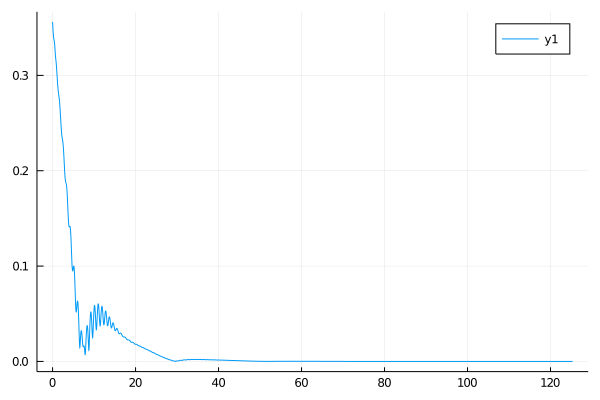

In [12]:
plot(real(Prop20[:,1]),abs.(Cross_Phot20Exc_el[:,2]+im*Cross_Phot20Exc_el[:,3]))

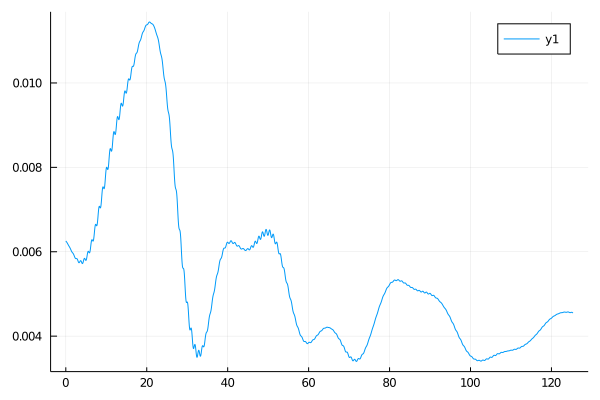

In [13]:
plot(real(Prop40[:,1]),Prop40[:,7]) #exciton population

#plot!(real(Prop40[:,1]),Prop40[:,11]) #ground state population

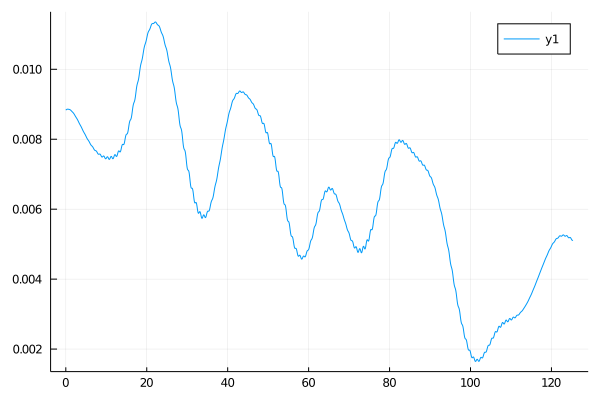

In [14]:
plot(real(Prop20[:,1]),Prop20[:,7]) #exciton population

#plot!(real(Prop20[:,1]),Prop20[:,11]) #ground state population

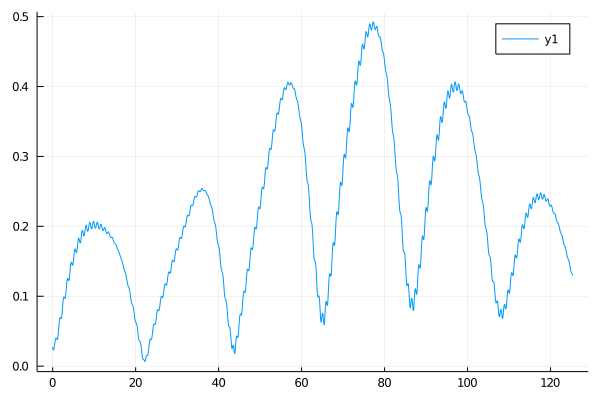

In [467]:
plot(real(Prop20[:,1]),abs.(Prop20[:,3]+im*Prop20[:,4]))

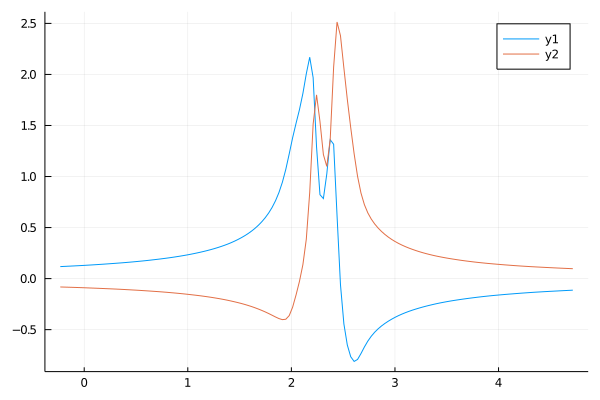

In [15]:
plot(FreqsTest[3850:4000],real(FFTPhot[3850:4000,2,2]))
plot!(FreqsTest[3850:4000],imag(FFTPhot[3850:4000,2,2]))


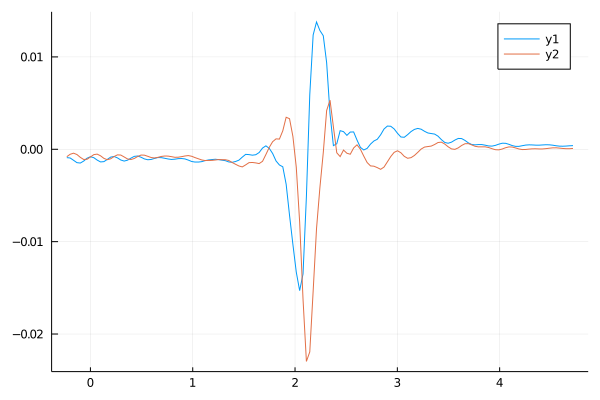

In [16]:
plot(FreqsTest[3850:4000],real(FFTExc[3850:4000,2,2]))
plot!(FreqsTest[3850:4000],imag(FFTExc[3850:4000,2,2]))

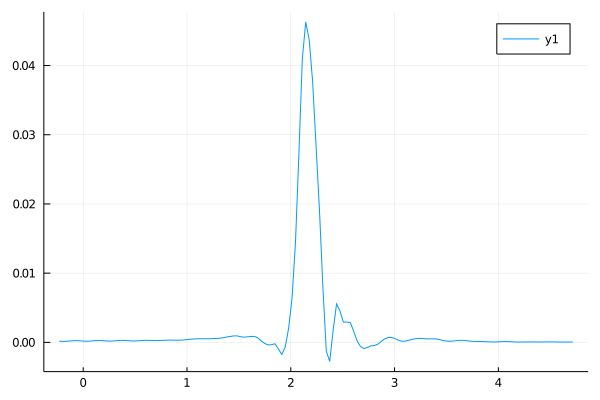

In [17]:
plot(FreqsTest[3850:4000],-imag(TAbs[3850:4000,2,2]))
#plot!(FreqsTest[3850:4000],-imag(TAbs[3850:4000,1,2]))
#plot!(FreqsTest[3850:4000],-imag(TAbs[3850:4000,3,2]))
#plot!(FreqsTest[3850:4000],-imag(TAbs[3850:4000,4,2]))
#plot!(FreqsTest[3850:4000],-imag(TAbs[3850:4000,5,2]))

#plot!(FreqsTest[3850:4000],-imag(TAbs[3850:4000,1,1]))

In [18]:
#Taking the auxiliary state the one with one microcavity photon and the electronic ground state...

plot(FreqsTest[3850:4000],-imag(Product1[3850:4000]))
plot!(FreqsTest[3850:4000],-imag(Product2[3850:4000]))
plot!(FreqsTest[3850:4000],-imag(Product3[3850:4000]))
plot!(FreqsTest[3850:4000],-imag(Product4[3850:4000]))
plot!(FreqsTest[3850:4000],-imag(Product5[3850:4000]))

LoadError: UndefVarError: Product1 not defined

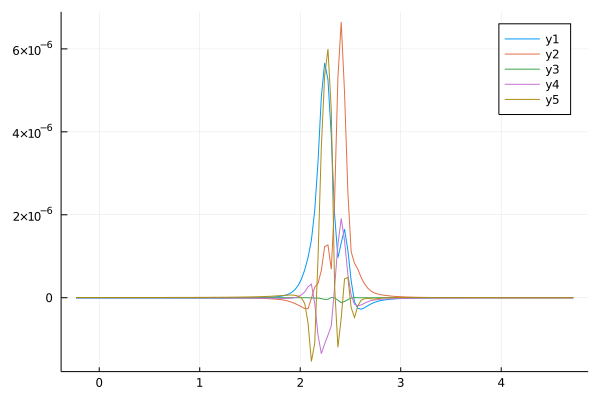

In [317]:
#taking the auxiliary state the one with the electronic ground state and zero cavity photons...
plot(FreqsTest[3850:4000],-imag(Product1[3850:4000]))
plot!(FreqsTest[3850:4000],-imag(Product2[3850:4000]))
plot!(FreqsTest[3850:4000],-imag(Product3[3850:4000]))
plot!(FreqsTest[3850:4000],-imag(Product4[3850:4000]))
plot!(FreqsTest[3850:4000],-imag(Product5[3850:4000]))

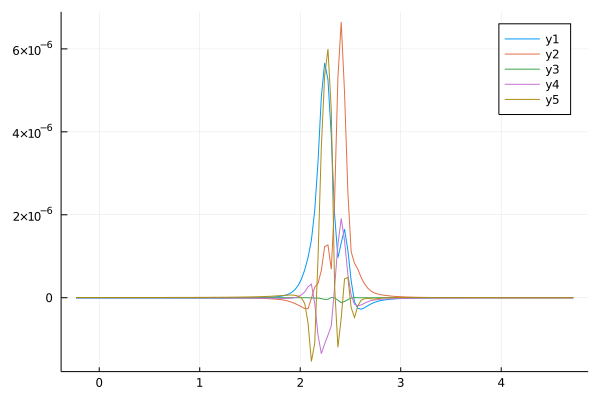

In [313]:
plot(FreqsTest[3850:4000],-imag(Product1[3850:4000]))
plot!(FreqsTest[3850:4000],-imag(Product2[3850:4000]))
plot!(FreqsTest[3850:4000],-imag(Product3[3850:4000]))
plot!(FreqsTest[3850:4000],-imag(Product4[3850:4000]))
plot!(FreqsTest[3850:4000],-imag(Product5[3850:4000]))

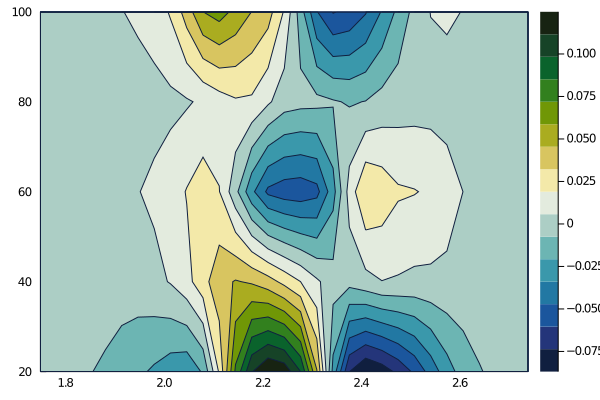

In [17]:

#rearranging data for plotting...
z=zeros(ComplexF64,(abs(endT-init+1),DelayN));

for i in 1:DelayN
    for j in 1:AuxStates
        z[:,i]+=TAbs[:,i,j]
        
    end
    
    
end

#x is the frequencies, y is the delay time...
y=[20.0,40.0, 60.0, 80.0, 100.0]  

#seriescolor=cgrad(ColorSchemes.leonardo.colors)
#contourf(FreqsTest[3900:3950], y, -imag(transpose(z[3900:3950,:])))


#contourf(FreqsTest[3900:3950], y, -imag(transpose(z[3900:3950,:])),seriescolor=cgrad(ColorSchemes.leonardo.colors))
#contourf(FreqsTest[3910:3940], y, -imag(transpose(z[3910:3940,:])),c=:cork)
contourf(FreqsTest[3910:3940], y, -imag(transpose(z[3910:3940,:])),c=:delta)


In [25]:
size(z)

(7713, 5)

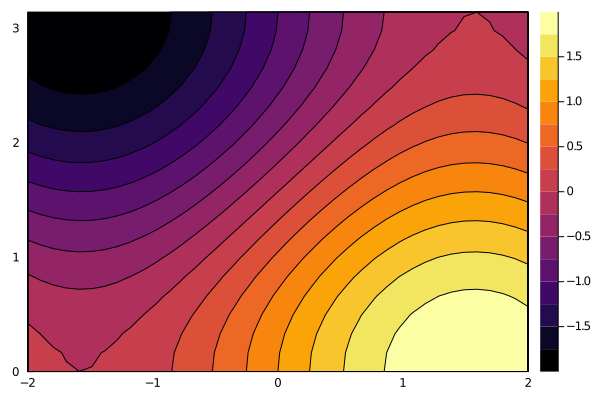

In [28]:
#using GR
#Plotting of the whole set of data...

# Create example point data
x = 8 .* rand(100) .- 4
y = 8 .* rand(100) .- 4
z = sin.(x) .+ cos.(y)
 # Draw the contour plot
contourf(x, y, z)
# Create example grid data
x = LinRange(-2, 2, 40)
y = LinRange(0, pi, 20)
z = sin.(x') .+ cos.(y)
# Draw the contour plot
contourf(x, y, z)
# Draw the contour plot using a callable
#contour(x, y, (x,y) -> sin(x) + cos(y))


In [20]:
size(z)

(20, 40)

In [563]:
x = 8 .* rand(100) .- 4
y = 8 .* rand(100) .- 4
z = sin.(x) .+ cos.(y)
 # Draw the contour plot
contour(x, y, z)

LoadError: UndefVarError: contour not defined

In [134]:
0.2/sqrt(2)

0.1414213562373095

# 1 Molecule: stronger coupling case

In [1040]:
#I only consider the results at 2.902 eV, to see to what extent we can reproduce the I/O scattering matrix
#AmpDum=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/Cavity_Resonant/expectationJul"); 

AmpDum=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/Multipacket/EgV0P0/Cavity_Resonant/expectationJul")


Timepts,columns=size(AmpDum)

#Due to limitations in the MCTDH code, I need to formulate the problem in atomic units. To 
#define the dimensionless annhilitation operator a, we scale the time-dependent coordinate and 
#position derivatives and sum them appropietly:

#conversion of eV to atomic units...
#wcAt=wc*ConvEvToFreq
#dampAt=0.00736/2
#dampAt=0.0


#For purposes of simplicity in data handling, we define the next array:
MicAmpMol=zeros(ComplexF64,(Timepts,2))
#MicAmpC=zeros(ComplexF64,(Timepts,3))
BathAmpMol=zeros(ComplexF64,(Timepts,2))

#ExcExp=zeros(ComplexF64,(Timepts,2))

#CohrExc=zeros(ComplexF64,(Timepts,2))


for i in 1:Timepts
    scale=AmpDum[i,2] #norm of the wavefunction. We need to scale each of expectation values computed by MCTDH
    #scale=1.0 #For the simulation of this driven oscillator, we need this scaling factor equal 
    #because the program computes the expectation value over the norm of the wavefunction
    
    MicAmpMol[i,1]=AmpDum[i,1] #Time coordinate
    MicAmpMol[i,2]=AmpDum[i,3]*scale #real part of coordinate
    MicAmpMol[i,2]+=im*AmpDum[i,4]*scale
    
       
    BathAmpMol[i,1]=AmpDum[i,1] #Time coordinate
    BathAmpMol[i,2]=AmpDum[i,5]*scale #real part of coordinate
    BathAmpMol[i,2]+=im*AmpDum[i,6]*scale
    
    #ExcExp[i,1]=AmpDum[i,1]
    #ExcExp[i,2]=AmpDum[i,7]*scale
    #ExcExp[i,2]+=im*AmpDum[i,8]*scale
   
    #CohrExc[i,1]=AmpDum[i,1]
    #CohrExc[i,2]=AmpDum[i,9]*scale
    #CohrExc[i,2]+=im*AmpDum[i,10]*scale
    #MicAmpC[i,1]=AmpDum[i,1]
    #MicAmpC[i,2]=AmpDum[i,7]*scale
    #MicAmpC[i,2]+=im*AmpDum[i,8]*scale
    
end




deltaT=abs(MicAmpMol[1,1]-MicAmpMol[2,1]);
Ttime=abs(MicAmpMol[1,1]-MicAmpMol[Timepts,1]) #This is the total time of the simulation, in fs!!


125.32

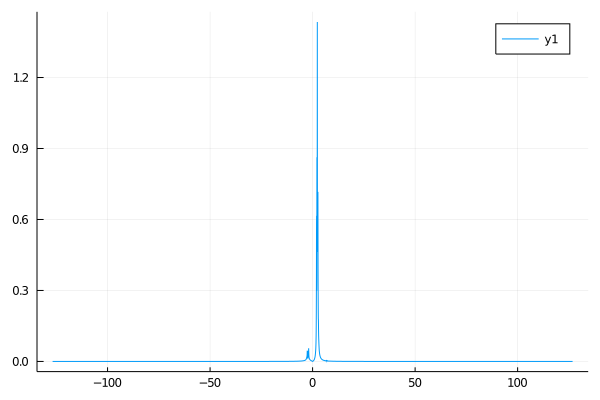

In [1041]:
FouMicMol=ifft(MicAmpMol[:,2])*length(MicAmpMol[:,2])*deltaT

FreqsFFTMol=0.658*fftfreq(length(MicAmpMol[:,2]))*2*pi/deltaT ;#Here we take advantage of the equal size along all dimensions
  
FreqsFFTMol=fftshift(FreqsFFTMol)
FouMicMol=fftshift(FouMicMol);
plot(FreqsFFTMol,abs.(FouMicMol))

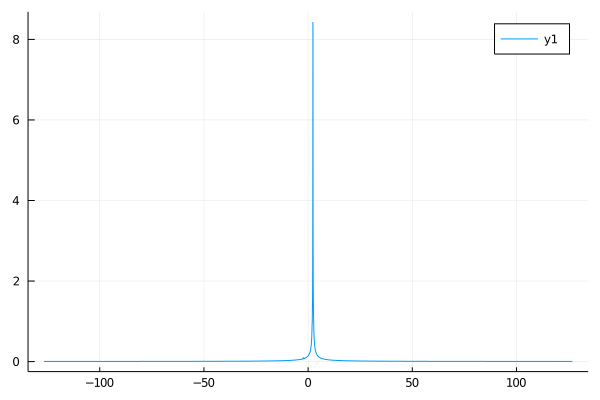

In [1042]:
FouBathMol=ifft(BathAmpMol[:,2])*length(MicAmpMol[:,2])*deltaT
FreqsFFTMol=0.658*fftfreq(length(MicAmpMol[:,2]))*2*pi/deltaT ;#Here we take advantage of the equal size along all dimensions
  
FreqsFFTMol=fftshift(FreqsFFTMol)
FouBathMol=fftshift(FouBathMol);
plot(FreqsFFTMol,abs.(FouBathMol))

In [1043]:
spRMicMol=Spline1D(real(FreqsFFTMol), real(FouMicMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);
spImMicMol=Spline1D(real(FreqsFFTMol),imag(FouMicMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);
spRBathMol=Spline1D(real(FreqsFFTMol), real(FouBathMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);
spImBathMol=Spline1D(real(FreqsFFTMol), imag(FouBathMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);

In [1044]:
#lets consider a range of frequencies for which we know the system-bath coupling constants
FRangeIdx=500:1:700 #WARNING: this is the range of indexes of the frequencies of interest. This must be selected
#such that they cover the frequency of the bath used in our effective model...

Rangepts=length(FRangeIdx)
FRangeIO=Freqs[500:700].^2 *CovToEv/2 #Freqs in eVs!!! These parameters are already defined in the molecular-free
#section

#calculation "by hand" of the IO scattering matrix for each frequency
SIO_NumMol=zeros(ComplexF64,(2,2,Rangepts))

for i in 1:Rangepts
   #retrieve the system-bath coupling for each frequency, as well as the relative phase between the degenerate modes
    #conversion to sqrt(eV), those are the units of this guy...
    CoupLeft=sqrt(CovToEv)*HSB[1,1,FRangeIdx[i]] #left
    CoupRight=sqrt(CovToEv)*HSB[2,1,FRangeIdx[i]]; #right

    PsiLeft=angle(CoupLeft)
    PsiRight=angle(CoupRight)
    
    ELR=exp(-im*(PsiLeft-PsiRight)) #difference in phases of couplings
    AuxRatio=abs(CoupRight)/abs(CoupLeft)
    #ratio of bath and microcavity amplitudes...We assume that the bath that drives the system is always from the left
    #such that the we can scale that result appropiately to get the corresponding result for the right bath
    Ratio=(evaluate(spRMicMol,FRangeIO[i])+im*evaluate(spImMicMol,FRangeIO[i]))/(evaluate(spRBathMol,FRangeIO[i])+im*evaluate(spImBathMol,FRangeIO[i]))
    
    SIO_NumMol[1,1,i]=1-2*pi*im*abs(CoupLeft)*Ratio
    SIO_NumMol[1,2,i]=-2*pi*im*abs(CoupLeft)*AuxRatio*ELR*Ratio
    SIO_NumMol[2,1,i]=-2*pi*im*abs(CoupRight)*conj(ELR)*Ratio
    SIO_NumMol[2,2,i]=1-2*pi*im*abs(CoupRight)*AuxRatio*Ratio
    
    
    
end


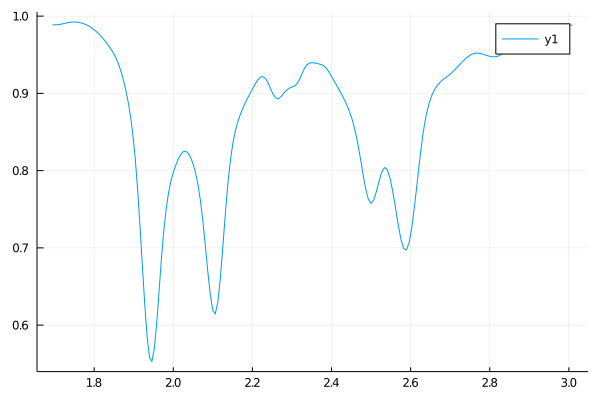

In [1045]:
plot(FRangeIO,abs.(SIO_NumMol[1,1,:]))

In [1046]:
#How does the Total (product of background and I/O scattering matrix) look like?
STot_NumMol=zeros(ComplexF64,(2,2,Rangepts))

for i in 1:Rangepts
    
    STot_NumMol[:,:,i]=*(ScatMats[:,:,FRangeIdx[i]],SIO_NumMol[:,:,i])
    
end

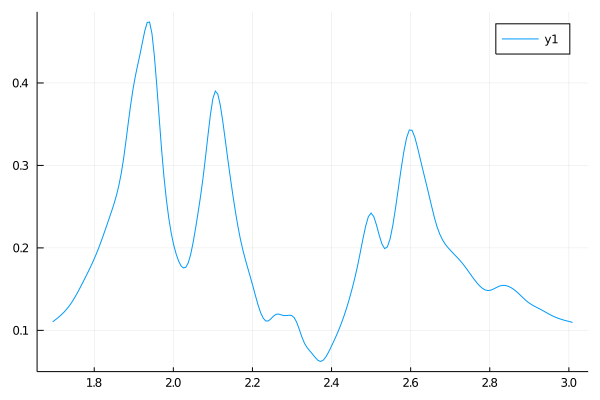

In [1047]:
plot(FRangeIO,abs.(STot_NumMol[1,1,:]))

In [1048]:
#Calculation of the molecular absorption
#Load the data associated to the different wavepackets...
EeV0P0_Exc=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/Multipacket/CrossMaster/EeV0P0Cross_Exc")
EeV0P0_Phot=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/Multipacket/CrossMaster/EeV0P0Cross_Phot")

EeV1P0_Exc=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/Multipacket/CrossMaster/EeV1P0Cross_Exc")
EeV1P0_Phot=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/Multipacket/CrossMaster/EeV1P0Cross_Phot")

EgV0P1_Exc=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/Multipacket/CrossMaster/EgV0P1Cross_Exc")
EgV0P1_Phot=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/Multipacket/CrossMaster/EgV0P1Cross_Phot");

EgV0P0_Exc=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/Multipacket/CrossMaster/EgV0P0Cross_Exc")
EgV0P0_Phot=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/Multipacket/CrossMaster/EgV0P0Cross_Phot");

#I added this to test my hypothesis on the relevance to include phonon-excited, ground-electronic states..
EgV1P0_Exc=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/Multipacket/CrossMaster/EgV1P0Cross_Exc")
EgV1P0_Phot=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/Multipacket/CrossMaster/EgV1P0Cross_Phot");

EgV2P0_Exc=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/Multipacket/CrossMaster/EgV2P0Cross_Exc")
EgV2P0_Phot=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/Multipacket/CrossMaster/EgV2P0Cross_Phot");



Timepts,=size(EeV0P0_Exc)

(7713, 5)

In [1049]:
(Timepts-5000)/2

1356.5

In [1050]:
deltaT*TotPts

125.72189999999999

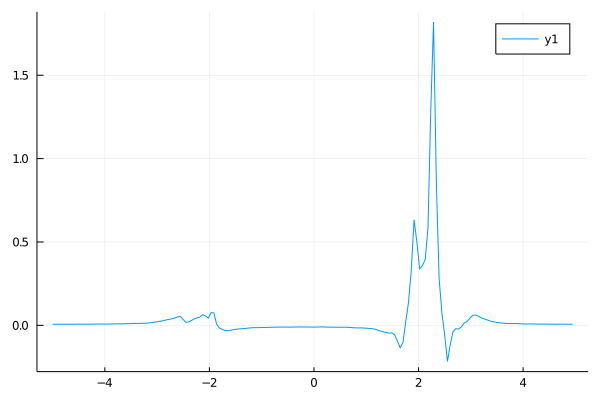

In [1051]:
init=1
endT=Timepts-3000
#endT=Timepts

WRange=10. #Frequency range goes from -WRange/2 to WRange/2, in eV

SampTime=2*pi*0.658/WRange 

#sampling rate in fs
SampRate=Int64(div(2*pi*0.658/WRange,deltaT,RoundDown))

#total number of points:
TotPts=endT-init+1

#number of points to sample:
SampPts=Int64(div(TotPts,SampRate,RoundDown))

Filtered1=zeros(ComplexF64,SampPts)
Filtered2=zeros(ComplexF64,SampPts)
Filtered3=zeros(ComplexF64,SampPts)
Filtered4=zeros(ComplexF64,SampPts)
Filtered5=zeros(ComplexF64,SampPts)
Filtered6=zeros(ComplexF64,SampPts)
Filtered7=zeros(ComplexF64,SampPts)
Filtered8=zeros(ComplexF64,SampPts)

Filtered9=zeros(ComplexF64,SampPts)
Filtered10=zeros(ComplexF64,SampPts)
Filtered11=zeros(ComplexF64,SampPts)
Filtered12=zeros(ComplexF64,SampPts)

for i in 1:SampPts
    Filtered1[i]=conj(EgV0P1_Phot[init+i*SampRate-1,2]+im*EgV0P1_Phot[init+i*SampRate-1,3])
    Filtered2[i]=EgV0P1_Exc[init+i*SampRate-1,2]+im*EgV0P1_Exc[init+i*SampRate-1,3]

    #excited electronic, zero phonon, zero photon
    Filtered3[i]=conj(EeV1P0_Phot[init+i*SampRate-1,2]+im*EeV1P0_Phot[init+i*SampRate-1,3])
    Filtered4[i]=EeV1P0_Exc[init+i*SampRate-1,2]+im*EeV1P0_Exc[init+i*SampRate-1,3]

    #excited electronic, one phonon, zero photon
    Filtered5[i]=conj(EeV0P0_Phot[init+i*SampRate-1,2]+im*EeV0P0_Phot[init+i*SampRate-1,3])
    Filtered6[i]=EeV0P0_Exc[init+i*SampRate-1,2]+im*EeV0P0_Exc[init+i*SampRate-1,3]
    
    Filtered7[i]=conj(EgV0P0_Phot[init+i*SampRate-1,2]+im*EgV0P0_Phot[init+i*SampRate-1,3])
    Filtered8[i]=EgV0P0_Exc[init+i*SampRate-1,2]+im*EgV0P0_Exc[init+i*SampRate-1,3]

    Filtered9[i]=conj(EgV1P0_Phot[init+i*SampRate-1,2]+im*EgV1P0_Phot[init+i*SampRate-1,3])
    Filtered10[i]=EgV1P0_Exc[init+i*SampRate-1,2]+im*EgV1P0_Exc[init+i*SampRate-1,3]
    
    Filtered11[i]=conj(EgV2P0_Phot[init+i*SampRate-1,2]+im*EgV2P0_Phot[init+i*SampRate-1,3])
    Filtered12[i]=EgV2P0_Exc[init+i*SampRate-1,2]+im*EgV2P0_Exc[init+i*SampRate-1,3]
    
   
    
end


###*******


#Application of filter
for i in 1:length(Filtered1)
    Filtered1[i]=Filtered1[i]*cos(pi*i/(2*length(Filtered1[:,1])))
    Filtered2[i]=Filtered2[i]*cos(pi*i/(2*length(Filtered2[:,1])))
    
    Filtered3[i]=Filtered3[i]*cos(pi*i/(2*length(Filtered3[:,1])))
    Filtered4[i]=Filtered4[i]*cos(pi*i/(2*length(Filtered4[:,1])))
    
    Filtered5[i]=Filtered5[i]*cos(pi*i/(2*length(Filtered5[:,1])))
    Filtered6[i]=Filtered6[i]*cos(pi*i/(2*length(Filtered6[:,1])))
    
    Filtered7[i]=Filtered7[i]*cos(pi*i/(2*length(Filtered7[:,1])))
    Filtered8[i]=Filtered8[i]*cos(pi*i/(2*length(Filtered8[:,1])))
    
    Filtered9[i]=Filtered9[i]*cos(pi*i/(2*length(Filtered9[:,1])))
    Filtered10[i]=Filtered10[i]*cos(pi*i/(2*length(Filtered10[:,1])))
    
    Filtered11[i]=Filtered11[i]*cos(pi*i/(2*length(Filtered11[:,1])))
    Filtered12[i]=Filtered12[i]*cos(pi*i/(2*length(Filtered12[:,1])))
    
    
    
end



FreqsTest=0.658*fftfreq(length(Filtered1[:,1]))*2*pi/SampTime

#FouTest=ifft(Exc0Vib0PhotCross_Exc[:,2]+im*Exc0Vib0PhotCross_Exc[:,3])
FouTest1=ifft(Filtered1)*deltaT*TotPts/0.658
FouTest2=ifft(Filtered2)*deltaT*TotPts/0.658

FouTest3=ifft(Filtered3)*deltaT*TotPts/0.658
FouTest4=ifft(Filtered4)*deltaT*TotPts/0.658

FouTest5=ifft(Filtered5)*deltaT*TotPts/0.658
FouTest6=ifft(Filtered6)*deltaT*TotPts/0.658

FouTest7=ifft(Filtered7)*deltaT*TotPts/0.658
FouTest8=ifft(Filtered8)*deltaT*TotPts/0.658

FouTest9=ifft(Filtered9)*deltaT*TotPts/0.658
FouTest10=ifft(Filtered10)*deltaT*TotPts/0.658

FouTest11=ifft(Filtered11)*deltaT*TotPts/0.658
FouTest12=ifft(Filtered12)*deltaT*TotPts/0.658


#****
#l=3855
#for i in 1:length(FouTest)
#    FouTest[i]=exp(im*l*FreqsTest[i])*FouTest[i]
#end

#****


FreqsTest=fftshift(FreqsTest)
FouTest1=fftshift(FouTest1);
FouTest2=fftshift(FouTest2);

FouTest3=fftshift(FouTest3);
FouTest4=fftshift(FouTest4);

FouTest5=fftshift(FouTest5);
FouTest6=fftshift(FouTest6);

FouTest7=fftshift(FouTest7)
FouTest8=fftshift(FouTest8);

FouTest9=fftshift(FouTest9)
FouTest10=fftshift(FouTest10);

FouTest11=fftshift(FouTest11)
FouTest12=fftshift(FouTest12);



Product1=conj(FouTest1).*FouTest2

Product2=conj(FouTest3).*FouTest4

Product3=conj(FouTest5).*FouTest6

Product4=conj(FouTest7).*FouTest8

Product5=conj(FouTest9).*FouTest10

Product6=conj(FouTest11).*FouTest12

#plot(FreqsTest[2300:2500],(imag(Product[2300:2500])))
#plot(FreqsTest[3850:4000],imag(Product1[3850:4000]))
#plot!(FreqsTest[3850:4000],imag(Product2[3850:4000]))
#plot!(FreqsTest[3850:4000],imag(Product3[3850:4000]))

#plot(FreqsTest[3850:4000],-(imag(Product3[3850:4000])+imag(Product2[3850:4000]+imag(Product1[3850:4000]))))

plot(FreqsTest,-(imag(Product4)+imag(Product3)+imag(Product2)+imag(Product1)))

#plot(FreqsTest[3850:4000],(real(Product3[3850:4000])+real(Product2[3850:4000]+real(Product1[3850:4000]))))

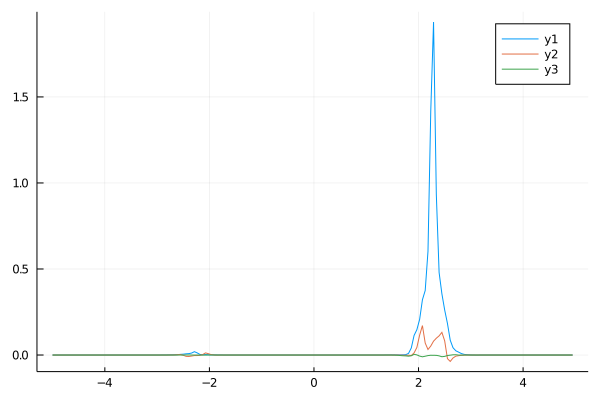

In [1052]:
#plot(FreqsTest,-imag(Product3))
plot(FreqsTest,-imag(Product4))
plot!(FreqsTest,-imag(Product5))
plot!(FreqsTest,-imag(Product6))

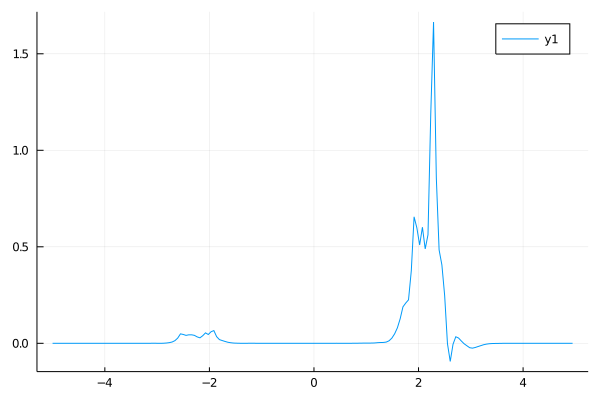

In [1053]:
TotalAbs=-(imag(Product4)+imag(Product3)+imag(Product5)+imag(Product6))

plot(FreqsTest,TotalAbs)

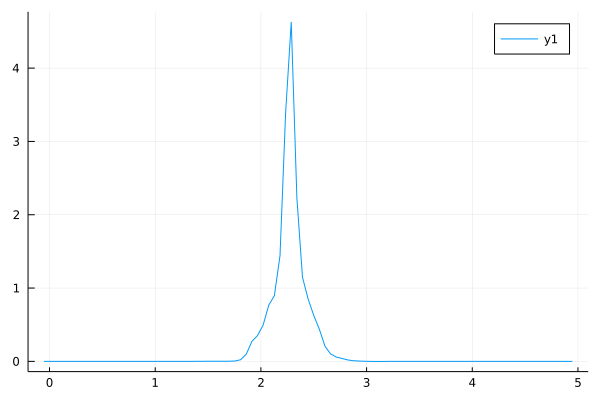

In [1054]:
#TODO: iso;late the contributions to first order in system-bath photon coupling...

#TotalAbs=-(imag(Product4)+imag(Product3))

TotalAbs=-(imag(Product4))*2*sqrt(2)*0.4*(2.314-0.2)

plot(FreqsTest[94:188],TotalAbs[94:188])

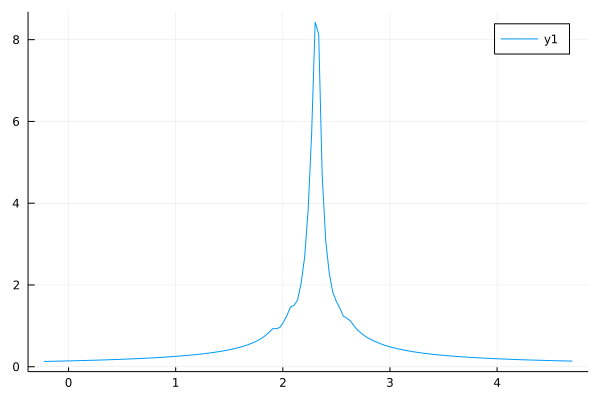

In [1055]:
plot(FreqsFFTMol[3850:4000],abs.(FouBathMol[3850:4000]))

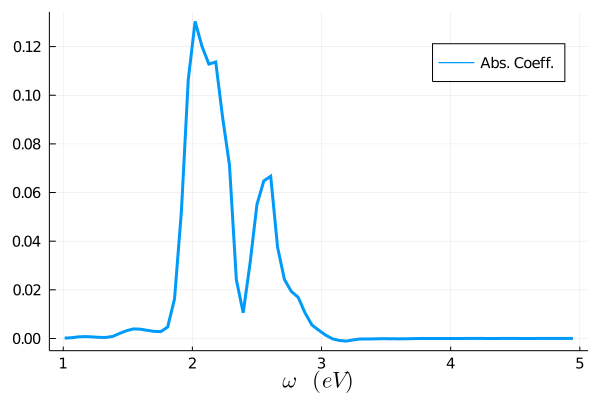

In [1056]:
spInput=Spline1D(FreqsFFTMol[3850:4000], abs.(FouBathMol[3850:4000]).^2; w=ones(length(FreqsFFTMol[3850:4000])),
    k=3, bc="nearest", s=0.0);

NormAbs=zeros(Float64,length(FreqsTest[94:188]))


for i in 1:length(FreqsTest[94:188])
    
    NormAbs[i]=TotalAbs[94+i-1]/(FreqsTest[94+i-1]*(evaluate(spInput,FreqsTest[94+i-1])/0.658))
    #NormAbs[i]=TotalAbs[3920+i-1]/abs(evaluate(spInput,FreqsTest[3920+i-1]))
    
end

#spNormAbs=Spline1D(FreqsTest[94:188], NormAbs; w=ones(length(FreqsTest[94:188])),
#    k=3, bc="nearest", s=0.0);






plot(FreqsTest[114:188],NormAbs[20:length(NormAbs)-1],linewidth=3,xlabel=L"\omega\quad (eV)",
   xtickfont=10, ytickfont=10,guidefontsize=15,label="Abs. Coeff.",legendfontsize=10,legend=(0.8,0.85))

#savefig("Abs_strong1mol.pdf")

In [1057]:
spAbs=Spline1D(FreqsTest[114:188], NormAbs[20:length(NormAbs)-1]; w=ones(length(FreqsTest[114:188])), k=3, bc="nearest", s=0.0)

AdjustedAbsStrong1Mol=zeros(Float64,length(FRangeIO))

for i in 1:length(FRangeIO)
    
    AdjustedAbsStrong1Mol[i]= evaluate(spAbs,FRangeIO[i])
    
end

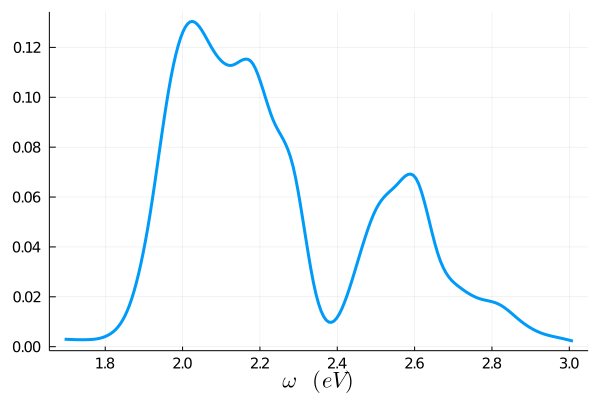

In [1058]:
plot(FRangeIO,AdjustedAbsStrong1Mol,linewidth=3,xlabel=L"\omega\quad (eV)",
   xtickfont=10, ytickfont=10,guidefontsize=15,label="Abs. Coeff.",legend=false)
#savefig("Abs_strong1mol.pdf")

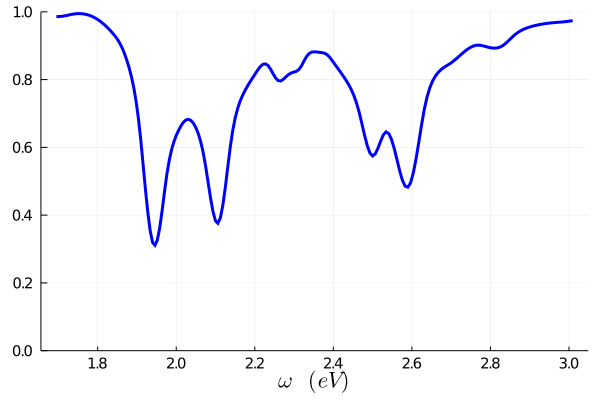

In [1059]:
RefStrong1Mol=zeros(Float64,length(FRangeIO))
for i in 1:length(FRangeIO)
   RefStrong1Mol[i]= abs(STot_NumMol[1,2,i])^2
end



plot(FRangeIO,RefStrong1Mol,linewidth=3,xlabel=L"\omega\quad (eV)",color=:blue,
    xtickfont=10, ytickfont=10,guidefontsize=15,label="R. Coeff.",legend=false,ylims=(0,1))

#plot(FRangeIO,abs.(STot_NumMol[1,2,:]).^2,linewidth=3,xlabel=L"\omega\quad (eV)",color=:blue,
#    xtickfont=10, ytickfont=10,guidefontsize=15,label="R. Coeff.",legend=false,ylims=(0,1))
#savefig("Ref_strong1mol.pdf")


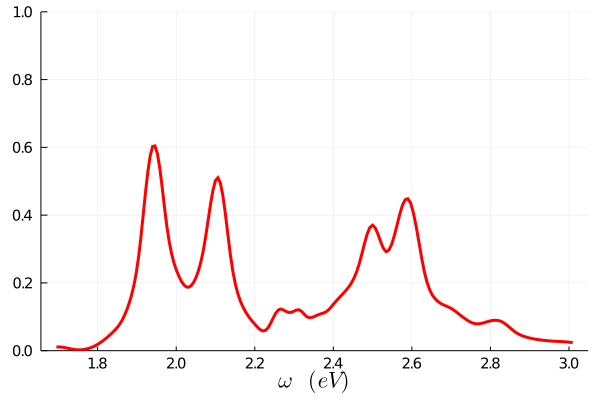

In [1060]:
TransStrong1Mol=zeros(Float64,length(FRangeIO))
for i in 1:length(FRangeIO)
   TransStrong1Mol[i]= 1.0-RefStrong1Mol[i]-AdjustedAbsStrong1Mol[i]
end



plot(FRangeIO,TransStrong1Mol,linewidth=3,xlabel=L"\omega\quad (eV)",color=:red,
    xtickfont=10, ytickfont=10,guidefontsize=15,label="T. Coeff.",legend=false,ylims=(0,1))


#plot(FRangeIO,ones(Float64,length(STot_NumMol[1,1,:]))-abs.(STot_NumMol[1,2,:]).^2-AdjustedAbs,linewidth=3,xlabel=L"\omega\quad (eV)",color=:red,
#    xtickfont=10, ytickfont=10,guidefontsize=15,label="T. Coeff.",legend=false,ylims=(0,1))
#savefig("Trans_strong1mol.pdf")

# 1 Molecule. Stronger coupling, transient absorption

In [51]:
Cross_Phot20=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/20Cross_Phot_Gel_1Cav")
Cross_Exc20=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/20Cross_Exc_Gel_1Cav")

Cross_Phot40=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/40Cross_Phot_Gel_1Cav")
Cross_Exc40=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/40Cross_Exc_Gel_1Cav")

Cross_Phot60=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/60Cross_Phot_Gel_1Cav")
Cross_Exc60=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/60Cross_Exc_Gel_1Cav")

Cross_Phot80=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/80Cross_Phot_Gel_1Cav")
Cross_Exc80=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/80Cross_Exc_Gel_1Cav")

Cross_Phot100=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/100Cross_Phot_Gel_1Cav")
Cross_Exc100=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/100Cross_Exc_Gel_1Cav");

In [52]:
Cross_Phot201V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/20Cross_Phot_GC1V1")
Cross_Exc201V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/20Cross_Exc_GC1V1")

Cross_Phot401V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/40Cross_Phot_GC1V1")
Cross_Exc401V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/40Cross_Exc_GC1V1")

Cross_Phot601V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/60Cross_Phot_GC1V1")
Cross_Exc601V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/60Cross_Exc_GC1V1")

Cross_Phot801V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/80Cross_Phot_GC1V1")
Cross_Exc801V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/80Cross_Exc_GC1V1")

Cross_Phot1001V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/100Cross_Phot_GC1V1")
Cross_Exc1001V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/100Cross_Exc_GC1V1");

In [53]:
Cross_Phot202V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/20Cross_Phot_GC1V2")
Cross_Exc202V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/20Cross_Exc_GC1V2")

Cross_Phot402V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/40Cross_Phot_GC1V2")
Cross_Exc402V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/40Cross_Exc_GC1V2")

Cross_Phot602V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/60Cross_Phot_GC1V2")
Cross_Exc602V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/60Cross_Exc_GC1V2")

Cross_Phot802V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/80Cross_Phot_GC1V2")
Cross_Exc802V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/80Cross_Exc_GC1V2")

Cross_Phot1002V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/100Cross_Phot_GC1V2")
Cross_Exc1002V=readdlm("./MCTDH_Molecular/SmallDiss/1Mol/Strong/NonLinear/CrossMaster/100Cross_Exc_GC1V2");

Timepts,=size(Cross_Phot202V)
deltaT=abs(Cross_Phot202V[1,1]-Cross_Phot202V[2,1])

0.01625

In [54]:
#For ease of data management, we store the all the relevant correlation functions in 2 arrays of length 
#Timepts x number of delay times x number of auxiliary states

init=1
#endT=Timepts-3000
endT=Timepts
DelayN=5
AuxStates=3
TotTSim=deltaT*abs(endT-init+1)

PhotContrib=zeros(ComplexF64,(abs(Timepts-init+1),DelayN,AuxStates));
ExcContrib=zeros(ComplexF64,(abs(Timepts-init+1),DelayN,AuxStates));

FFTPhot=zeros(ComplexF64,(abs(Timepts-init+1),DelayN,AuxStates));
FFTExc=zeros(ComplexF64,(abs(Timepts-init+1),DelayN,AuxStates));

#We store the transient absoprtion spectrum for each of the delay times, and spllit it in the different 
#contributions...
TAbs=zeros(ComplexF64,(abs(Timepts-init+1),DelayN,AuxStates));


In [55]:
#Copying data...
PhotContrib[:,1,1]=conj(Cross_Phot20[init:endT,2]+im*Cross_Phot20[init:endT,3])
PhotContrib[:,2,1]=conj(Cross_Phot40[init:endT,2]+im*Cross_Phot40[init:endT,3])
PhotContrib[:,3,1]=conj(Cross_Phot60[init:endT,2]+im*Cross_Phot60[init:endT,3])
PhotContrib[:,4,1]=conj(Cross_Phot80[init:endT,2]+im*Cross_Phot80[init:endT,3])
PhotContrib[:,5,1]=conj(Cross_Phot100[init:endT,2]+im*Cross_Phot100[init:endT,3])

PhotContrib[:,1,2]=conj(Cross_Phot201V[init:endT,2]+im*Cross_Phot201V[init:endT,3])
PhotContrib[:,2,2]=conj(Cross_Phot401V[init:endT,2]+im*Cross_Phot401V[init:endT,3])
PhotContrib[:,3,2]=conj(Cross_Phot601V[init:endT,2]+im*Cross_Phot601V[init:endT,3])
PhotContrib[:,4,2]=conj(Cross_Phot801V[init:endT,2]+im*Cross_Phot801V[init:endT,3])
PhotContrib[:,5,2]=conj(Cross_Phot1001V[init:endT,2]+im*Cross_Phot1001V[init:endT,3])

PhotContrib[:,1,3]=conj(Cross_Phot202V[init:endT,2]+im*Cross_Phot202V[init:endT,3])
PhotContrib[:,2,3]=conj(Cross_Phot402V[init:endT,2]+im*Cross_Phot402V[init:endT,3])
PhotContrib[:,3,3]=conj(Cross_Phot602V[init:endT,2]+im*Cross_Phot602V[init:endT,3])
PhotContrib[:,4,3]=conj(Cross_Phot802V[init:endT,2]+im*Cross_Phot802V[init:endT,3])
PhotContrib[:,5,3]=conj(Cross_Phot1002V[init:endT,2]+im*Cross_Phot1002V[init:endT,3])


ExcContrib[:,1,1]=Cross_Exc20[init:endT,2]+im*Cross_Exc20[init:endT,3]
ExcContrib[:,2,1]=Cross_Exc40[init:endT,2]+im*Cross_Exc40[init:endT,3]
ExcContrib[:,3,1]=Cross_Exc60[init:endT,2]+im*Cross_Exc60[init:endT,3]
ExcContrib[:,4,1]=Cross_Exc80[init:endT,2]+im*Cross_Exc80[init:endT,3]
ExcContrib[:,5,1]=Cross_Exc100[init:endT,2]+im*Cross_Exc100[init:endT,3]

ExcContrib[:,1,2]=Cross_Exc201V[init:endT,2]+im*Cross_Exc201V[init:endT,3]
ExcContrib[:,2,2]=Cross_Exc401V[init:endT,2]+im*Cross_Exc401V[init:endT,3]
ExcContrib[:,3,2]=Cross_Exc601V[init:endT,2]+im*Cross_Exc601V[init:endT,3]
ExcContrib[:,4,2]=Cross_Exc801V[init:endT,2]+im*Cross_Exc801V[init:endT,3]
ExcContrib[:,5,2]=Cross_Exc1001V[init:endT,2]+im*Cross_Exc1001V[init:endT,3]

ExcContrib[:,1,3]=Cross_Exc202V[init:endT,2]+im*Cross_Exc202V[init:endT,3]
ExcContrib[:,2,3]=Cross_Exc402V[init:endT,2]+im*Cross_Exc402V[init:endT,3]
ExcContrib[:,3,3]=Cross_Exc602V[init:endT,2]+im*Cross_Exc602V[init:endT,3]
ExcContrib[:,4,3]=Cross_Exc802V[init:endT,2]+im*Cross_Exc802V[init:endT,3]
ExcContrib[:,5,3]=Cross_Exc1002V[init:endT,2]+im*Cross_Exc1002V[init:endT,3]



#Application of filter
#for i in 1:length(PhotContrib[:,1,1])
    
#    PhotContrib[i,:,:]=PhotContrib[i,:,:]*cos(pi*i/(2*length(PhotContrib[:,1,1])))
#    ExcContrib[i,:,:]=ExcContrib[i,:,:]*cos(pi*i/(2*length(ExcContrib[:,1,1])))
    
     
    
#end



FreqsTest=0.658*fftfreq(length(PhotContrib[:,1,1]))*2*pi/deltaT

for i in 1:length(PhotContrib[1,:,1]) #loop over the delay times
    
    for j in 1:length(PhotContrib[1,1,:]) #loop pver the contributions...
        FFTPhot[:,i,j]=ifft(PhotContrib[:,i,j])*TotTSim/0.658
        FFTExc[:,i,j]=ifft(ExcContrib[:,i,j])*TotTSim/0.658
        
        FFTPhot[:,i,j]=fftshift(FFTPhot[:,i,j])
        FFTExc[:,i,j]=fftshift(FFTExc[:,i,j])
        
    end
    
end

FreqsTest=fftshift(FreqsTest)



#We wrap up the result...

for i in 1:length(PhotContrib[1,:,1]) #loop over the delay times
    
    for j in 1:length(PhotContrib[1,1,:]) #loop pver the contributions...
        TAbs[:,i,j]=conj(FFTPhot[:,i,j]).*FFTExc[:,i,j]
    end
end



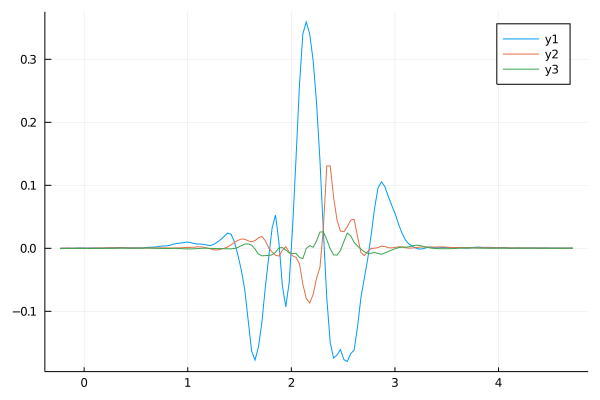

In [56]:
plot(FreqsTest[3850:4000],-imag(TAbs[3850:4000,1,1]))
plot!(FreqsTest[3850:4000],-imag(TAbs[3850:4000,1,2]))
plot!(FreqsTest[3850:4000],-imag(TAbs[3850:4000,1,3]))


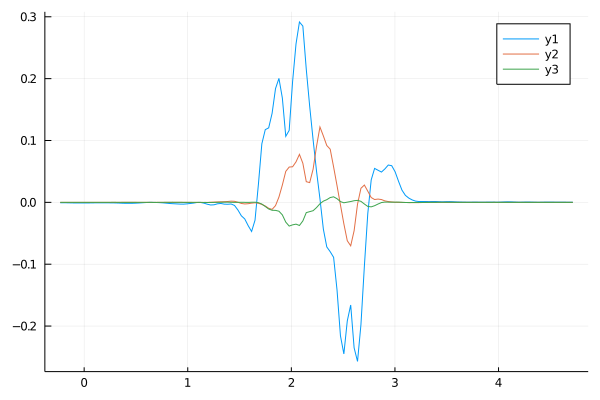

In [57]:
plot(FreqsTest[3850:4000],-imag(TAbs[3850:4000,5,1]))
plot!(FreqsTest[3850:4000],-imag(TAbs[3850:4000,5,2]))
plot!(FreqsTest[3850:4000],-imag(TAbs[3850:4000,5,3]))

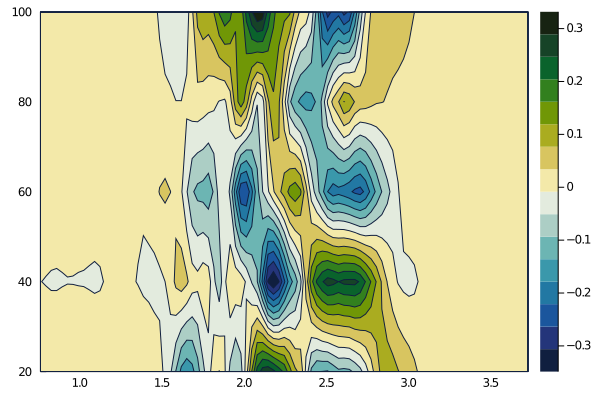

In [65]:
#rearranging data for plotting...
z=zeros(ComplexF64,(abs(endT-init+1),DelayN));

for i in 1:DelayN
    for j in 1:AuxStates
        z[:,i]+=TAbs[:,i,j]
        
    end
    
    
end

#x is the frequencies, y is the delay time...
y=[20.0,40.0, 60.0, 80.0, 100.0]  

#seriescolor=cgrad(ColorSchemes.leonardo.colors)
#contourf(FreqsTest[3900:3950], y, -imag(transpose(z[3900:3950,:])))


#contourf(FreqsTest[3900:3950], y, -imag(transpose(z[3900:3950,:])),seriescolor=cgrad(ColorSchemes.leonardo.colors))
#contourf(FreqsTest[3910:3940], y, -imag(transpose(z[3910:3940,:])),c=:cork)
contourf(FreqsTest[3880:3970], y, -imag(transpose(z[3880:3970,:])),c=:delta)


# 2 Molecules. Weak coupling

In [1621]:
#In contrast to the one molecule case, here we use two files, simply 'cause I forgot to include the
#calculation of expectation values during the propagation...
AmpDum1=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/E1V00P0/AnhL_expectJul"); 
AmpDum2=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/E1V00P0/AhnRC_expectJul");

Timepts,columns=size(AmpDum1)

#Due to limitations in the MCTDH code, I need to formulate the problem in atomic units. To 
#define the dimensionless annhilitation operator a, we scale the time-dependent coordinate and 
#position derivatives and sum them appropietly:

#conversion of eV to atomic units...
#wcAt=wc*ConvEvToFreq
#dampAt=0.00736/2
#dampAt=0.0


#For purposes of simplicity in data handling, we define the next array:
MicAmpMol=zeros(ComplexF64,(Timepts,2))
#MicAmpC=zeros(ComplexF64,(Timepts,3))
BathAmpMol=zeros(ComplexF64,(Timepts,2))

#TotExc=zeros(ComplexF64,(Timepts,2))

#BrightExc=zeros(ComplexF64,(Timepts,2))

#DarkExc=zeros(ComplexF64,(Timepts,2))

#InterCoh=zeros(ComplexF64,(Timepts,2))

for i in 1:Timepts
    scale=sqrt(AmpDum2[i,4]) #norm of the wavefunction. We need to scale each of expectation values computed by MCTDH
    #scale=1.0 #For the simulation of this driven oscillator, we need this scaling factor equal 
    #because the program computes the expectation value over the norm of the wavefunction
    
    MicAmpMol[i,1]=AmpDum2[i,1] #Time coordinate
    MicAmpMol[i,2]=AmpDum2[i,2]*scale #real part of coordinate
    MicAmpMol[i,2]+=im*AmpDum2[i,3]*scale
    
       
    BathAmpMol[i,1]=AmpDum1[i,1] #Time coordinate
    BathAmpMol[i,2]=AmpDum1[i,2]*scale #real part of coordinate
    BathAmpMol[i,2]+=im*AmpDum1[i,3]*scale
    
    #TotExc[i,1]=AmpDum[i,1]
    #TotExc[i,2]=AmpDum[i,7]*scale
    #TotExc[i,2]+=im*AmpDum[i,8]*scale
    
    #BrightExc[i,1]=AmpDum[i,1]
    #BrightExc[i,2]=AmpDum[i,11]*scale
    #BrightExc[i,2]+=im*AmpDum[i,12]*scale
    
    #DarkExc[i,1]=AmpDum[i,1]
    #DarkExc[i,2]=AmpDum[i,13]*scale
    #DarkExc[i,2]+=im*AmpDum[i,14]*scale
    
    #InterCoh[i,1]=AmpDum[i,1]
    #InterCoh[i,2]=AmpDum[i,15]*scale
    #InterCoh[i,2]+=im*AmpDum[i,16]*scale
   
    
    
end




deltaT=abs(MicAmpMol[1,1]-MicAmpMol[2,1]);
Ttime=abs(MicAmpMol[1,1]-MicAmpMol[Timepts,1]) #This is the total time of the simulation, in fs!!



125.32

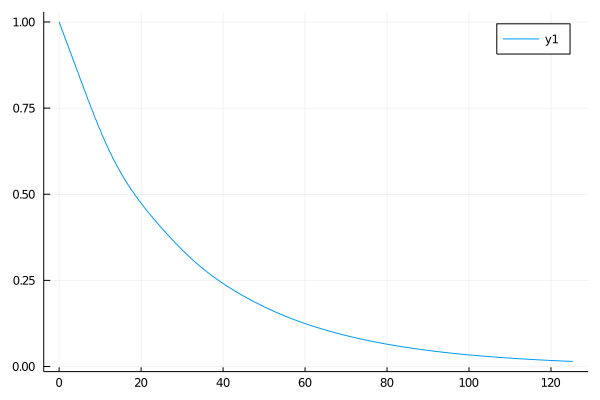

In [1622]:
plot(real(MicAmpMol[:,1]),abs.(AmpDum[:,2]))

In [1623]:
7713/2

3856.5

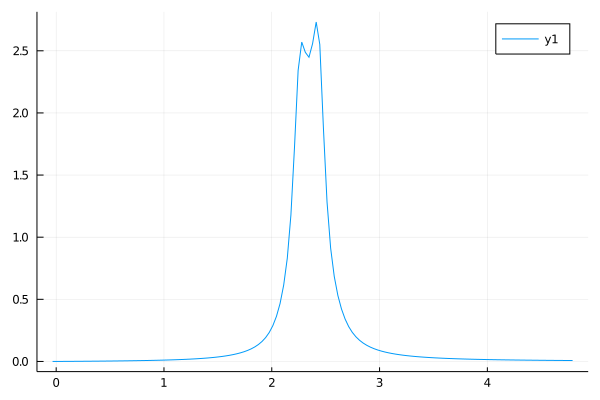

In [1624]:
FouMicMol=ifft(MicAmpMol[:,2])*length(MicAmpMol[:,2])*deltaT

FreqsFFTMol=0.658*fftfreq(length(MicAmpMol[:,2]))*2*pi/deltaT ;#Here we take advantage of the equal size along all dimensions
  
FreqsFFTMol=fftshift(FreqsFFTMol)
FouMicMol=fftshift(FouMicMol);
plot(FreqsFFTMol[3856:4000],abs.(FouMicMol[3856:4000]))

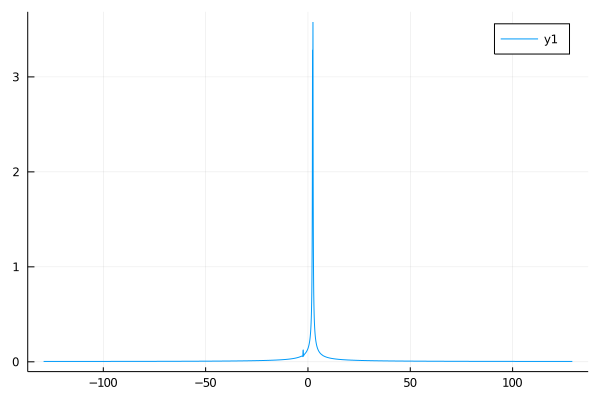

In [1625]:
FouBathMol=ifft(BathAmpMol[:,2])*length(MicAmpMol[:,2])*deltaT
FreqsFFTMol=0.658*fftfreq(length(MicAmpMol[:,2]))*2*pi/deltaT ;#Here we take advantage of the equal size along all dimensions
  
FreqsFFTMol=fftshift(FreqsFFTMol)
FouBathMol=fftshift(FouBathMol);
plot(FreqsFFTMol,abs.(FouBathMol))

In [1626]:
spRMicMol=Spline1D(real(FreqsFFTMol), real(FouMicMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);
spImMicMol=Spline1D(real(FreqsFFTMol),imag(FouMicMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);
spRBathMol=Spline1D(real(FreqsFFTMol), real(FouBathMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);
spImBathMol=Spline1D(real(FreqsFFTMol), imag(FouBathMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);

In [1627]:
#lets consider a range of frequencies for which we know the system-bath coupling constants
FRangeIdx=500:1:700 #WARNING: this is the range of indexes of the frequencies of interest. This must be selected
#such that they cover the frequency of the bath used in our effective model...

Rangepts=length(FRangeIdx)
FRangeIO=Freqs[500:700].^2 *CovToEv/2 #Freqs in eVs!!! These parameters are already defined in the molecular-free
#section

#calculation "by hand" of the IO scattering matrix for each frequency
SIO_NumMol=zeros(ComplexF64,(2,2,Rangepts))

for i in 1:Rangepts
   #retrieve the system-bath coupling for each frequency, as well as the relative phase between the degenerate modes
    #conversion to sqrt(eV), those are the units of this guy...
    CoupLeft=sqrt(CovToEv)*HSB[1,1,FRangeIdx[i]] #left
    CoupRight=sqrt(CovToEv)*HSB[2,1,FRangeIdx[i]]; #right

    PsiLeft=angle(CoupLeft)
    PsiRight=angle(CoupRight)
    
    ELR=exp(-im*(PsiLeft-PsiRight)) #difference in phases of couplings
    AuxRatio=abs(CoupRight)/abs(CoupLeft)
    #ratio of bath and microcavity amplitudes...We assume that the bath that drives the system is always from the left
    #such that the we can scale that result appropiately to get the corresponding result for the right bath
    Ratio=(evaluate(spRMicMol,FRangeIO[i])+im*evaluate(spImMicMol,FRangeIO[i]))/(evaluate(spRBathMol,FRangeIO[i])+im*evaluate(spImBathMol,FRangeIO[i]))
    
    SIO_NumMol[1,1,i]=1-2*pi*im*abs(CoupLeft)*Ratio
    SIO_NumMol[1,2,i]=-2*pi*im*abs(CoupLeft)*AuxRatio*ELR*Ratio
    SIO_NumMol[2,1,i]=-2*pi*im*abs(CoupRight)*conj(ELR)*Ratio
    SIO_NumMol[2,2,i]=1-2*pi*im*abs(CoupRight)*AuxRatio*Ratio
    
    
    
end


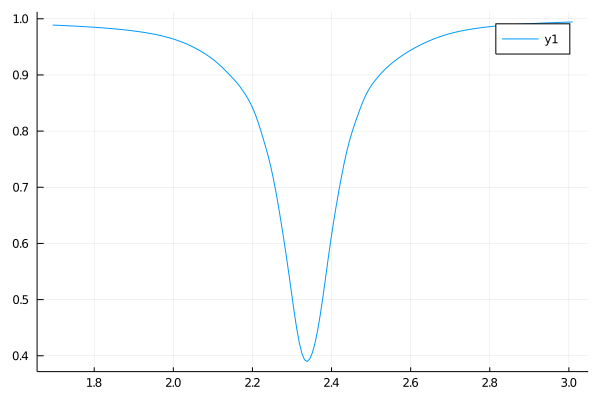

In [1628]:
plot(FRangeIO,abs.(SIO_NumMol[1,1,:]))

In [1629]:
STot_NumMol=zeros(ComplexF64,(2,2,Rangepts))

for i in 1:Rangepts
    
    STot_NumMol[:,:,i]=*(ScatMats[:,:,FRangeIdx[i]],SIO_NumMol[:,:,i])
    
end

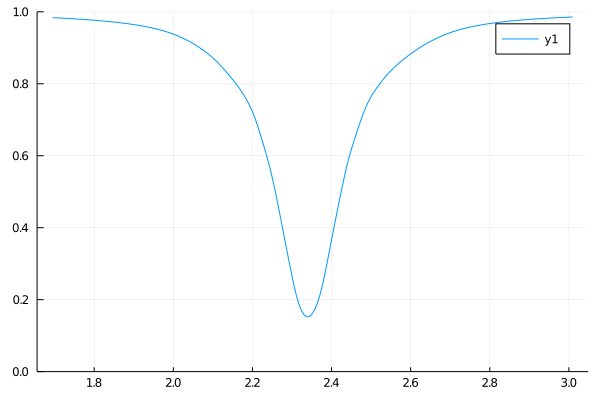

In [1630]:
plot(FRangeIO,abs.(STot_NumMol[1,2,:]).^2,ylims=(0,1))

In [1631]:
#Calculation of the molecular absorption
#Load the data associated to the different wavepackets...
E1V00P1Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMaster/E1V00P1Cross_Exc")
E1V00P1Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMaster/E1V00P1Cross_Phot")

E1V01P1Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMaster/E1V01P1Cross_Exc")
E1V01P1Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMaster/E1V01P1Cross_Phot")

E1V10P1Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMaster/E1V10P1Cross_Exc")
E1V10P1Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMaster/E1V10P1Cross_Phot");

E2V00P0Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMaster/E2V00P0Cross_Exc")
E2V00P0Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMaster/E2V00P0Cross_Phot");

E3V00P0Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMaster/E3V00P0Cross_Exc")
E3V00P0Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMaster/E3V00P0Cross_Phot");

E1V00P0Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMaster/E1V00P0Cross_Exc")
E1V00P0Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMaster/E1V00P0Cross_Phot")





Timepts,=size(E1V00P1Cross_Exc)

(7713, 5)

In [1632]:
init=1
#endT=Timepts-3000
endT=Timepts

WRange=10 #Frequency range goes from -WRange/2 to WRange/2, in eV

SampTime=2*pi*0.658/WRange 

#sampling rate in fs
SampRate=Int64(div(2*pi*0.658/WRange,deltaT,RoundDown))

#total number of points:
TotPts=endT-init+1

#number of points to sample:
SampPts=Int64(div(TotPts,SampRate,RoundDown))

Filtered1=zeros(ComplexF64,SampPts)
Filtered2=zeros(ComplexF64,SampPts)
Filtered3=zeros(ComplexF64,SampPts)
Filtered4=zeros(ComplexF64,SampPts)
Filtered5=zeros(ComplexF64,SampPts)
Filtered6=zeros(ComplexF64,SampPts)
Filtered7=zeros(ComplexF64,SampPts)
Filtered8=zeros(ComplexF64,SampPts)
Filtered9=zeros(ComplexF64,SampPts)
Filtered10=zeros(ComplexF64,SampPts)
Filtered11=zeros(ComplexF64,SampPts)
Filtered12=zeros(ComplexF64,SampPts)

for i in 1:SampPts
    Filtered1[i]=conj(E1V00P1Cross_Phot[init+i*SampRate-1,2]+im*E1V00P1Cross_Phot[init+i*SampRate-1,3])
    Filtered2[i]=E1V00P1Cross_Exc[init+i*SampRate-1,2]+im*E1V00P1Cross_Exc[init+i*SampRate-1,3]

    Filtered3[i]=conj(E1V01P1Cross_Phot[init+i*SampRate-1,2]+im*E1V01P1Cross_Phot[init+i*SampRate-1,3])
    Filtered4[i]=E1V01P1Cross_Exc[init+i*SampRate-1,2]+im*E1V01P1Cross_Exc[init+i*SampRate-1,3]

    Filtered5[i]=conj(E1V10P1Cross_Phot[init+i*SampRate-1,2]+im*E1V10P1Cross_Phot[init+i*SampRate-1,3])
    Filtered6[i]=E1V10P1Cross_Exc[init+i*SampRate-1,2]+im*E1V10P1Cross_Exc[init+i*SampRate-1,3]

    Filtered7[i]=conj(E2V00P0Cross_Phot[init+i*SampRate-1,2]+im*E2V00P0Cross_Phot[init+i*SampRate-1,3])
    Filtered8[i]=E2V00P0Cross_Exc[init+i*SampRate-1,2]+im*E2V00P0Cross_Exc[init+i*SampRate-1,3]

    Filtered9[i]=conj(E3V00P0Cross_Phot[init+i*SampRate-1,2]+im*E3V00P0Cross_Phot[init+i*SampRate-1,3])
    Filtered10[i]=E3V00P0Cross_Exc[init+i*SampRate-1,2]+im*E3V00P0Cross_Exc[init+i*SampRate-1,3]

    Filtered11[i]=conj(E1V00P0Cross_Phot[init+i*SampRate-1,2]+im*E1V00P0Cross_Phot[init+i*SampRate-1,3])
    Filtered12[i]=E1V00P0Cross_Exc[init+i*SampRate-1,2]+im*E1V00P0Cross_Exc[init+i*SampRate-1,3]
    
    
    
    
end

#Application of filter
for i in 1:length(Filtered1)
    Filtered1[i]=Filtered1[i]*cos(pi*i/(2*length(Filtered1[:,1])))
    Filtered2[i]=Filtered2[i]*cos(pi*i/(2*length(Filtered2[:,1])))
    
    Filtered3[i]=Filtered3[i]*cos(pi*i/(2*length(Filtered3[:,1])))
    Filtered4[i]=Filtered4[i]*cos(pi*i/(2*length(Filtered4[:,1])))
    
    Filtered5[i]=Filtered5[i]*cos(pi*i/(2*length(Filtered5[:,1])))
    Filtered6[i]=Filtered6[i]*cos(pi*i/(2*length(Filtered6[:,1])))
    
    Filtered7[i]=Filtered7[i]*cos(pi*i/(2*length(Filtered7[:,1])))
    Filtered8[i]=Filtered8[i]*cos(pi*i/(2*length(Filtered8[:,1])))
    
    Filtered9[i]=Filtered9[i]*cos(pi*i/(2*length(Filtered9[:,1])))
    Filtered10[i]=Filtered10[i]*cos(pi*i/(2*length(Filtered10[:,1])))
    
    Filtered11[i]=Filtered11[i]*cos(pi*i/(2*length(Filtered11[:,1])))
    Filtered12[i]=Filtered12[i]*cos(pi*i/(2*length(Filtered12[:,1])))
    
    
    
end



FreqsTest=0.658*fftfreq(length(Filtered1[:,1]))*2*pi/SampTime

#FouTest=ifft(Exc0Vib0PhotCross_Exc[:,2]+im*Exc0Vib0PhotCross_Exc[:,3])
FouTest1=ifft(Filtered1)*TotPts*deltaT/0.658
FouTest2=ifft(Filtered2)*TotPts*deltaT/0.658

FouTest3=ifft(Filtered3)*TotPts*deltaT/0.658
FouTest4=ifft(Filtered4)*TotPts*deltaT/0.658

FouTest5=ifft(Filtered5)*TotPts*deltaT/0.658
FouTest6=ifft(Filtered6)*TotPts*deltaT/0.658

FouTest7=ifft(Filtered7)*TotPts*deltaT/0.658
FouTest8=ifft(Filtered8)*TotPts*deltaT/0.658

FouTest9=ifft(Filtered9)*TotPts*deltaT/0.658
FouTest10=ifft(Filtered10)*TotPts*deltaT/0.658

FouTest11=ifft(Filtered11)*TotPts*deltaT/0.658
FouTest12=ifft(Filtered12)*TotPts*deltaT/0.658


#****
#l=3855
#for i in 1:length(FouTest)
#    FouTest[i]=exp(im*l*FreqsTest[i])*FouTest[i]
#end

#****


FreqsTest=fftshift(FreqsTest)
FouTest1=fftshift(FouTest1);
FouTest2=fftshift(FouTest2);

FouTest3=fftshift(FouTest3);
FouTest4=fftshift(FouTest4);

FouTest5=fftshift(FouTest5);
FouTest6=fftshift(FouTest6);

FouTest7=fftshift(FouTest7)
FouTest8=fftshift(FouTest8);

FouTest9=fftshift(FouTest9)
FouTest10=fftshift(FouTest10);

FouTest11=fftshift(FouTest11)
FouTest12=fftshift(FouTest12);


Product1=conj(FouTest1).*FouTest2

Product2=conj(FouTest3).*FouTest4

Product3=conj(FouTest5).*FouTest6

Product4=conj(FouTest7).*FouTest8

Product5=conj(FouTest9).*FouTest10

Product6=conj(FouTest11).*FouTest12;

#plot(FreqsTest[2300:2500],(imag(Product[2300:2500])))
#plot(FreqsTest[3850:4000],imag(Product1[3850:4000]))
#plot!(FreqsTest[3850:4000],imag(Product2[3850:4000]))
#plot!(FreqsTest[3850:4000],imag(Product3[3850:4000]))

#plot(FreqsTest[3850:4000],-(imag(Product3[3850:4000])+imag(Product2[3850:4000]+imag(Product1[3850:4000]))))

#plot(FreqsTest[2350:2500],-(imag(Product5[2350:2500])+imag(Product4[2350:2500])+imag(Product3[2350:2500])+imag(Product2[2350:2500]+imag(Product1[2350:2500]))))

#plot(FreqsTest[3850:4000],(real(Product3[3850:4000])+real(Product2[3850:4000]+real(Product1[3850:4000]))))

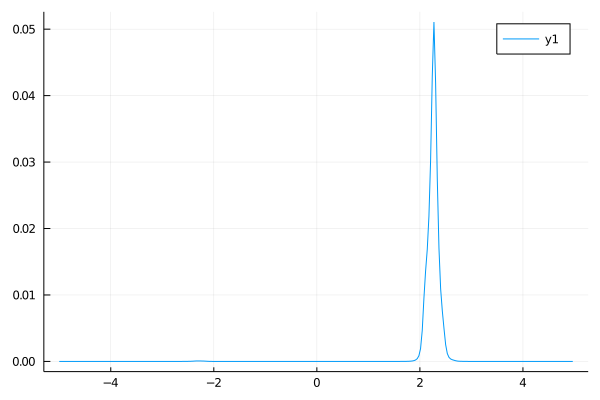

In [1633]:
#TotalAbs=-(imag(Product4)+imag(Product5)+imag(Product6))*2*sqrt(2)*0.0141*(2.314-0.2) #the factor 0.0141 comes from
                                                                                    #0.02/sqrt(2).  The
                                                                                    #correlation functions for the 
                                                                            #polarization are not scaled 
                                                                            #by 1/sqrt(N), where N is teh number of molecules

#TotalAbs=-(imag(Product4)+imag(Product5))
TotalAbs=-(imag(Product6))*2*sqrt(2)*0.0141*(2.314-0.2)
plot(FreqsTest,TotalAbs)

In [1634]:
AbsCorrExcWeak2Mol=zeros(ComplexF64,length(E1V00P0Cross_Exc[:,2]))
AbsCorrPhotWeak2Mol=zeros(ComplexF64,length(E1V00P0Cross_Phot[:,2]))

for i in 1:length(E1V00P0Cross_Exc[:,2])
    AbsCorrExcWeak2Mol[i]=E1V00P0Cross_Exc[i,2]+im*E1V00P0Cross_Exc[i,3]
    AbsCorrPhotWeak2Mol[i]=E1V00P0Cross_Phot[i,2]+im*E1V00P0Cross_Phot[i,3]
end

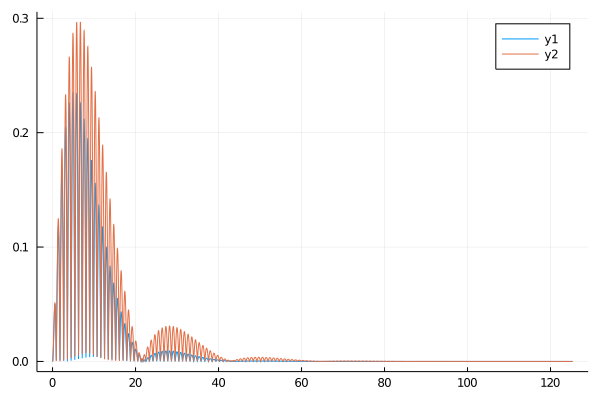

In [1635]:
plot(real(MicAmpMol[:,1]),abs.(AbsCorrPhotWeak2Mol))
plot!(real(MicAmpMol[:,1]),abs.(AbsCorrPhotWeak1Mol))

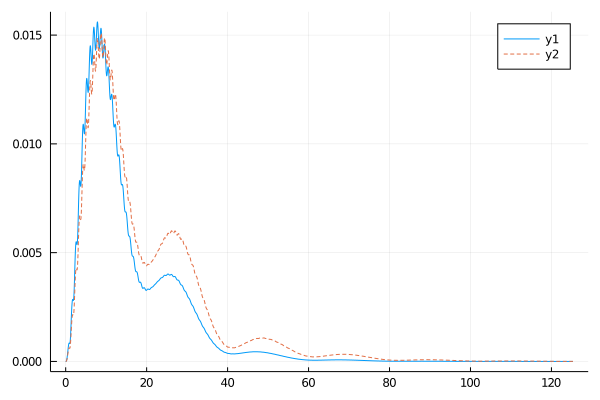

In [1636]:
plot(real(MicAmpMol[:,1]),abs.(AbsCorrExcWeak2Mol))
plot!(real(MicAmpMol[:,1]),abs.(AbsCorrWeak1Mol),linestyle=:dash)

In [1637]:
FouBathMolWeak2Mol=zeros(ComplexF64,length(FreqsFFTMol[3850:4000]))
for i in 1:length(FouBathMolWeak2Mol)
        FouBathMolWeak2Mol[i]=FouBathMol[i+3850]
end


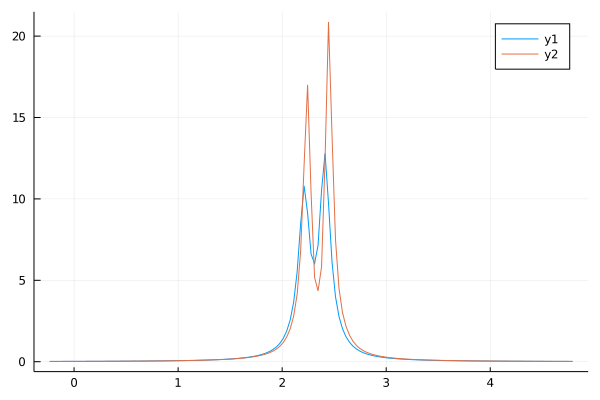

In [1642]:
plot(FreqsFFTMol[3850:4000],abs.(FouBathMolWeak2Mol).^2)
plot!(FreqsFFTMol[3850:4000],abs.(FouBathMolWeak1Mol).^2)

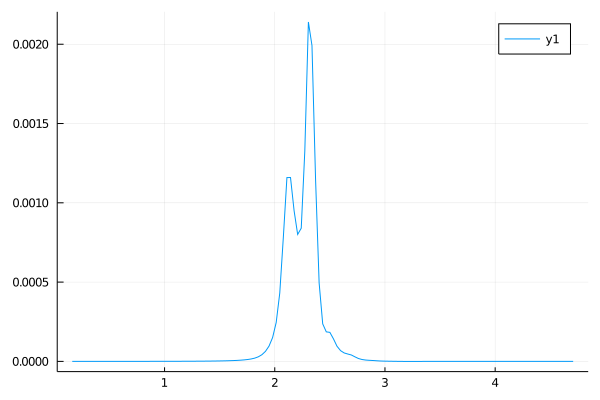

In [1639]:
#spInput=Spline1D(FreqsFFTMol[3850:4000], abs.(FouBathMol[3850:4000]).^2; w=ones(length(FreqsFFTMol[3850:4000])),
#    k=3, bc="nearest", s=0.0);
spInput=Spline1D(FreqsFFTMol[3850:4000], abs.(FouBathMolWeak2Mol).^2; w=ones(length(FreqsFFTMol[3850:4000])),
    k=3, bc="nearest", s=0.0);

NormAbs=zeros(Float64,length(FreqsTest[150:300]))


for i in 1:length(FreqsTest[150:300])
    
    NormAbs[i]=TotalAbs[150+i-1]/(FreqsTest[150+i-1]*(evaluate(spInput,FreqsTest[150+i-1]))/0.658)
    #NormAbs[i]=TotalAbs[150+i-1]/abs(evaluate(spInput,FreqsTest[150+i-1]))
    
end


plot(FreqsTest[160:300],(NormAbs[10:length(NormAbs)-1]))

In [1640]:
spAbs=Spline1D(FreqsTest[160:300], NormAbs[10:length(NormAbs)-1]; w=ones(length(FreqsTest[160:300])), k=3, bc="nearest", s=0.0)

AdjustedAbsWeak2Mol=zeros(Float64,length(FRangeIO))

for i in 1:length(FRangeIO)
    
    AdjustedAbsWeak2Mol[i]= evaluate(spAbs,FRangeIO[i])
    
end

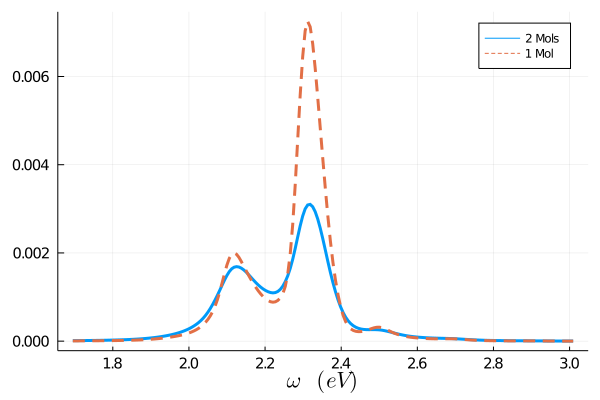

In [1646]:
plot(FRangeIO,AdjustedAbsWeak2Mol,linewidth=3,xlabel=L"\omega\quad (eV)",
   xtickfont=10, ytickfont=10,guidefontsize=15,label="2 Mols")
plot!(FRangeIO,AdjustedAbsWeak1Mol,linestyle=:dash,linewidth=3,label="1 Mol")
#savefig("CompWeakAbs.pdf")
#TODO: how to explain the differences between this and the single-molecule case?

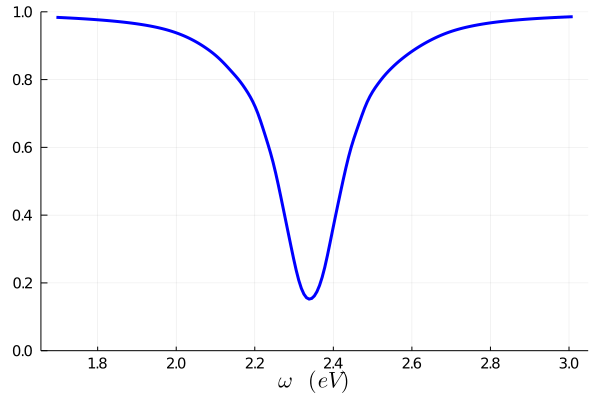

In [1077]:
RefWeak2Mol=zeros(Float64,length(FRangeIO))
for i in 1:length(FRangeIO)
   RefWeak2Mol[i]= abs(STot_NumMol[1,2,i])^2
end



#plot(FRangeIO,RefWeak2Mol,linewidth=3,xlabel=L"\omega\quad (eV)",color=:blue,
#    xtickfont=10, ytickfont=10,guidefontsize=15,label="R. Coeff.",legend=false,ylims=(0,1))

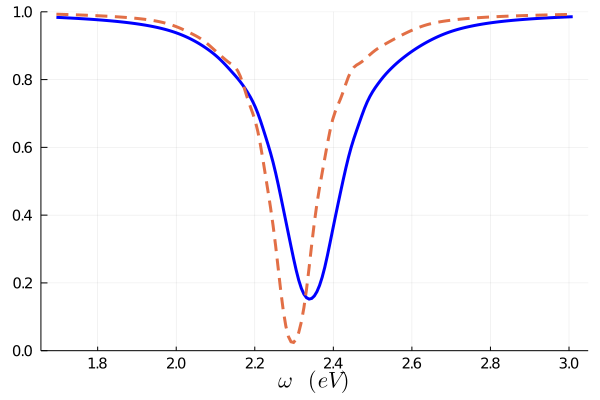

In [1132]:
plot(FRangeIO,RefWeak2Mol,linewidth=3,xlabel=L"\omega\quad (eV)",color=:blue,
    xtickfont=10, ytickfont=10,guidefontsize=15,label="R. Coeff.",legend=false,ylims=(0,1))
plot!(FRangeIO,RefWeak1Mol,linestyle=:dash,linewidth=3)

In [1133]:
TransWeak2Mol=zeros(Float64,length(FRangeIO))
for i in 1:length(FRangeIO)
   TransWeak2Mol[i]= 1-RefWeak2Mol[i]-AdjustedAbsWeak2Mol[i]
end



#plot(FRangeIO,TransWeak2Mol,linewidth=3,xlabel=L"\omega\quad (eV)",color=:red,
#    xtickfont=10, ytickfont=10,guidefontsize=15,label="T. Coeff.",legend=false,ylims=(0,1))

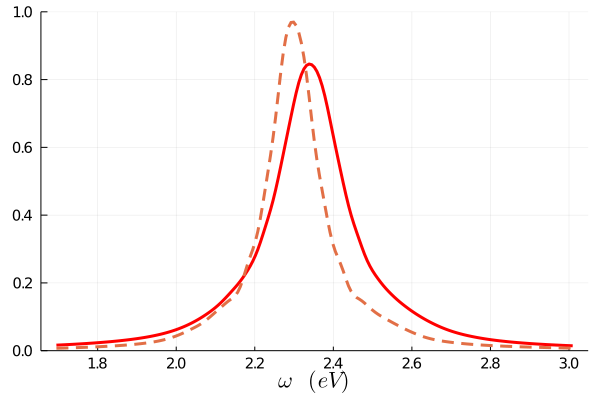

In [1136]:
plot(FRangeIO,TransWeak2Mol,linewidth=3,xlabel=L"\omega\quad (eV)",color=:red,
    xtickfont=10, ytickfont=10,guidefontsize=15,label="T. Coeff.",legend=false,ylims=(0,1))
plot!(FRangeIO,TransWeak1Mol,linestyle=:dash,linewidth=3)

# 2 Molecules. Weak coupling: transient absorption

In [66]:
Cross_Phot20G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/20Cross_Phot_E1V00P1")
Cross_Exc20G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/20Cross_Exc_E1V00P1")

Cross_Phot40G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/40Cross_Phot_E1V00P1")
Cross_Exc40G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/40Cross_Exc_E1V00P1")

Cross_Phot60G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/60Cross_Phot_E1V00P1")
Cross_Exc60G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/60Cross_Exc_E1V00P1")

Cross_Phot80G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/80Cross_Phot_E1V00P1")
Cross_Exc80G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/80Cross_Exc_E1V00P1")

Cross_Phot100G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/100Cross_Phot_E1V00P1")
Cross_Exc100G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/100Cross_Phot_E1V00P1");

In [69]:
Cross_Phot20E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/20Cross_Phot_E2V00P0")
Cross_Exc20E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/20Cross_Exc_E2V00P0")

Cross_Phot40E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/40Cross_Phot_E2V00P0")
Cross_Exc40E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/40Cross_Exc_E2V00P0")

Cross_Phot60E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/60Cross_Phot_E2V00P0")
Cross_Exc60E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/60Cross_Exc_E2V00P0")

Cross_Phot80E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/80Cross_Phot_E2V00P0")
Cross_Exc80E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/80Cross_Exc_E2V00P0")

Cross_Phot100E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/100Cross_Phot_E2V00P0")
Cross_Exc100E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Weak/CrossMasterNonLin/100Cross_Phot_E2V00P0");

deltaT=abs(Cross_Phot20E[1,1]-Cross_Phot20E[2,1])

0.01625

In [70]:
#For ease of data management, we store the all the relevant correlation functions in 2 arrays of length 
#Timepts x number of delay times x number of auxiliary states

init=1
#endT=Timepts-3000
endT=Timepts

delayN=5
AuxStates=2
TotTSim=deltaT*abs(endT-init+1)

PhotContrib=zeros(ComplexF64,(abs(Timepts-init+1),delayN,AuxStates));
ExcContrib=zeros(ComplexF64,(abs(Timepts-init+1),delayN,AuxStates));

FFTPhot=zeros(ComplexF64,(abs(Timepts-init+1),delayN,AuxStates));
FFTExc=zeros(ComplexF64,(abs(Timepts-init+1),delayN,AuxStates));

#We store the transient absoprtion spectrum for each of the delay times, and spllit it in the different 
#contributions...
TAbs=zeros(ComplexF64,(abs(Timepts-init+1),delayN,AuxStates));


In [71]:
PhotContrib[:,1,1]=conj(Cross_Phot20G[init:endT,2]+im*Cross_Phot20G[init:endT,3])
PhotContrib[:,2,1]=conj(Cross_Phot40G[init:endT,2]+im*Cross_Phot40G[init:endT,3])
PhotContrib[:,3,1]=conj(Cross_Phot60G[init:endT,2]+im*Cross_Phot60G[init:endT,3])
PhotContrib[:,4,1]=conj(Cross_Phot80G[init:endT,2]+im*Cross_Phot80G[init:endT,3])
PhotContrib[:,5,1]=conj(Cross_Phot100G[init:endT,2]+im*Cross_Phot100G[init:endT,3])

PhotContrib[:,1,2]=conj(Cross_Phot20E[init:endT,2]+im*Cross_Phot20E[init:endT,3])
PhotContrib[:,2,2]=conj(Cross_Phot40E[init:endT,2]+im*Cross_Phot40E[init:endT,3])
PhotContrib[:,3,2]=conj(Cross_Phot60E[init:endT,2]+im*Cross_Phot60E[init:endT,3])
PhotContrib[:,4,2]=conj(Cross_Phot80E[init:endT,2]+im*Cross_Phot80E[init:endT,3])
PhotContrib[:,5,2]=conj(Cross_Phot100E[init:endT,2]+im*Cross_Phot100E[init:endT,3])


ExcContrib[:,1,1]=Cross_Exc20G[init:endT,2]+im*Cross_Exc20G[init:endT,3]
ExcContrib[:,2,1]=Cross_Exc40G[init:endT,2]+im*Cross_Exc40G[init:endT,3]
ExcContrib[:,3,1]=Cross_Exc60G[init:endT,2]+im*Cross_Exc60G[init:endT,3]
ExcContrib[:,4,1]=Cross_Exc80G[init:endT,2]+im*Cross_Exc80G[init:endT,3]
ExcContrib[:,5,1]=Cross_Exc100G[init:endT,2]+im*Cross_Exc100G[init:endT,3]

ExcContrib[:,1,2]=Cross_Exc20E[init:endT,2]+im*Cross_Exc20E[init:endT,3]
ExcContrib[:,2,2]=Cross_Exc40E[init:endT,2]+im*Cross_Exc40E[init:endT,3]
ExcContrib[:,3,2]=Cross_Exc60E[init:endT,2]+im*Cross_Exc60E[init:endT,3]
ExcContrib[:,4,2]=Cross_Exc80E[init:endT,2]+im*Cross_Exc80E[init:endT,3]
ExcContrib[:,5,2]=Cross_Exc100E[init:endT,2]+im*Cross_Exc100E[init:endT,3]




#Application of filter
#for i in 1:length(PhotContrib[:,1,1])
    
#    PhotContrib[i,:,:]=PhotContrib[i,:,:]*cos(pi*i/(2*length(PhotContrib[:,1,1])))
#    ExcContrib[i,:,:]=ExcContrib[i,:,:]*cos(pi*i/(2*length(ExcContrib[:,1,1])))
    
     
    
#end



FreqsTest=0.658*fftfreq(length(PhotContrib[:,1,1]))*2*pi/deltaT

for i in 1:length(PhotContrib[1,:,1]) #loop over the delay times
    
    for j in 1:length(PhotContrib[1,1,:]) #loop pver the contributions...
        FFTPhot[:,i,j]=ifft(PhotContrib[:,i,j])*TotTSim/0.658
        FFTExc[:,i,j]=ifft(ExcContrib[:,i,j])*TotTSim/0.658
        
        FFTPhot[:,i,j]=fftshift(FFTPhot[:,i,j])
        FFTExc[:,i,j]=fftshift(FFTExc[:,i,j])
        
    end
    
end

FreqsTest=fftshift(FreqsTest)



#We wrap up the result...

for i in 1:length(PhotContrib[1,:,1]) #loop over the delay times
    
    for j in 1:length(PhotContrib[1,1,:]) #loop pver the contributions...
        TAbs[:,i,j]=conj(FFTPhot[:,i,j]).*FFTExc[:,i,j]
    end
end

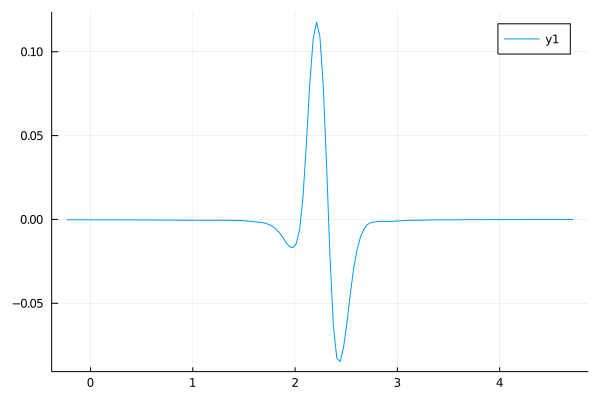

In [72]:
plot(FreqsTest[3850:4000],-imag(TAbs[3850:4000,1,1]))
#plot!(FreqsTest[3850:4000],-2*imag(TAbs[3850:4000,1,2]))

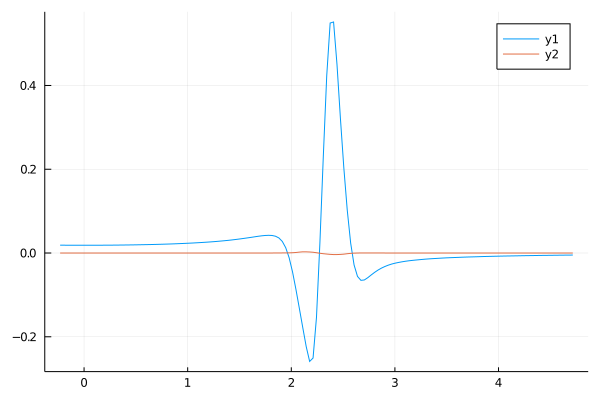

In [76]:
plot(FreqsTest[3850:4000],-imag(TAbs[3850:4000,5,1]))
plot!(FreqsTest[3850:4000],-2*imag(TAbs[3850:4000,5,2]))

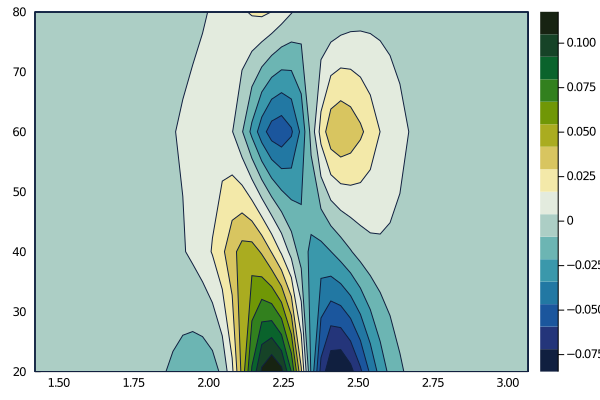

In [80]:
#rearranging data for plotting...
z=zeros(ComplexF64,(abs(endT-init+1),DelayN-1));

for i in 1:(DelayN-1)
    for j in 1:AuxStates
        z[:,i]+=TAbs[:,i,j]
        
    end
    
    
end

#x is the frequencies, y is the delay time...
y=[20.0,40.0, 60.0, 80.0]  

#seriescolor=cgrad(ColorSchemes.leonardo.colors)
#contourf(FreqsTest[3900:3950], y, -imag(transpose(z[3900:3950,:])))


#contourf(FreqsTest[3900:3950], y, -imag(transpose(z[3900:3950,:])),seriescolor=cgrad(ColorSchemes.leonardo.colors))
#contourf(FreqsTest[3910:3940], y, -imag(transpose(z[3910:3940,:])),c=:cork)
contourf(FreqsTest[3900:3950], y, -imag(transpose(z[3900:3950,:])),c=:delta)


# 2 Molecules. Intermediate Coupling

In [18]:
#In contrast to the one molecule case, here we use two files, simply 'cause I forgot to include the
#calculation of expectation values during the propagation...
AmpDum1=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/Multipacket/E1V00P0/AnhL_expectJul"); 
AmpDum2=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/Multipacket/E1V00P0/AhnRC_expectJul");

Timepts,columns=size(AmpDum1)

#Due to limitations in the MCTDH code, I need to formulate the problem in atomic units. To 
#define the dimensionless annhilitation operator a, we scale the time-dependent coordinate and 
#position derivatives and sum them appropietly:

#conversion of eV to atomic units...
#wcAt=wc*ConvEvToFreq
#dampAt=0.00736/2
#dampAt=0.0


#For purposes of simplicity in data handling, we define the next array:
MicAmpMol=zeros(ComplexF64,(Timepts,2))
#MicAmpC=zeros(ComplexF64,(Timepts,3))
BathAmpMol=zeros(ComplexF64,(Timepts,2))

#TotExc=zeros(ComplexF64,(Timepts,2))

#BrightExc=zeros(ComplexF64,(Timepts,2))

#DarkExc=zeros(ComplexF64,(Timepts,2))

#InterCoh=zeros(ComplexF64,(Timepts,2))

for i in 1:Timepts
    scale=sqrt(AmpDum2[i,4]) #norm of the wavefunction. We need to scale each of expectation values computed by MCTDH
    #scale=1.0 #For the simulation of this driven oscillator, we need this scaling factor equal 
    #because the program computes the expectation value over the norm of the wavefunction
    
    MicAmpMol[i,1]=AmpDum2[i,1] #Time coordinate
    MicAmpMol[i,2]=AmpDum2[i,2]*scale #real part of coordinate
    MicAmpMol[i,2]+=im*AmpDum2[i,3]*scale
    
       
    BathAmpMol[i,1]=AmpDum1[i,1] #Time coordinate
    BathAmpMol[i,2]=AmpDum1[i,2]*scale #real part of coordinate
    BathAmpMol[i,2]+=im*AmpDum1[i,3]*scale
    
    #TotExc[i,1]=AmpDum[i,1]
    #TotExc[i,2]=AmpDum[i,7]*scale
    #TotExc[i,2]+=im*AmpDum[i,8]*scale
    
    #BrightExc[i,1]=AmpDum[i,1]
    #BrightExc[i,2]=AmpDum[i,11]*scale
    #BrightExc[i,2]+=im*AmpDum[i,12]*scale
    
    #DarkExc[i,1]=AmpDum[i,1]
    #DarkExc[i,2]=AmpDum[i,13]*scale
    #DarkExc[i,2]+=im*AmpDum[i,14]*scale
    
    #InterCoh[i,1]=AmpDum[i,1]
    #InterCoh[i,2]=AmpDum[i,15]*scale
    #InterCoh[i,2]+=im*AmpDum[i,16]*scale
   
    
    
end




deltaT=abs(MicAmpMol[1,1]-MicAmpMol[2,1]);
Ttime=abs(MicAmpMol[1,1]-MicAmpMol[Timepts,1]) #This is the total time of the simulation, in fs!!



125.32

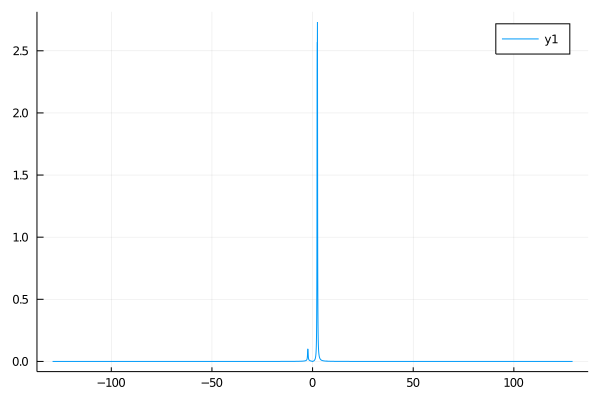

In [19]:
FouMicMol=ifft(MicAmpMol[:,2])*length(MicAmpMol[:,2])*deltaT

FreqsFFTMol=0.658*fftfreq(length(MicAmpMol[:,2]))*2*pi/deltaT ;#Here we take advantage of the equal size along all dimensions
  
FreqsFFTMol=fftshift(FreqsFFTMol)
FouMicMol=fftshift(FouMicMol);
plot(FreqsFFTMol,abs.(FouMicMol))

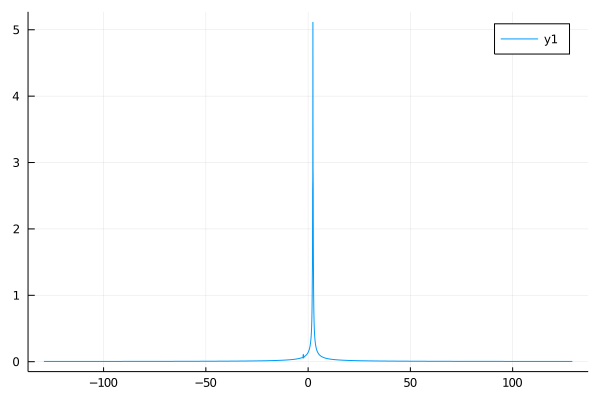

In [20]:
FouBathMol=ifft(BathAmpMol[:,2])*length(MicAmpMol[:,2])*deltaT
FreqsFFTMol=0.658*fftfreq(length(MicAmpMol[:,2]))*2*pi/deltaT ;#Here we take advantage of the equal size along all dimensions
  
FreqsFFTMol=fftshift(FreqsFFTMol)
FouBathMol=fftshift(FouBathMol);
plot(FreqsFFTMol,abs.(FouBathMol))

In [21]:
spRMicMol=Spline1D(real(FreqsFFTMol), real(FouMicMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);
spImMicMol=Spline1D(real(FreqsFFTMol),imag(FouMicMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);
spRBathMol=Spline1D(real(FreqsFFTMol), real(FouBathMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);
spImBathMol=Spline1D(real(FreqsFFTMol), imag(FouBathMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);

In [27]:
#lets consider a range of frequencies for which we know the system-bath coupling constants
FRangeIdx=500:1:700 #WARNING: this is the range of indexes of the frequencies of interest. This must be selected
#such that they cover the frequency of the bath used in our effective model...

Rangepts=length(FRangeIdx)
FRangeIO=Freqs[500:700].^2 *CovToEv/2 #Freqs in eVs!!! These parameters are already defined in the molecular-free
#section

#calculation "by hand" of the IO scattering matrix for each frequency
SIO_NumMol=zeros(ComplexF64,(2,2,Rangepts))

for i in 1:Rangepts
   #retrieve the system-bath coupling for each frequency, as well as the relative phase between the degenerate modes
    #conversion to sqrt(eV), those are the units of this guy...
    CoupLeft=sqrt(CovToEv)*HSB[1,1,FRangeIdx[i]] #left
    CoupRight=sqrt(CovToEv)*HSB[2,1,FRangeIdx[i]]; #right

    PsiLeft=angle(CoupLeft)
    PsiRight=angle(CoupRight)
    
    ELR=exp(-im*(PsiLeft-PsiRight)) #difference in phases of couplings
    AuxRatio=abs(CoupRight)/abs(CoupLeft)
    #ratio of bath and microcavity amplitudes...We assume that the bath that drives the system is always from the left
    #such that the we can scale that result appropiately to get the corresponding result for the right bath
    Ratio=(evaluate(spRMicMol,FRangeIO[i])+im*evaluate(spImMicMol,FRangeIO[i]))/(evaluate(spRBathMol,FRangeIO[i])+im*evaluate(spImBathMol,FRangeIO[i]))
    
    SIO_NumMol[1,1,i]=1-2*pi*im*abs(CoupLeft)*Ratio
    SIO_NumMol[1,2,i]=-2*pi*im*abs(CoupLeft)*AuxRatio*ELR*Ratio
    SIO_NumMol[2,1,i]=-2*pi*im*abs(CoupRight)*conj(ELR)*Ratio
    SIO_NumMol[2,2,i]=1-2*pi*im*abs(CoupRight)*AuxRatio*Ratio
    
    
    
end


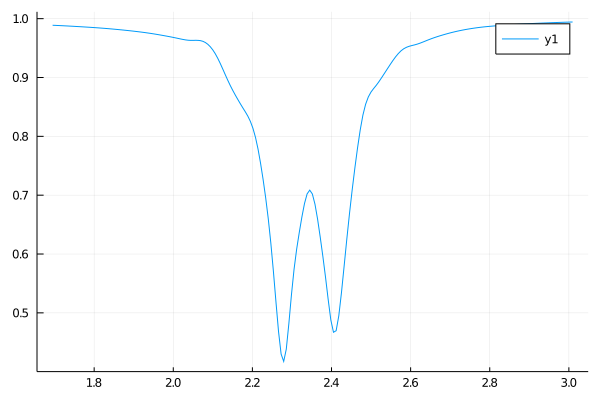

In [28]:
plot(FRangeIO,abs.(SIO_NumMol[1,1,:]))

In [29]:
STot_NumMol=zeros(ComplexF64,(2,2,Rangepts))

for i in 1:Rangepts
    
    STot_NumMol[:,:,i]=*(ScatMats[:,:,FRangeIdx[i]],SIO_NumMol[:,:,i])
    
end

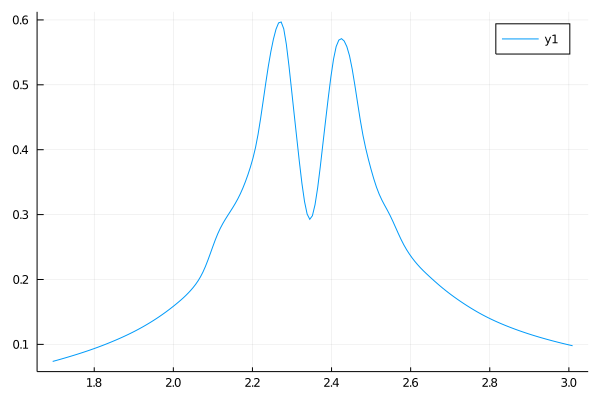

In [30]:
plot(FRangeIO,abs.(STot_NumMol[1,1,:]))

In [31]:
#Calculation of the molecular absorption
#Load the data associated to the different wavepackets...
E1V00P1Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/Multipacket/CrossMaster/E1V00P1Cross_Exc")
E1V00P1Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/Multipacket/CrossMaster/E1V00P1Cross_Phot")

E1V01P1Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/Multipacket/CrossMaster/E1V01P1Cross_Exc")
E1V01P1Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/Multipacket/CrossMaster/E1V01P1Cross_Phot")

E1V10P1Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/Multipacket/CrossMaster/E1V10P1Cross_Exc")
E1V10P1Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/Multipacket/CrossMaster/E1V10P1Cross_Phot");

E2V00P0Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/Multipacket/CrossMaster/E2V00P0Cross_Exc")
E2V00P0Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/Multipacket/CrossMaster/E2V00P0Cross_Phot");

E3V00P0Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/Multipacket/CrossMaster/E3V00P0Cross_Exc")
E3V00P0Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/Multipacket/CrossMaster/E3V00P0Cross_Phot");

E1V00P0Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/Multipacket/CrossMaster/E1V00P0Cross_Exc")
E1V00P0Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/Multipacket/CrossMaster/E1V00P0Cross_Phot")


Timepts,=size(E1V00P1Cross_Exc)

(7713, 5)

In [32]:
init=1
#endT=Timepts-3000
endT=Timepts

WRange=10 #Frequency range goes from -WRange/2 to WRange/2, in eV

SampTime=2*pi*0.658/WRange 

#sampling rate in fs
SampRate=Int64(div(2*pi*0.658/WRange,deltaT,RoundDown))

#total number of points:
TotPts=endT-init+1

#number of points to sample:
SampPts=Int64(div(TotPts,SampRate,RoundDown))

Filtered1=zeros(ComplexF64,SampPts)
Filtered2=zeros(ComplexF64,SampPts)
Filtered3=zeros(ComplexF64,SampPts)
Filtered4=zeros(ComplexF64,SampPts)
Filtered5=zeros(ComplexF64,SampPts)
Filtered6=zeros(ComplexF64,SampPts)
Filtered7=zeros(ComplexF64,SampPts)
Filtered8=zeros(ComplexF64,SampPts)
Filtered9=zeros(ComplexF64,SampPts)
Filtered10=zeros(ComplexF64,SampPts)
Filtered11=zeros(ComplexF64,SampPts)
Filtered12=zeros(ComplexF64,SampPts)

for i in 1:SampPts
    Filtered1[i]=conj(E1V00P1Cross_Phot[init+i*SampRate-1,2]+im*E1V00P1Cross_Phot[init+i*SampRate-1,3])
    Filtered2[i]=E1V00P1Cross_Exc[init+i*SampRate-1,2]+im*E1V00P1Cross_Exc[init+i*SampRate-1,3]

    Filtered3[i]=conj(E1V01P1Cross_Phot[init+i*SampRate-1,2]+im*E1V01P1Cross_Phot[init+i*SampRate-1,3])
    Filtered4[i]=E1V01P1Cross_Exc[init+i*SampRate-1,2]+im*E1V01P1Cross_Exc[init+i*SampRate-1,3]

    Filtered5[i]=conj(E1V10P1Cross_Phot[init+i*SampRate-1,2]+im*E1V10P1Cross_Phot[init+i*SampRate-1,3])
    Filtered6[i]=E1V10P1Cross_Exc[init+i*SampRate-1,2]+im*E1V10P1Cross_Exc[init+i*SampRate-1,3]

    Filtered7[i]=conj(E2V00P0Cross_Phot[init+i*SampRate-1,2]+im*E2V00P0Cross_Phot[init+i*SampRate-1,3])
    Filtered8[i]=E2V00P0Cross_Exc[init+i*SampRate-1,2]+im*E2V00P0Cross_Exc[init+i*SampRate-1,3]

    Filtered9[i]=conj(E3V00P0Cross_Phot[init+i*SampRate-1,2]+im*E3V00P0Cross_Phot[init+i*SampRate-1,3])
    Filtered10[i]=E3V00P0Cross_Exc[init+i*SampRate-1,2]+im*E3V00P0Cross_Exc[init+i*SampRate-1,3]

    Filtered11[i]=conj(E1V00P0Cross_Phot[init+i*SampRate-1,2]+im*E1V00P0Cross_Phot[init+i*SampRate-1,3])
    Filtered12[i]=E1V00P0Cross_Exc[init+i*SampRate-1,2]+im*E1V00P0Cross_Exc[init+i*SampRate-1,3]
    
    
    
    
end


#Application of filter
for i in 1:length(Filtered1)
    Filtered1[i]=Filtered1[i]*cos(pi*i/(2*length(Filtered1[:,1])))
    Filtered2[i]=Filtered2[i]*cos(pi*i/(2*length(Filtered2[:,1])))
    
    Filtered3[i]=Filtered3[i]*cos(pi*i/(2*length(Filtered3[:,1])))
    Filtered4[i]=Filtered4[i]*cos(pi*i/(2*length(Filtered4[:,1])))
    
    Filtered5[i]=Filtered5[i]*cos(pi*i/(2*length(Filtered5[:,1])))
    Filtered6[i]=Filtered6[i]*cos(pi*i/(2*length(Filtered6[:,1])))
    
    Filtered7[i]=Filtered7[i]*cos(pi*i/(2*length(Filtered7[:,1])))
    Filtered8[i]=Filtered8[i]*cos(pi*i/(2*length(Filtered8[:,1])))
    
    Filtered9[i]=Filtered9[i]*cos(pi*i/(2*length(Filtered9[:,1])))
    Filtered10[i]=Filtered10[i]*cos(pi*i/(2*length(Filtered10[:,1])))
    
    Filtered11[i]=Filtered11[i]*cos(pi*i/(2*length(Filtered11[:,1])))
    Filtered12[i]=Filtered12[i]*cos(pi*i/(2*length(Filtered12[:,1])))
    
    
    
end



FreqsTest=0.658*fftfreq(length(Filtered1[:,1]))*2*pi/SampTime

#FouTest=ifft(Exc0Vib0PhotCross_Exc[:,2]+im*Exc0Vib0PhotCross_Exc[:,3])
FouTest1=ifft(Filtered1)*TotPts*deltaT/0.658
FouTest2=ifft(Filtered2)*TotPts*deltaT/0.658

FouTest3=ifft(Filtered3)*TotPts*deltaT/0.658
FouTest4=ifft(Filtered4)*TotPts*deltaT/0.658

FouTest5=ifft(Filtered5)*TotPts*deltaT/0.658
FouTest6=ifft(Filtered6)*TotPts*deltaT/0.658

FouTest7=ifft(Filtered7)*TotPts*deltaT/0.658
FouTest8=ifft(Filtered8)*TotPts*deltaT/0.658

FouTest9=ifft(Filtered9)*TotPts*deltaT/0.658
FouTest10=ifft(Filtered10)*TotPts*deltaT/0.658

FouTest11=ifft(Filtered11)*TotPts*deltaT/0.658
FouTest12=ifft(Filtered12)*TotPts*deltaT/0.658


#****
#l=3855
#for i in 1:length(FouTest)
#    FouTest[i]=exp(im*l*FreqsTest[i])*FouTest[i]
#end

#****


FreqsTest=fftshift(FreqsTest)
FouTest1=fftshift(FouTest1);
FouTest2=fftshift(FouTest2);

FouTest3=fftshift(FouTest3);
FouTest4=fftshift(FouTest4);

FouTest5=fftshift(FouTest5);
FouTest6=fftshift(FouTest6);

FouTest7=fftshift(FouTest7)
FouTest8=fftshift(FouTest8);

FouTest9=fftshift(FouTest9)
FouTest10=fftshift(FouTest10);

FouTest11=fftshift(FouTest11)
FouTest12=fftshift(FouTest12);


Product1=conj(FouTest1).*FouTest2

Product2=conj(FouTest3).*FouTest4

Product3=conj(FouTest5).*FouTest6

Product4=conj(FouTest7).*FouTest8

Product5=conj(FouTest9).*FouTest10

Product6=conj(FouTest11).*FouTest12;

#plot(FreqsTest[2300:2500],(imag(Product[2300:2500])))
#plot(FreqsTest[3850:4000],imag(Product1[3850:4000]))
#plot!(FreqsTest[3850:4000],imag(Product2[3850:4000]))
#plot!(FreqsTest[3850:4000],imag(Product3[3850:4000]))

#plot(FreqsTest[3850:4000],-(imag(Product3[3850:4000])+imag(Product2[3850:4000]+imag(Product1[3850:4000]))))

#plot(FreqsTest[2350:2500],-(imag(Product5[2350:2500])+imag(Product4[2350:2500])+imag(Product3[2350:2500])+imag(Product2[2350:2500]+imag(Product1[2350:2500]))))

#plot(FreqsTest[3850:4000],(real(Product3[3850:4000])+real(Product2[3850:4000]+real(Product1[3850:4000]))))

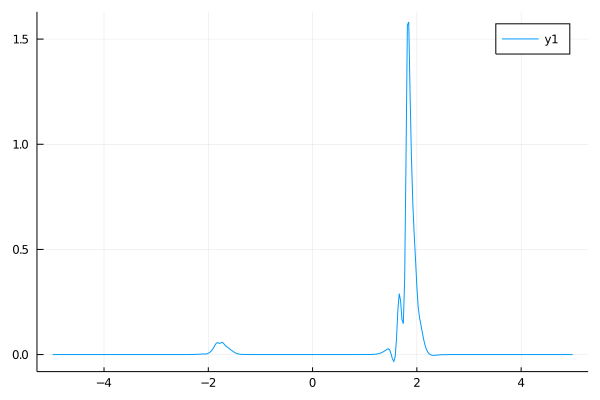

In [58]:
TotalAbs=-(imag(Product4)+imag(Product5)+imag(Product6))*2*sqrt(2)*0.141*(2.314-0.2)
plot(FreqsTest,TotalAbs)

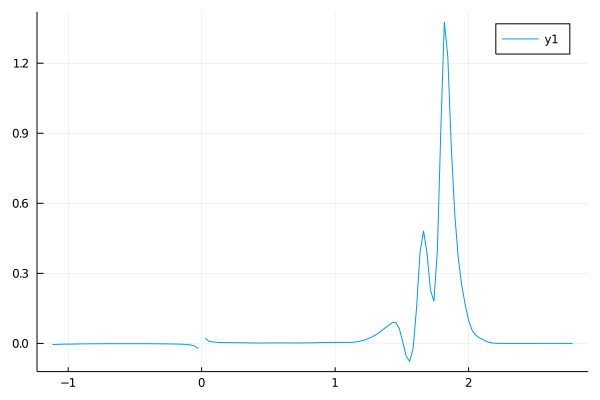

In [59]:
spInput=Spline1D(FreqsFFTMol[3850:4000], abs.(FouBathMol[3850:4000]).^2; w=ones(length(FreqsFFTMol[3850:4000])),
    k=3, bc="nearest", s=0.0);

NormAbs=zeros(Float64,length(FreqsTest[150:300]))


for i in 1:length(FreqsTest[150:300])
    
    NormAbs[i]=TotalAbs[150+i-1]/(FreqsTest[150+i-1]*evaluate(spInput,FreqsTest[150+i-1])/0.658)
    #NormAbs[i]=TotalAbs[3920+i-1]/abs(evaluate(spInput,FreqsTest[3920+i-1]))
    
end


plot(FreqsTest[150:300],(NormAbs))

In [62]:
FreqsTest[160]

-0.8571428571428572

In [60]:
spAbs=Spline1D(FreqsTest[160:300], NormAbs[10:length(NormAbs)-1]; w=ones(length(FreqsTest[160:300])), k=3, bc="nearest", s=0.0)

AdjustedAbsInter2Mol=zeros(Float64,length(FRangeIO))

for i in 1:length(FRangeIO)
    
    AdjustedAbsInter2Mol[i]= evaluate(spAbs,FRangeIO[i])
    
end

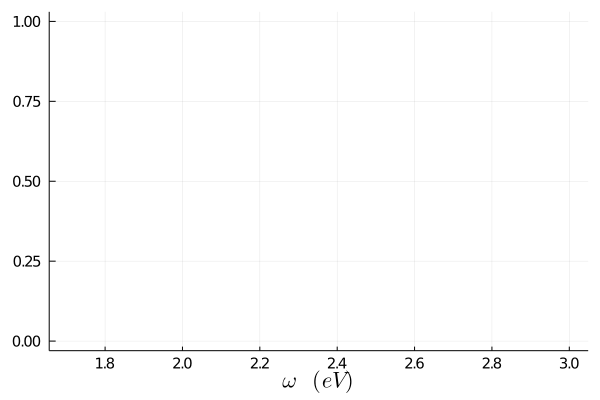

In [61]:
plot(FRangeIO,AdjustedAbsInter2Mol,linewidth=3,xlabel=L"\omega\quad (eV)",
   xtickfont=10, ytickfont=10,guidefontsize=15,label="Abs. Coeff.",legend=false)
#plot!(FRangeIO,AdjustedAbsInter1Mol,linestyle=:dash,linewidth=3)
#TODO: how to explain the differences between this and the single-molecule case?

In [37]:
RefInter2Mol=zeros(Float64,length(FRangeIO))
for i in 1:length(FRangeIO)
   RefInter2Mol[i]= abs(STot_NumMol[1,2,i])^2
end



#plot(FRangeIO,RefInter2Mol,linewidth=3,xlabel=L"\omega\quad (eV)",color=:blue,
#    xtickfont=10, ytickfont=10,guidefontsize=15,label="R. Coeff.",legend=false,ylims=(0,1))

In [38]:
plot(FRangeIO,RefInter2Mol,linewidth=3,xlabel=L"\omega\quad (eV)",color=:blue,
    xtickfont=10, ytickfont=10,guidefontsize=15,label="R. Coeff.",legend=false,ylims=(0,1))
plot!(FRangeIO,RefInter1Mol,linestyle=:dash,linewidth=3)

LoadError: UndefVarError: RefInter1Mol not defined

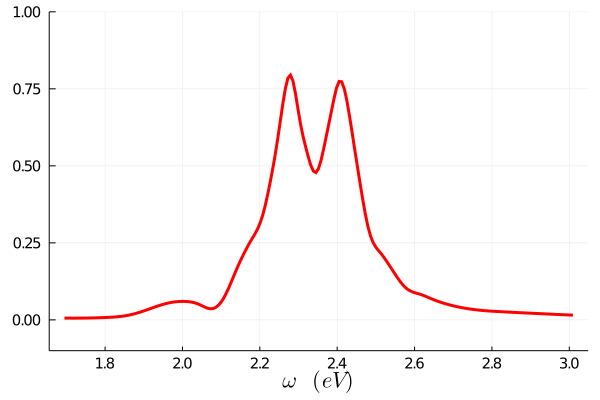

In [1094]:
TransInter2Mol=zeros(Float64,length(FRangeIO))
for i in 1:length(FRangeIO)
   TransInter2Mol[i]= 1-RefInter2Mol[i]-AdjustedAbsInter2Mol[i]
end



#plot(FRangeIO,TransInter2Mol,linewidth=3,xlabel=L"\omega\quad (eV)",color=:red,
#    xtickfont=10, ytickfont=10,guidefontsize=15,label="T. Coeff.",legend=false,ylims=(-0.1,1))




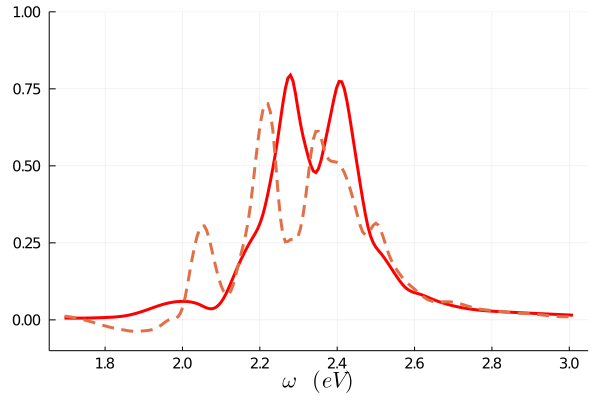

In [1129]:
plot(FRangeIO,TransInter2Mol,linewidth=3,xlabel=L"\omega\quad (eV)",color=:red,
    xtickfont=10, ytickfont=10,guidefontsize=15,label="T. Coeff.",legend=false,ylims=(-0.1,1))
plot!(FRangeIO,TransInter1Mol,linestyle=:dash,linewidth=3)

# 2 Molecules. Intermediate coupling: transient absorption

In [81]:
#loading data...
Cross_Phot20G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/20Cross_Phot_E1V00P1")
Cross_Exc20G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/20Cross_Exc_E1V00P1")

Cross_Phot40G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/40Cross_Phot_E1V00P1")
Cross_Exc40G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/40Cross_Exc_E1V00P1")

Cross_Phot60G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/60Cross_Phot_E1V00P1")
Cross_Exc60G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/60Cross_Exc_E1V00P1")

Cross_Phot80G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/80Cross_Phot_E1V00P1")
Cross_Exc80G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/80Cross_Exc_E1V00P1")

Cross_Phot100G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/100Cross_Phot_E1V00P1")
Cross_Exc100G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/100Cross_Phot_E1V00P1");

In [87]:
Cross_Phot20E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/20Cross_Phot_E2V00P0")
Cross_Exc20E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/20Cross_Exc_E2V00P0")

Cross_Phot40E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/40Cross_Phot_E2V00P0")
Cross_Exc40E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/40Cross_Exc_E2V00P0")

Cross_Phot60E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/60Cross_Phot_E2V00P0")
Cross_Exc60E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/60Cross_Exc_E2V00P0")

Cross_Phot80E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/80Cross_Phot_E2V00P0")
Cross_Exc80E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/80Cross_Exc_E2V00P0")

Cross_Phot100E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/100Cross_Phot_E2V00P0")
Cross_Exc100E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Inter/CrossMasterNonLin/100Cross_Phot_E2V00P0");
deltaT=abs(Cross_Phot20E[1,1]-Cross_Phot20E[2,1])

0.01625

In [88]:
#For ease of data management, we store the all the relevant correlation functions in 2 arrays of length 
#Timepts x number of delay times x number of auxiliary states

init=1
#endT=Timepts-3000
endT=Timepts
TotTSim=deltaT*abs(Timepts-init+1)

delayN=5
AuxStates=2


PhotContrib=zeros(ComplexF64,(abs(Timepts-init+1),delayN,AuxStates));
ExcContrib=zeros(ComplexF64,(abs(Timepts-init+1),delayN,AuxStates));

FFTPhot=zeros(ComplexF64,(abs(Timepts-init+1),delayN,AuxStates));
FFTExc=zeros(ComplexF64,(abs(Timepts-init+1),delayN,AuxStates));

#We store the transient absoprtion spectrum for each of the delay times, and spllit it in the different 
#contributions...
TAbs=zeros(ComplexF64,(abs(Timepts-init+1),delayN,AuxStates));

In [89]:
PhotContrib[:,1,1]=conj(Cross_Phot20G[init:endT,2]+im*Cross_Phot20G[init:endT,3])
PhotContrib[:,2,1]=conj(Cross_Phot40G[init:endT,2]+im*Cross_Phot40G[init:endT,3])
PhotContrib[:,3,1]=conj(Cross_Phot60G[init:endT,2]+im*Cross_Phot60G[init:endT,3])
PhotContrib[:,4,1]=conj(Cross_Phot80G[init:endT,2]+im*Cross_Phot80G[init:endT,3])
PhotContrib[:,5,1]=conj(Cross_Phot100G[init:endT,2]+im*Cross_Phot100G[init:endT,3])

PhotContrib[:,1,2]=conj(Cross_Phot20E[init:endT,2]+im*Cross_Phot20E[init:endT,3])
PhotContrib[:,2,2]=conj(Cross_Phot40E[init:endT,2]+im*Cross_Phot40E[init:endT,3])
PhotContrib[:,3,2]=conj(Cross_Phot60E[init:endT,2]+im*Cross_Phot60E[init:endT,3])
PhotContrib[:,4,2]=conj(Cross_Phot80E[init:endT,2]+im*Cross_Phot80E[init:endT,3])
PhotContrib[:,5,2]=conj(Cross_Phot100E[init:endT,2]+im*Cross_Phot100E[init:endT,3])


ExcContrib[:,1,1]=Cross_Exc20G[init:endT,2]+im*Cross_Exc20G[init:endT,3]
ExcContrib[:,2,1]=Cross_Exc40G[init:endT,2]+im*Cross_Exc40G[init:endT,3]
ExcContrib[:,3,1]=Cross_Exc60G[init:endT,2]+im*Cross_Exc60G[init:endT,3]
ExcContrib[:,4,1]=Cross_Exc80G[init:endT,2]+im*Cross_Exc80G[init:endT,3]
ExcContrib[:,5,1]=Cross_Exc100G[init:endT,2]+im*Cross_Exc100G[init:endT,3]

ExcContrib[:,1,2]=Cross_Exc20E[init:endT,2]+im*Cross_Exc20E[init:endT,3]
ExcContrib[:,2,2]=Cross_Exc40E[init:endT,2]+im*Cross_Exc40E[init:endT,3]
ExcContrib[:,3,2]=Cross_Exc60E[init:endT,2]+im*Cross_Exc60E[init:endT,3]
ExcContrib[:,4,2]=Cross_Exc80E[init:endT,2]+im*Cross_Exc80E[init:endT,3]
ExcContrib[:,5,2]=Cross_Exc100E[init:endT,2]+im*Cross_Exc100E[init:endT,3]




#Application of filter
#for i in 1:length(PhotContrib[:,1,1])
    
#    PhotContrib[i,:,:]=PhotContrib[i,:,:]*cos(pi*i/(2*length(PhotContrib[:,1,1])))
#    ExcContrib[i,:,:]=ExcContrib[i,:,:]*cos(pi*i/(2*length(ExcContrib[:,1,1])))
    
     
    
#end



FreqsTest=0.658*fftfreq(length(PhotContrib[:,1,1]))*2*pi/deltaT

for i in 1:length(PhotContrib[1,:,1]) #loop over the delay times
    
    for j in 1:length(PhotContrib[1,1,:]) #loop pver the contributions...
        FFTPhot[:,i,j]=ifft(PhotContrib[:,i,j])*TotTSim/0.658
        FFTExc[:,i,j]=ifft(ExcContrib[:,i,j])*TotTSim/0.658
        
        FFTPhot[:,i,j]=fftshift(FFTPhot[:,i,j])
        FFTExc[:,i,j]=fftshift(FFTExc[:,i,j])
        
    end
    
end

FreqsTest=fftshift(FreqsTest)



#We wrap up the result...

for i in 1:length(PhotContrib[1,:,1]) #loop over the delay times
    
    for j in 1:length(PhotContrib[1,1,:]) #loop pver the contributions...
        TAbs[:,i,j]=conj(FFTPhot[:,i,j]).*FFTExc[:,i,j]
    end
end

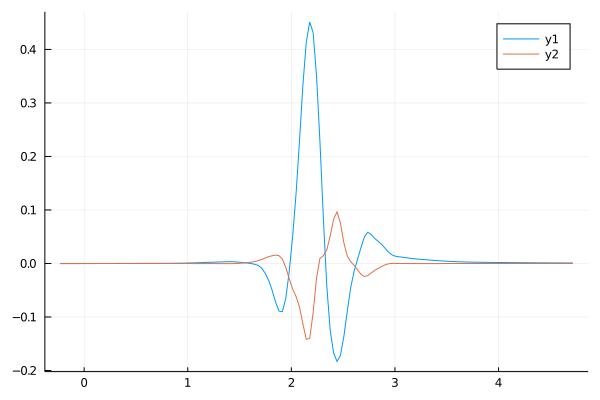

In [90]:
plot(FreqsTest[3850:4000],-imag(TAbs[3850:4000,1,1]))
plot!(FreqsTest[3850:4000],-2*imag(TAbs[3850:4000,1,2]))

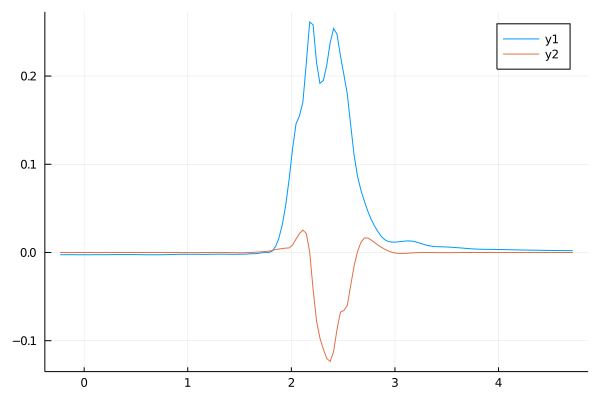

In [91]:
plot(FreqsTest[3850:4000],-imag(TAbs[3850:4000,5,1]))
plot!(FreqsTest[3850:4000],-2*imag(TAbs[3850:4000,5,2]))

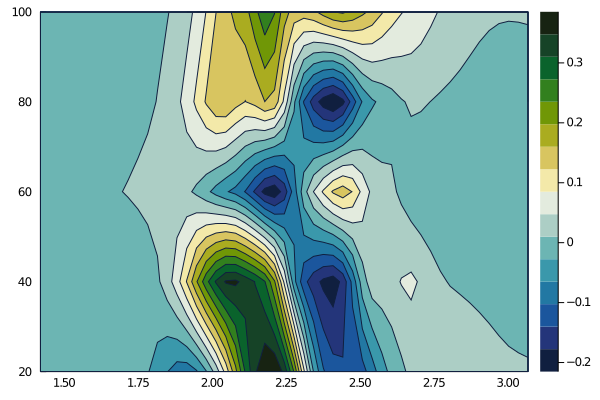

In [93]:
#rearranging data for plotting...
z=zeros(ComplexF64,(abs(endT-init+1),DelayN));

for i in 1:(DelayN)
    for j in 1:AuxStates
        z[:,i]+=TAbs[:,i,j]
        
    end
    
    
end

#x is the frequencies, y is the delay time...
y=[20.0,40.0, 60.0, 80.0,100.0]  

#seriescolor=cgrad(ColorSchemes.leonardo.colors)
#contourf(FreqsTest[3900:3950], y, -imag(transpose(z[3900:3950,:])))


#contourf(FreqsTest[3900:3950], y, -imag(transpose(z[3900:3950,:])),seriescolor=cgrad(ColorSchemes.leonardo.colors))
#contourf(FreqsTest[3910:3940], y, -imag(transpose(z[3910:3940,:])),c=:cork)
contourf(FreqsTest[3900:3950], y, -imag(transpose(z[3900:3950,:])),c=:delta)


# 2 Molecules. Strong Coupling

In [1095]:
AmpDum=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/E1V00P0/expectationJul"); 
 


Timepts,columns=size(AmpDum)

#Due to limitations in the MCTDH code, I need to formulate the problem in atomic units. To 
#define the dimensionless annhilitation operator a, we scale the time-dependent coordinate and 
#position derivatives and sum them appropietly:

#conversion of eV to atomic units...
#wcAt=wc*ConvEvToFreq
#dampAt=0.00736/2
#dampAt=0.0


#For purposes of simplicity in data handling, we define the next array:
MicAmpMol=zeros(ComplexF64,(Timepts,2))
#MicAmpC=zeros(ComplexF64,(Timepts,3))
BathAmpMol=zeros(ComplexF64,(Timepts,2))

#TotExc=zeros(ComplexF64,(Timepts,2))

#BrightExc=zeros(ComplexF64,(Timepts,2))

#DarkExc=zeros(ComplexF64,(Timepts,2))

for i in 1:Timepts
    scale=AmpDum[i,2] #norm of the wavefunction. We need to scale each of expectation values computed by MCTDH
    #scale=1.0 #For the simulation of this driven oscillator, we need this scaling factor equal 
    #because the program computes the expectation value over the norm of the wavefunction
    
    MicAmpMol[i,1]=AmpDum[i,1] #Time coordinate
    MicAmpMol[i,2]=AmpDum[i,3]*scale #real part of coordinate
    MicAmpMol[i,2]+=im*AmpDum[i,4]*scale
    
       
    BathAmpMol[i,1]=AmpDum[i,1] #Time coordinate
    BathAmpMol[i,2]=AmpDum[i,5]*scale #real part of coordinate
    BathAmpMol[i,2]+=im*AmpDum[i,6]*scale
    
    #TotExc[i,1]=AmpDum[i,1]
    #TotExc[i,2]=AmpDum[i,7]*scale
    #TotExc[i,2]+=im*AmpDum[i,8]*scale
    
    #BrightExc[i,1]=AmpDum[i,1]
    #BrightExc[i,2]=AmpDum[i,11]*scale
    #BrightExc[i,2]+=im*AmpDum[i,12]*scale
    
    #DarkExc[i,1]=AmpDum[i,1]
    #DarkExc[i,2]=AmpDum[i,13]*scale
    #DarkExc[i,2]+=im*AmpDum[i,14]*scale
   
    
    
end




deltaT=abs(MicAmpMol[1,1]-MicAmpMol[2,1]);
Ttime=abs(MicAmpMol[1,1]-MicAmpMol[Timepts,1]) #This is the total time of the simulation, in fs!!


125.32

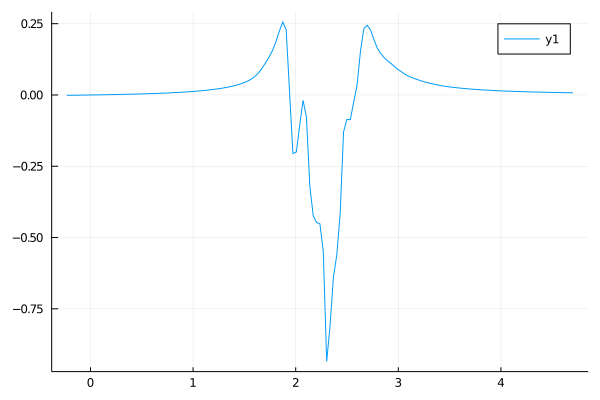

In [1096]:
FouMicMol=ifft(MicAmpMol[:,2])*length(MicAmpMol[:,2])*deltaT

FreqsFFTMol=0.658*fftfreq(length(MicAmpMol[:,2]))*2*pi/deltaT ;#Here we take advantage of the equal size along all dimensions
  
FreqsFFTMol=fftshift(FreqsFFTMol)
FouMicMol=fftshift(FouMicMol);
plot(FreqsFFTMol[3850:4000],imag(FouMicMol[3850:4000]))

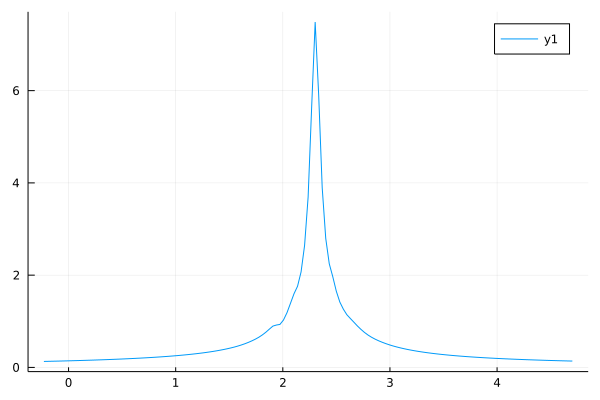

In [1097]:
FouBathMol=ifft(BathAmpMol[:,2])*length(MicAmpMol[:,2])*deltaT
FreqsFFTMol=0.658*fftfreq(length(MicAmpMol[:,2]))*2*pi/deltaT ;#Here we take advantage of the equal size along all dimensions
  
FreqsFFTMol=fftshift(FreqsFFTMol)
FouBathMol=fftshift(FouBathMol);
plot(FreqsFFTMol[3850:4000],abs.(FouBathMol[3850:4000]))

In [1098]:
spRMicMol=Spline1D(real(FreqsFFTMol), real(FouMicMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);
spImMicMol=Spline1D(real(FreqsFFTMol),imag(FouMicMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);
spRBathMol=Spline1D(real(FreqsFFTMol), real(FouBathMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);
spImBathMol=Spline1D(real(FreqsFFTMol), imag(FouBathMol); w=ones(length(FreqsFFTMol)), k=3, bc="nearest", s=0.0);

In [1099]:
#lets consider a range of frequencies for which we know the system-bath coupling constants
FRangeIdx=500:1:700 #WARNING: this is the range of indexes of the frequencies of interest. This must be selected
#such that they cover the frequency of the bath used in our effective model...

Rangepts=length(FRangeIdx)
FRangeIO=Freqs[500:700].^2 *CovToEv/2 #Freqs in eVs!!! These parameters are already defined in the molecular-free
#section

#calculation "by hand" of the IO scattering matrix for each frequency
SIO_NumMol=zeros(ComplexF64,(2,2,Rangepts))

for i in 1:Rangepts
   #retrieve the system-bath coupling for each frequency, as well as the relative phase between the degenerate modes
    #conversion to sqrt(eV), those are the units of this guy...
    CoupLeft=sqrt(CovToEv)*HSB[1,1,FRangeIdx[i]] #left
    CoupRight=sqrt(CovToEv)*HSB[2,1,FRangeIdx[i]]; #right

    PsiLeft=angle(CoupLeft)
    PsiRight=angle(CoupRight)
    
    ELR=exp(-im*(PsiLeft-PsiRight)) #difference in phases of couplings
    AuxRatio=abs(CoupRight)/abs(CoupLeft)
    #ratio of bath and microcavity amplitudes...We assume that the bath that drives the system is always from the left
    #such that the we can scale that result appropiately to get the corresponding result for the right bath
    Ratio=(evaluate(spRMicMol,FRangeIO[i])+im*evaluate(spImMicMol,FRangeIO[i]))/(evaluate(spRBathMol,FRangeIO[i])+im*evaluate(spImBathMol,FRangeIO[i]))
    
    SIO_NumMol[1,1,i]=1-2*pi*im*abs(CoupLeft)*Ratio
    SIO_NumMol[1,2,i]=-2*pi*im*abs(CoupLeft)*AuxRatio*ELR*Ratio
    SIO_NumMol[2,1,i]=-2*pi*im*abs(CoupRight)*conj(ELR)*Ratio
    SIO_NumMol[2,2,i]=1-2*pi*im*abs(CoupRight)*AuxRatio*Ratio
    
    
    
end


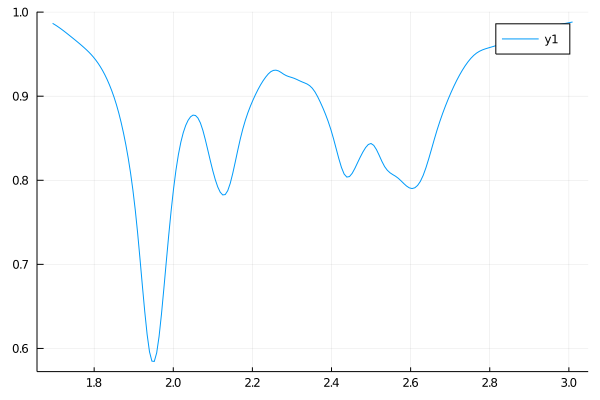

In [1100]:
plot(FRangeIO,abs.(SIO_NumMol[1,1,:]))

In [1101]:
STot_NumMol=zeros(ComplexF64,(2,2,Rangepts))

for i in 1:Rangepts
    
    STot_NumMol[:,:,i]=*(ScatMats[:,:,FRangeIdx[i]],SIO_NumMol[:,:,i])
    
end

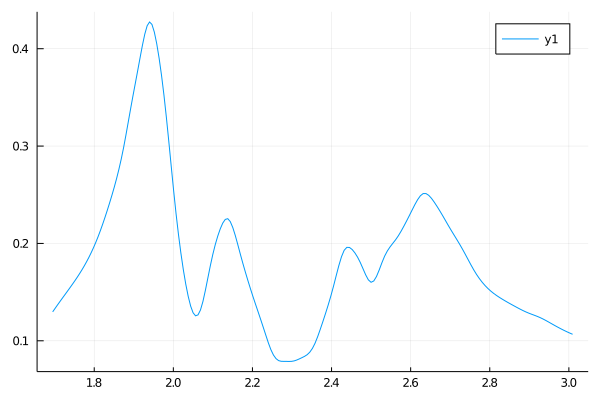

In [1102]:
plot(FRangeIO,abs.(STot_NumMol[1,1,:]))

In [1103]:
#Calculation of the molecular absorption
#Load the data associated to the different wavepackets...
E1V00P1Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E1V00P1Cross_Exc")
E1V00P1Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E1V00P1Cross_Phot")

E1V01P1Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E1V01P1Cross_Exc")
E1V01P1Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E1V01P1Cross_Phot")

E1V10P1Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E1V10P1Cross_Exc")
E1V10P1Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E1V10P1Cross_Phot");

E2V00P0Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E2V00P0Cross_Exc")
E2V00P0Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E2V00P0Cross_Phot");

E3V00P0Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E3V00P0Cross_Exc")
E3V00P0Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E3V00P0Cross_Phot");

E1V00P0Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E1V00P0Cross_Exc")
E1V00P0Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E1V00P0Cross_Phot");

#**excited electronic states plus phonons
E2V10P0Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E2V10P0Cross_Exc")
E2V10P0Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E2V10P0Cross_Phot");

E2V20P0Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E2V20P0Cross_Exc")
E2V20P0Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E2V20P0Cross_Phot");

E2V30P0Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E2V30P0Cross_Exc")
E2V30P0Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E2V30P0Cross_Phot");

#***ground electronic states plus phonons...
E1V10P0Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E1V10P0Cross_Exc")
E1V10P0Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E1V10P0Cross_Phot");

E1V20P0Cross_Exc=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E1V20P0Cross_Exc")
E1V20P0Cross_Phot=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMaster/E1V20P0Cross_Phot");





Timepts,=size(E1V00P1Cross_Exc)

(7713, 5)

In [1104]:
init=1
#endT=Timepts-3000
endT=Timepts

WRange=10 #Frequency range goes from -WRange/2 to WRange/2, in eV

SampTime=2*pi*0.658/WRange 

#sampling rate in fs
SampRate=Int64(div(2*pi*0.658/WRange,deltaT,RoundDown))

#total number of points:
TotPts=endT-init+1

#number of points to sample:
SampPts=Int64(div(TotPts,SampRate,RoundDown))

Filtered1=zeros(ComplexF64,SampPts)
Filtered2=zeros(ComplexF64,SampPts)
Filtered3=zeros(ComplexF64,SampPts)
Filtered4=zeros(ComplexF64,SampPts)
Filtered5=zeros(ComplexF64,SampPts)
Filtered6=zeros(ComplexF64,SampPts)
Filtered7=zeros(ComplexF64,SampPts)
Filtered8=zeros(ComplexF64,SampPts)
Filtered9=zeros(ComplexF64,SampPts)
Filtered10=zeros(ComplexF64,SampPts)
Filtered11=zeros(ComplexF64,SampPts)
Filtered12=zeros(ComplexF64,SampPts)

Filtered13=zeros(ComplexF64,SampPts)
Filtered14=zeros(ComplexF64,SampPts)
Filtered15=zeros(ComplexF64,SampPts)
Filtered16=zeros(ComplexF64,SampPts)

Filtered17=zeros(ComplexF64,SampPts)
Filtered18=zeros(ComplexF64,SampPts)

Filtered19=zeros(ComplexF64,SampPts)
Filtered20=zeros(ComplexF64,SampPts)

Filtered21=zeros(ComplexF64,SampPts)
Filtered22=zeros(ComplexF64,SampPts)



for i in 1:SampPts
    Filtered1[i]=conj(E1V00P1Cross_Phot[init+i*SampRate-1,2]+im*E1V00P1Cross_Phot[init+i*SampRate-1,3])
    Filtered2[i]=E1V00P1Cross_Exc[init+i*SampRate-1,2]+im*E1V00P1Cross_Exc[init+i*SampRate-1,3]

    Filtered3[i]=conj(E1V01P1Cross_Phot[init+i*SampRate-1,2]+im*E1V01P1Cross_Phot[init+i*SampRate-1,3])
    Filtered4[i]=E1V01P1Cross_Exc[init+i*SampRate-1,2]+im*E1V01P1Cross_Exc[init+i*SampRate-1,3]

    Filtered5[i]=conj(E1V10P1Cross_Phot[init+i*SampRate-1,2]+im*E1V10P1Cross_Phot[init+i*SampRate-1,3])
    Filtered6[i]=E1V10P1Cross_Exc[init+i*SampRate-1,2]+im*E1V10P1Cross_Exc[init+i*SampRate-1,3]

    Filtered7[i]=conj(E2V00P0Cross_Phot[init+i*SampRate-1,2]+im*E2V00P0Cross_Phot[init+i*SampRate-1,3])
    Filtered8[i]=E2V00P0Cross_Exc[init+i*SampRate-1,2]+im*E2V00P0Cross_Exc[init+i*SampRate-1,3]

    Filtered9[i]=conj(E3V00P0Cross_Phot[init+i*SampRate-1,2]+im*E3V00P0Cross_Phot[init+i*SampRate-1,3])
    Filtered10[i]=E3V00P0Cross_Exc[init+i*SampRate-1,2]+im*E3V00P0Cross_Exc[init+i*SampRate-1,3]

    Filtered11[i]=conj(E1V00P0Cross_Phot[init+i*SampRate-1,2]+im*E1V00P0Cross_Phot[init+i*SampRate-1,3])
    #Filtered11[i]=conj(MicAmpMol[init+i*SampRate-1,2])
    Filtered12[i]=E1V00P0Cross_Exc[init+i*SampRate-1,2]+im*E1V00P0Cross_Exc[init+i*SampRate-1,3]
    
    Filtered13[i]=conj(E2V10P0Cross_Phot[init+i*SampRate-1,2]+im*E2V10P0Cross_Phot[init+i*SampRate-1,3])
    Filtered14[i]=E2V10P0Cross_Exc[init+i*SampRate-1,2]+im*E2V10P0Cross_Exc[init+i*SampRate-1,3]
    
    Filtered15[i]=conj(E2V20P0Cross_Phot[init+i*SampRate-1,2]+im*E2V20P0Cross_Phot[init+i*SampRate-1,3])
    Filtered16[i]=E2V20P0Cross_Exc[init+i*SampRate-1,2]+im*E2V20P0Cross_Exc[init+i*SampRate-1,3]
    
    Filtered17[i]=conj(E2V30P0Cross_Phot[init+i*SampRate-1,2]+im*E2V30P0Cross_Phot[init+i*SampRate-1,3])
    Filtered18[i]=E2V30P0Cross_Exc[init+i*SampRate-1,2]+im*E2V30P0Cross_Exc[init+i*SampRate-1,3]
    
    Filtered19[i]=conj(E1V10P0Cross_Phot[init+i*SampRate-1,2]+im*E1V10P0Cross_Phot[init+i*SampRate-1,3])
    Filtered20[i]=E1V10P0Cross_Exc[init+i*SampRate-1,2]+im*E1V10P0Cross_Exc[init+i*SampRate-1,3]
    
    Filtered21[i]=conj(E1V20P0Cross_Phot[init+i*SampRate-1,2]+im*E1V20P0Cross_Phot[init+i*SampRate-1,3])
    Filtered22[i]=E1V20P0Cross_Exc[init+i*SampRate-1,2]+im*E1V20P0Cross_Exc[init+i*SampRate-1,3]
    
    
    
    
    
end

#Application of filter




FreqsTest=0.658*fftfreq(length(Filtered1[:,1]))*2*pi/SampTime

#FouTest=ifft(Exc0Vib0PhotCross_Exc[:,2]+im*Exc0Vib0PhotCross_Exc[:,3])
FouTest1=ifft(Filtered1)
FouTest2=ifft(Filtered2)

FouTest3=ifft(Filtered3)
FouTest4=ifft(Filtered4)

FouTest5=ifft(Filtered5)
FouTest6=ifft(Filtered6)

FouTest7=ifft(Filtered7)
FouTest8=ifft(Filtered8)

FouTest9=ifft(Filtered9)
FouTest10=ifft(Filtered10)

FouTest11=ifft(Filtered11)
FouTest12=ifft(Filtered12)

FouTest13=ifft(Filtered13)
FouTest14=ifft(Filtered14)

FouTest15=ifft(Filtered15)
FouTest16=ifft(Filtered16)

FouTest17=ifft(Filtered15)
FouTest18=ifft(Filtered16)

FouTest19=ifft(Filtered19)
FouTest20=ifft(Filtered20)

FouTest21=ifft(Filtered21)
FouTest22=ifft(Filtered22)



for i in 1:length(Filtered1)
    Filtered1[i]=Filtered1[i]*cos(pi*i/(2*length(Filtered1[:,1])))
    Filtered2[i]=Filtered2[i]*cos(pi*i/(2*length(Filtered2[:,1])))
    
    Filtered3[i]=Filtered3[i]*cos(pi*i/(2*length(Filtered3[:,1])))
    Filtered4[i]=Filtered4[i]*cos(pi*i/(2*length(Filtered4[:,1])))
    
    Filtered5[i]=Filtered5[i]*cos(pi*i/(2*length(Filtered5[:,1])))
    Filtered6[i]=Filtered6[i]*cos(pi*i/(2*length(Filtered6[:,1])))
    
    Filtered7[i]=Filtered7[i]*cos(pi*i/(2*length(Filtered7[:,1])))
    Filtered8[i]=Filtered8[i]*cos(pi*i/(2*length(Filtered8[:,1])))
    
    Filtered9[i]=Filtered9[i]*cos(pi*i/(2*length(Filtered9[:,1])))
    Filtered10[i]=Filtered10[i]*cos(pi*i/(2*length(Filtered10[:,1])))
    
    Filtered11[i]=Filtered11[i]*cos(pi*i/(2*length(Filtered11[:,1])))
    Filtered12[i]=Filtered12[i]*cos(pi*i/(2*length(Filtered12[:,1])))
    
    Filtered13[i]=Filtered13[i]*cos(pi*i/(2*length(Filtered13[:,1])))
    Filtered14[i]=Filtered14[i]*cos(pi*i/(2*length(Filtered14[:,1])))
    
    Filtered15[i]=Filtered15[i]*cos(pi*i/(2*length(Filtered15[:,1])))
    Filtered16[i]=Filtered16[i]*cos(pi*i/(2*length(Filtered16[:,1])))
    
    Filtered17[i]=Filtered15[i]*cos(pi*i/(2*length(Filtered15[:,1])))
    Filtered18[i]=Filtered16[i]*cos(pi*i/(2*length(Filtered16[:,1])))
    
    Filtered19[i]=Filtered15[i]*cos(pi*i/(2*length(Filtered19[:,1])))
    Filtered20[i]=Filtered16[i]*cos(pi*i/(2*length(Filtered20[:,1])))
    
    Filtered21[i]=Filtered15[i]*cos(pi*i/(2*length(Filtered21[:,1])))
    Filtered22[i]=Filtered16[i]*cos(pi*i/(2*length(Filtered22[:,1])))
    
    
    
end


#****
#l=3855
#for i in 1:length(FouTest)
#    FouTest[i]=exp(im*l*FreqsTest[i])*FouTest[i]
#end

#****


FreqsTest=fftshift(FreqsTest)
FouTest1=fftshift(FouTest1);
FouTest2=fftshift(FouTest2);

FouTest3=fftshift(FouTest3);
FouTest4=fftshift(FouTest4);

FouTest5=fftshift(FouTest5);
FouTest6=fftshift(FouTest6);

FouTest7=fftshift(FouTest7)
FouTest8=fftshift(FouTest8);

FouTest9=fftshift(FouTest9)
FouTest10=fftshift(FouTest10);

FouTest11=fftshift(FouTest11)
FouTest12=fftshift(FouTest12);

FouTest13=fftshift(FouTest13)
FouTest14=fftshift(FouTest14);

FouTest15=fftshift(FouTest15)
FouTest16=fftshift(FouTest16);

FouTest17=fftshift(FouTest17)
FouTest18=fftshift(FouTest18);

FouTest19=fftshift(FouTest19)
FouTest20=fftshift(FouTest20);

FouTest21=fftshift(FouTest21)
FouTest22=fftshift(FouTest22);


Product1=conj(FouTest1).*FouTest2

Product2=conj(FouTest3).*FouTest4

Product3=conj(FouTest5).*FouTest6

Product4=conj(FouTest7).*FouTest8

Product5=conj(FouTest9).*FouTest10

Product6=conj(FouTest11).*FouTest12;

Product7=conj(FouTest13).*FouTest14;

Product8=conj(FouTest15).*FouTest16;

Product9=conj(FouTest17).*FouTest18;

Product10=conj(FouTest19).*FouTest20;

Product11=conj(FouTest21).*FouTest22;

#plot(FreqsTest[2300:2500],(imag(Product[2300:2500])))
#plot(FreqsTest[3850:4000],imag(Product1[3850:4000]))
#plot!(FreqsTest[3850:4000],imag(Product2[3850:4000]))
#plot!(FreqsTest[3850:4000],imag(Product3[3850:4000]))

#plot(FreqsTest[3850:4000],-(imag(Product5[3850:4000])+imag(Product4[3850:4000])+imag(Product3[3850:4000])+imag(Product2[3850:4000]+imag(Product1[3850:4000]))))


#plot(FreqsTest[3850:4000],-(imag(Product3[3850:4000])+imag(Product2[3850:4000]+imag(Product1[3850:4000]))))

#plot(FreqsTest[2350:2500],-(imag(Product5[2350:2500])+imag(Product4[2350:2500])+imag(Product3[2350:2500])+imag(Product2[2350:2500]+imag(Product1[2350:2500]))))


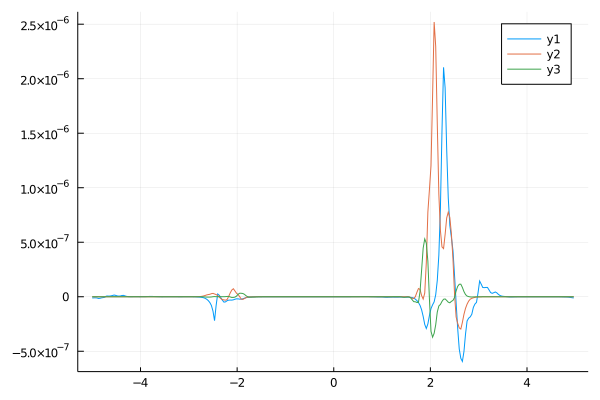

In [1105]:
plot(FreqsTest,-imag(Product6))
plot!(FreqsTest,-2*imag(Product10))
plot!(FreqsTest,-2*imag(Product11))

In [1106]:
init=1
#endT=Timepts-3000
endT=Timepts

Filtered1=conj(E1V00P1Cross_Phot[init:endT,2]+im*E1V00P1Cross_Phot[init:end,3])
Filtered2=E1V00P1Cross_Exc[init:end,2]+im*E1V00P1Cross_Exc[init:end,3]

Filtered3=conj(E1V01P1Cross_Phot[init:end,2]+im*E1V01P1Cross_Phot[init:end,3])
Filtered4=E1V01P1Cross_Exc[init:end,2]+im*E1V01P1Cross_Exc[init:end,3]

Filtered5=conj(E1V10P1Cross_Phot[init:end,2]+im*E1V10P1Cross_Phot[init:end,3])
Filtered6=E1V10P1Cross_Exc[init:end,2]+im*E1V10P1Cross_Exc[init:end,3]

Filtered7=conj(E2V00P0Cross_Phot[init:end,2]+im*E2V00P0Cross_Phot[init:end,3])
Filtered8=E2V00P0Cross_Exc[init:end,2]+im*E2V00P0Cross_Exc[init:end,3]

Filtered9=conj(E3V00P0Cross_Phot[init:end,2]+im*E3V00P0Cross_Phot[init:end,3])
Filtered10=E3V00P0Cross_Exc[init:end,2]+im*E3V00P0Cross_Exc[init:end,3]

Filtered11=conj(E1V00P0Cross_Phot[init:end,2]+im*E1V00P0Cross_Phot[init:end,3])
#Filtered11=conj(MicAmpMol[init:endT,2])
Filtered12=E1V00P0Cross_Exc[init:end,2]+im*E1V00P0Cross_Exc[init:end,3]

Filtered13=conj(E2V10P0Cross_Phot[init:end,2]+im*E2V10P0Cross_Phot[init:end,3])
Filtered14=E2V10P0Cross_Exc[init:end,2]+im*E2V10P0Cross_Exc[init:end,3]

Filtered15=conj(E2V20P0Cross_Phot[init:end,2]+im*E2V20P0Cross_Phot[init:end,3])
Filtered16=E2V20P0Cross_Exc[init:end,2]+im*E2V20P0Cross_Exc[init:end,3];

Filtered17=conj(E2V30P0Cross_Phot[init:end,2]+im*E2V30P0Cross_Phot[init:end,3])
Filtered18=E2V30P0Cross_Exc[init:end,2]+im*E2V30P0Cross_Exc[init:end,3];

Filtered19=conj(E1V10P0Cross_Phot[init:end,2]+im*E1V10P0Cross_Phot[init:end,3])
Filtered20=E1V10P0Cross_Exc[init:end,2]+im*E1V10P0Cross_Exc[init:end,3];

Filtered21=conj(E1V20P0Cross_Phot[init:end,2]+im*E1V20P0Cross_Phot[init:end,3])
Filtered22=E1V20P0Cross_Exc[init:end,2]+im*E1V20P0Cross_Exc[init:end,3];


#Application of filter




FreqsTest=0.658*fftfreq(length(Filtered1[:,1]))*2*pi/deltaT

#FouTest=ifft(Exc0Vib0PhotCross_Exc[:,2]+im*Exc0Vib0PhotCross_Exc[:,3])
FouTest1=ifft(Filtered1)*TotPts*deltaT/0.658
FouTest2=ifft(Filtered2)*TotPts*deltaT/0.658

FouTest3=ifft(Filtered3)*TotPts*deltaT/0.658
FouTest4=ifft(Filtered4)*TotPts*deltaT/0.658

FouTest5=ifft(Filtered5)*TotPts*deltaT/0.658
FouTest6=ifft(Filtered6)*TotPts*deltaT/0.658

FouTest7=ifft(Filtered7)*TotPts*deltaT/0.658
FouTest8=ifft(Filtered8)*TotPts*deltaT/0.658

FouTest9=ifft(Filtered9)*TotPts*deltaT/0.658
FouTest10=ifft(Filtered10)*TotPts*deltaT/0.658

FouTest11=ifft(Filtered11)*TotPts*deltaT/0.658
FouTest12=ifft(Filtered12)*TotPts*deltaT/0.658

FouTest13=ifft(Filtered13)*TotPts*deltaT/0.658
FouTest14=ifft(Filtered14)*TotPts*deltaT/0.658

FouTest15=ifft(Filtered15)*TotPts*deltaT/0.658
FouTest16=ifft(Filtered16)*TotPts*deltaT/0.658

FouTest17=ifft(Filtered17)*TotPts*deltaT/0.658
FouTest18=ifft(Filtered18)*TotPts*deltaT/0.658

FouTest19=ifft(Filtered19)*TotPts*deltaT/0.658
FouTest20=ifft(Filtered20)*TotPts*deltaT/0.658

FouTest21=ifft(Filtered21)*TotPts*deltaT/0.658
FouTest22=ifft(Filtered22)*TotPts*deltaT/0.658


for i in 1:length(Filtered1)
    Filtered1[i]=Filtered1[i]*cos(pi*i/(2*length(Filtered1[:,1])))
    Filtered2[i]=Filtered2[i]*cos(pi*i/(2*length(Filtered2[:,1])))
    
    Filtered3[i]=Filtered3[i]*cos(pi*i/(2*length(Filtered3[:,1])))
    Filtered4[i]=Filtered4[i]*cos(pi*i/(2*length(Filtered4[:,1])))
    
    Filtered5[i]=Filtered5[i]*cos(pi*i/(2*length(Filtered5[:,1])))
    Filtered6[i]=Filtered6[i]*cos(pi*i/(2*length(Filtered6[:,1])))
    
    Filtered7[i]=Filtered7[i]*cos(pi*i/(2*length(Filtered7[:,1])))
    Filtered8[i]=Filtered8[i]*cos(pi*i/(2*length(Filtered8[:,1])))
    
    Filtered9[i]=Filtered9[i]*cos(pi*i/(2*length(Filtered9[:,1])))
    Filtered10[i]=Filtered10[i]*cos(pi*i/(2*length(Filtered10[:,1])))
    
    Filtered11[i]=Filtered11[i]*cos(pi*i/(2*length(Filtered11[:,1])))
    Filtered12[i]=Filtered12[i]*cos(pi*i/(2*length(Filtered12[:,1])))
    
    Filtered13[i]=Filtered13[i]*cos(pi*i/(2*length(Filtered13[:,1])))
    Filtered14[i]=Filtered14[i]*cos(pi*i/(2*length(Filtered14[:,1])))
    
    Filtered15[i]=Filtered15[i]*cos(pi*i/(2*length(Filtered15[:,1])))
    Filtered16[i]=Filtered16[i]*cos(pi*i/(2*length(Filtered16[:,1])))
    
    Filtered17[i]=Filtered17[i]*cos(pi*i/(2*length(Filtered17[:,1])))
    Filtered18[i]=Filtered18[i]*cos(pi*i/(2*length(Filtered18[:,1])))
    
    Filtered19[i]=Filtered19[i]*cos(pi*i/(2*length(Filtered19[:,1])))
    Filtered20[i]=Filtered20[i]*cos(pi*i/(2*length(Filtered20[:,1])))
    
    Filtered21[i]=Filtered19[i]*cos(pi*i/(2*length(Filtered21[:,1])))
    Filtered22[i]=Filtered20[i]*cos(pi*i/(2*length(Filtered22[:,1])))
    
    
    
end


#****
#l=3855
#for i in 1:length(FouTest)
#    FouTest[i]=exp(im*l*FreqsTest[i])*FouTest[i]
#end

#****


FreqsTest=fftshift(FreqsTest)
FouTest1=fftshift(FouTest1);
FouTest2=fftshift(FouTest2);

FouTest3=fftshift(FouTest3);
FouTest4=fftshift(FouTest4);

FouTest5=fftshift(FouTest5);
FouTest6=fftshift(FouTest6);

FouTest7=fftshift(FouTest7)
FouTest8=fftshift(FouTest8);

FouTest9=fftshift(FouTest9)
FouTest10=fftshift(FouTest10);

FouTest11=fftshift(FouTest11)
FouTest12=fftshift(FouTest12);

FouTest13=fftshift(FouTest13)
FouTest14=fftshift(FouTest14);

FouTest15=fftshift(FouTest15)
FouTest16=fftshift(FouTest16);

FouTest17=fftshift(FouTest17)
FouTest18=fftshift(FouTest18);

FouTest19=fftshift(FouTest19)
FouTest20=fftshift(FouTest20);

FouTest21=fftshift(FouTest21)
FouTest22=fftshift(FouTest22);



Product1=conj(FouTest1).*FouTest2

Product2=conj(FouTest3).*FouTest4

Product3=conj(FouTest5).*FouTest6

Product4=conj(FouTest7).*FouTest8

Product5=conj(FouTest9).*FouTest10

Product6=conj(FouTest11).*FouTest12;

Product7=conj(FouTest13).*FouTest14;

Product8=conj(FouTest15).*FouTest16;

Product9=conj(FouTest17).*FouTest18;

Product10=conj(FouTest19).*FouTest20;

Product11=conj(FouTest21).*FouTest22;





In [1107]:
length(Product1)/2

3856.5

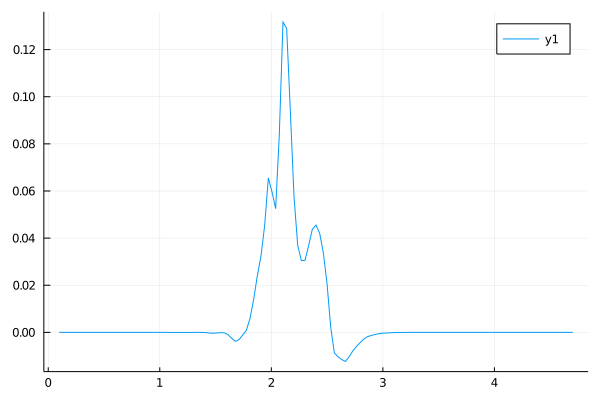

In [1108]:
#plot(FreqsTest[3850:4000],abs.(imag(Product5[3850:4000])+imag(Product4[3850:4000])+imag(Product3[3850:4000])+imag(Product2[3850:4000]+imag(Product1[3850:4000]))))
#TotalAbs=-(imag(Product4)+imag(Product5)+imag(Product6))
TotalAbs=-(imag(Product6)+2*imag(Product10)+2*imag(Product11))*2*sqrt(2)*0.2828*(2.314-0.2)

#TotalAbs=-(imag(Product6))
#plot(FreqsTest[3800:4000],-imag(Product6[3800:4000]))
#plot!(FreqsTest[3800:4000],-2*imag(Product10[3800:4000]))
#plot!(FreqsTest[3800:4000],-2*imag(Product11[3800:4000]))

plot(FreqsTest[3860:4000],(TotalAbs[3860:4000]))





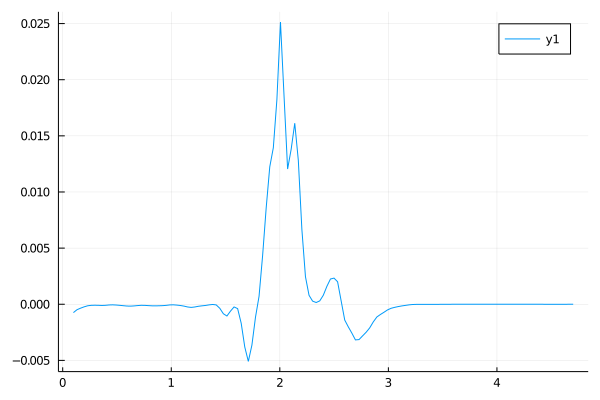

In [1109]:
spInput=Spline1D(FreqsFFTMol[3850:4000], abs.(FouBathMol[3850:4000]).^2; w=ones(length(FreqsFFTMol[3850:4000])),
    k=3, bc="nearest", s=0.0);

NormAbs=zeros(Float64,length(FreqsTest[150:300]))


for i in 1:length(FreqsTest[3850:4000])
    
    NormAbs[i]=TotalAbs[3850+i-1]/(FreqsTest[3850+i-1]*evaluate(spInput,FreqsTest[3850+i-1])/0.658)
    #NormAbs[i]=TotalAbs[3920+i-1]/abs(evaluate(spInput,FreqsTest[3920+i-1]))
    
end


plot(FreqsTest[3860:4000],(NormAbs[10:length(NormAbs)-1]))

In [1110]:
spAbs=Spline1D(FreqsTest[3860:4000], NormAbs[10:length(NormAbs)-1]; w=ones(length(FreqsTest[3860:4000])), k=3, bc="nearest", s=0.0)

AdjustedAbsStrong2Mol=zeros(Float64,length(FRangeIO))

for i in 1:length(FRangeIO)
    
    AdjustedAbsStrong2Mol[i]= evaluate(spAbs,FRangeIO[i])
    
end

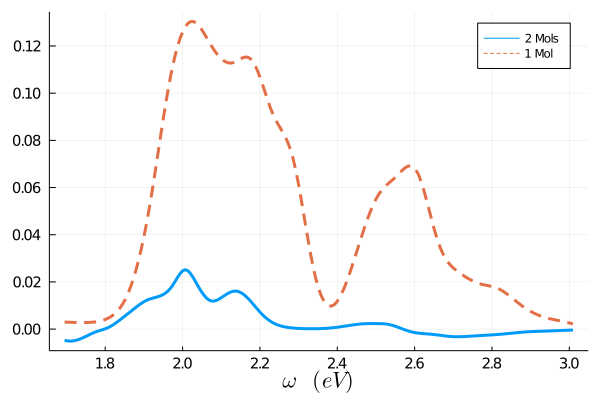

In [1588]:
plot(FRangeIO,AdjustedAbsStrong2Mol,linewidth=3,xlabel=L"\omega\quad (eV)",
   xtickfont=10, ytickfont=10,guidefontsize=15,label="2 Mols")
plot!(FRangeIO,AdjustedAbsStrong1Mol,linestyle=:dash,linewidth=3,label="1 Mol")

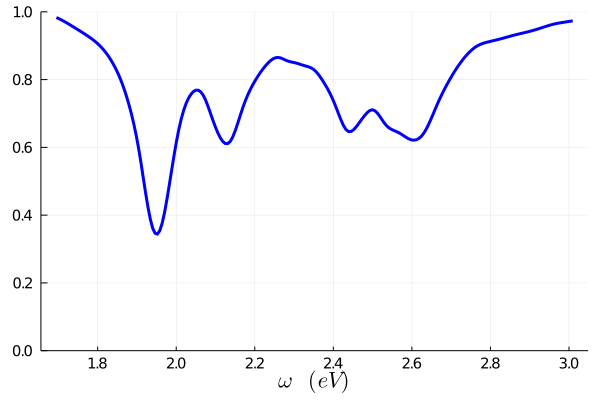

In [1113]:
RefStrong2Mol=zeros(Float64,length(FRangeIO))
for i in 1:length(FRangeIO)
   RefStrong2Mol[i]= abs(STot_NumMol[1,2,i])^2
end



#plot(FRangeIO,RefStrong2Mol,linewidth=3,xlabel=L"\omega\quad (eV)",color=:blue,
#    xtickfont=10, ytickfont=10,guidefontsize=15,label="R. Coeff.",legend=false,ylims=(0,1))


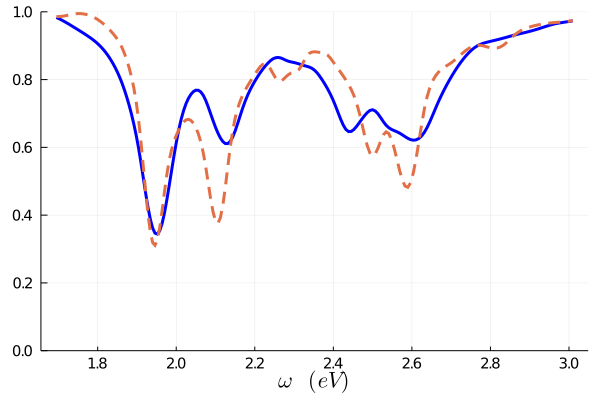

In [1119]:
plot(FRangeIO,RefStrong2Mol,linewidth=3,xlabel=L"\omega\quad (eV)",color=:blue,
    xtickfont=10, ytickfont=10,guidefontsize=15,label="R. Coeff.",legend=false,ylims=(0,1))
plot!(FRangeIO,RefStrong1Mol,linestyle=:dash,linewidth=3)

In [1120]:
TransStrong2Mol=zeros(Float64,length(FRangeIO))
for i in 1:length(FRangeIO)
   TransStrong2Mol[i]= 1-RefStrong2Mol[i]-AdjustedAbsStrong2Mol[i]
end



#plot(FRangeIO,TransStrong2Mol,linewidth=3,xlabel=L"\omega\quad (eV)",color=:red,
#    xtickfont=10, ytickfont=10,guidefontsize=15,label="T. Coeff.",legend=false,ylims=(0,1))

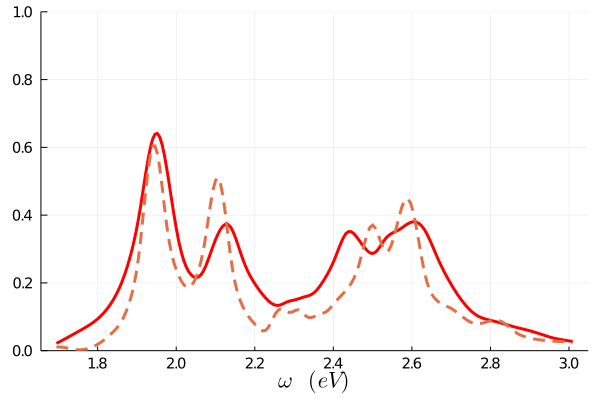

In [1123]:
plot(FRangeIO,TransStrong2Mol,linewidth=3,xlabel=L"\omega\quad (eV)",color=:red,
    xtickfont=10, ytickfont=10,guidefontsize=15,label="T. Coeff.",legend=false,ylims=(0,1))
plot!(FRangeIO,TransStrong1Mol,linewidth=3,linestyle=:dash)

# 2 Molecules. Strong coupling: Transient absorption

In [94]:
#loading data...
Cross_Phot20G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/20Cross_Phot_E1V00P1")
Cross_Exc20G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/20Cross_Exc_E1V00P1")

Cross_Phot40G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/40Cross_Phot_E1V00P1")
Cross_Exc40G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/40Cross_Exc_E1V00P1")

Cross_Phot60G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/60Cross_Phot_E1V00P1")
Cross_Exc60G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/60Cross_Exc_E1V00P1")

Cross_Phot80G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/80Cross_Phot_E1V00P1")
Cross_Exc80G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/80Cross_Exc_E1V00P1")

Cross_Phot100G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/100Cross_Phot_E1V00P1")
Cross_Exc100G=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/100Cross_Phot_E1V00P1");

In [95]:
Cross_Phot20E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/20Cross_Phot_E2V00P0")
Cross_Exc20E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/20Cross_Exc_E2V00P0")

Cross_Phot40E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/40Cross_Phot_E2V00P0")
Cross_Exc40E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/40Cross_Exc_E2V00P0")

Cross_Phot60E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/60Cross_Phot_E2V00P0")
Cross_Exc60E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/60Cross_Exc_E2V00P0")

Cross_Phot80E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/80Cross_Phot_E2V00P0")
Cross_Exc80E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/80Cross_Exc_E2V00P0")

Cross_Phot100E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/100Cross_Phot_E2V00P0")
Cross_Exc100E=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/Strong/CrossMasterNonLin/100Cross_Phot_E2V00P0");
deltaT=abs(Cross_Phot20E[1,1]-Cross_Phot20E[2,1])

0.01625

In [96]:
#For ease of data management, we store the all the relevant correlation functions in 2 arrays of length 
#Timepts x number of delay times x number of auxiliary states

init=1
#endT=Timepts-3000
endT=Timepts
TotTSim=deltaT*abs(endT-init+1)

delayN=5
AuxStates=2


PhotContrib=zeros(ComplexF64,(abs(Timepts-init+1),delayN,AuxStates));
ExcContrib=zeros(ComplexF64,(abs(Timepts-init+1),delayN,AuxStates));

FFTPhot=zeros(ComplexF64,(abs(Timepts-init+1),delayN,AuxStates));
FFTExc=zeros(ComplexF64,(abs(Timepts-init+1),delayN,AuxStates));

#We store the transient absoprtion spectrum for each of the delay times, and spllit it in the different 
#contributions...
TAbs=zeros(ComplexF64,(abs(Timepts-init+1),5,3));

In [97]:
PhotContrib[:,1,1]=conj(Cross_Phot20G[init:endT,2]+im*Cross_Phot20G[init:endT,3])
PhotContrib[:,2,1]=conj(Cross_Phot40G[init:endT,2]+im*Cross_Phot40G[init:endT,3])
PhotContrib[:,3,1]=conj(Cross_Phot60G[init:endT,2]+im*Cross_Phot60G[init:endT,3])
PhotContrib[:,4,1]=conj(Cross_Phot80G[init:endT,2]+im*Cross_Phot80G[init:endT,3])
PhotContrib[:,5,1]=conj(Cross_Phot100G[init:endT,2]+im*Cross_Phot100G[init:endT,3])

PhotContrib[:,1,2]=conj(Cross_Phot20E[init:endT,2]+im*Cross_Phot20E[init:endT,3])
PhotContrib[:,2,2]=conj(Cross_Phot40E[init:endT,2]+im*Cross_Phot40E[init:endT,3])
PhotContrib[:,3,2]=conj(Cross_Phot60E[init:endT,2]+im*Cross_Phot60E[init:endT,3])
PhotContrib[:,4,2]=conj(Cross_Phot80E[init:endT,2]+im*Cross_Phot80E[init:endT,3])
PhotContrib[:,5,2]=conj(Cross_Phot100E[init:endT,2]+im*Cross_Phot100E[init:endT,3])


ExcContrib[:,1,1]=Cross_Exc20G[init:endT,2]+im*Cross_Exc20G[init:endT,3]
ExcContrib[:,2,1]=Cross_Exc40G[init:endT,2]+im*Cross_Exc40G[init:endT,3]
ExcContrib[:,3,1]=Cross_Exc60G[init:endT,2]+im*Cross_Exc60G[init:endT,3]
ExcContrib[:,4,1]=Cross_Exc80G[init:endT,2]+im*Cross_Exc80G[init:endT,3]
ExcContrib[:,5,1]=Cross_Exc100G[init:endT,2]+im*Cross_Exc100G[init:endT,3]

ExcContrib[:,1,2]=Cross_Exc20E[init:endT,2]+im*Cross_Exc20E[init:endT,3]
ExcContrib[:,2,2]=Cross_Exc40E[init:endT,2]+im*Cross_Exc40E[init:endT,3]
ExcContrib[:,3,2]=Cross_Exc60E[init:endT,2]+im*Cross_Exc60E[init:endT,3]
ExcContrib[:,4,2]=Cross_Exc80E[init:endT,2]+im*Cross_Exc80E[init:endT,3]
ExcContrib[:,5,2]=Cross_Exc100E[init:endT,2]+im*Cross_Exc100E[init:endT,3]




#Application of filter
#for i in 1:length(PhotContrib[:,1,1])
    
#    PhotContrib[i,:,:]=PhotContrib[i,:,:]*cos(pi*i/(2*length(PhotContrib[:,1,1])))
#    ExcContrib[i,:,:]=ExcContrib[i,:,:]*cos(pi*i/(2*length(ExcContrib[:,1,1])))
    
     
    
#end



FreqsTest=0.658*fftfreq(length(PhotContrib[:,1,1]))*2*pi/deltaT

for i in 1:length(PhotContrib[1,:,1]) #loop over the delay times
    
    for j in 1:length(PhotContrib[1,1,:]) #loop pver the contributions...
        FFTPhot[:,i,j]=ifft(PhotContrib[:,i,j])*TotTSim/0.658
        FFTExc[:,i,j]=ifft(ExcContrib[:,i,j])*TotTSim/0.658
        
        FFTPhot[:,i,j]=fftshift(FFTPhot[:,i,j])
        FFTExc[:,i,j]=fftshift(FFTExc[:,i,j])
        
    end
    
end

FreqsTest=fftshift(FreqsTest)



#We wrap up the result...

for i in 1:length(PhotContrib[1,:,1]) #loop over the delay times
    
    for j in 1:length(PhotContrib[1,1,:]) #loop pver the contributions...
        TAbs[:,i,j]=conj(FFTPhot[:,i,j]).*FFTExc[:,i,j]
    end
end

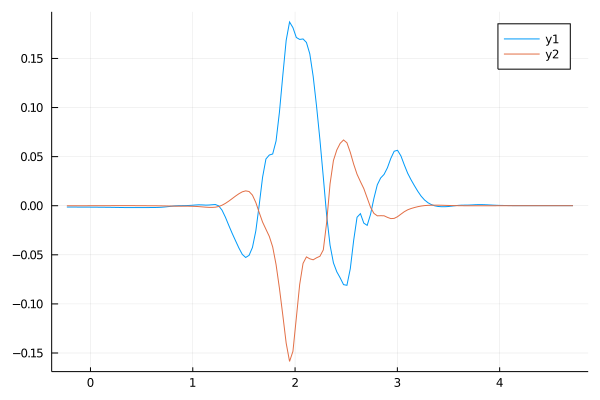

In [98]:
plot(FreqsTest[3850:4000],-imag(TAbs[3850:4000,1,1]))
plot!(FreqsTest[3850:4000],-imag(TAbs[3850:4000,1,2]))

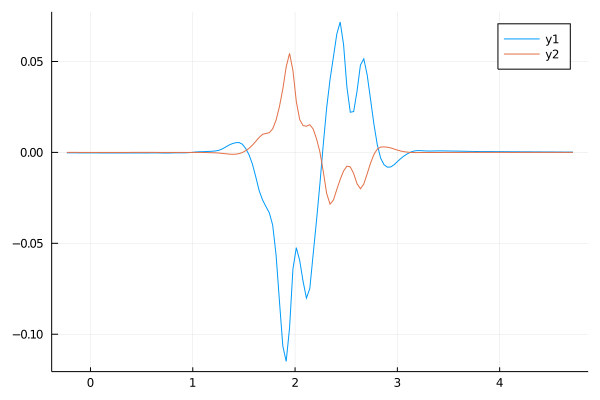

In [99]:
plot(FreqsTest[3850:4000],-imag(TAbs[3850:4000,4,1]))
plot!(FreqsTest[3850:4000],-imag(TAbs[3850:4000,4,2]))

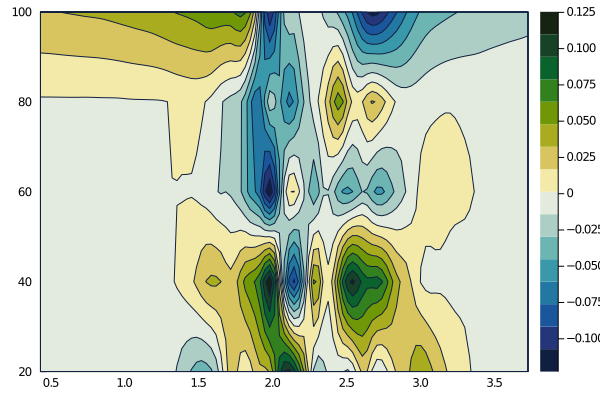

In [102]:
#rearranging data for plotting...
z=zeros(ComplexF64,(abs(endT-init+1),DelayN));

for i in 1:(DelayN)
    for j in 1:AuxStates
        z[:,i]+=TAbs[:,i,j]
        
    end
    
    
end

#x is the frequencies, y is the delay time...
y=[20.0,40.0, 60.0, 80.0,100.0]  

#seriescolor=cgrad(ColorSchemes.leonardo.colors)
#contourf(FreqsTest[3900:3950], y, -imag(transpose(z[3900:3950,:])))


#contourf(FreqsTest[3900:3950], y, -imag(transpose(z[3900:3950,:])),seriescolor=cgrad(ColorSchemes.leonardo.colors))
#contourf(FreqsTest[3910:3940], y, -imag(transpose(z[3910:3940,:])),c=:cork)
contourf(FreqsTest[3870:3970], y, -imag(transpose(z[3870:3970,:])),c=:delta)


# 2 Molecules No Vibs

In [525]:
AmpDum=readdlm("./MCTDH_Molecular/SmallDiss/2Mols/NoVib/Cavity_Resonant/expectationJul"); 

Timepts,columns=size(AmpDum)

#Due to limitations in the MCTDH code, I need to formulate the problem in atomic units. To 
#define the dimensionless annhilitation operator a, we scale the time-dependent coordinate and 
#position derivatives and sum them appropietly:

#conversion of eV to atomic units...
#wcAt=wc*ConvEvToFreq
#dampAt=0.00736/2
#dampAt=0.0


#For purposes of simplicity in data handling, we define the next array:
MicAmpMol=zeros(ComplexF64,(Timepts,2))
#MicAmpC=zeros(ComplexF64,(Timepts,3))
BathAmpMol=zeros(ComplexF64,(Timepts,2))

ExcExp=zeros(ComplexF64,(Timepts,2))



for i in 1:Timepts
    scale=AmpDum[i,2] #norm of the wavefunction. We need to scale each of expectation values computed by MCTDH
    #scale=1.0 #For the simulation of this driven oscillator, we need this scaling factor equal 
    #because the program computes the expectation value over the norm of the wavefunction
    
    MicAmpMol[i,1]=AmpDum[i,1] #Time coordinate
    MicAmpMol[i,2]=AmpDum[i,3]*scale #real part of coordinate
    MicAmpMol[i,2]+=im*AmpDum[i,4]*scale
    
       
    BathAmpMol[i,1]=AmpDum[i,1] #Time coordinate
    BathAmpMol[i,2]=AmpDum[i,5]*scale #real part of coordinate
    BathAmpMol[i,2]+=im*AmpDum[i,6]*scale
    
    ExcExp[i,1]=AmpDum[i,1]
    ExcExp[i,2]=AmpDum[i,7]*scale
    ExcExp[i,2]+=im*AmpDum[i,8]*scale
   
    #MicAmpC[i,1]=AmpDum[i,1]
    #MicAmpC[i,2]=AmpDum[i,7]*scale
    #MicAmpC[i,2]+=im*AmpDum[i,8]*scale
    
end




deltaT=abs(MicAmpMol[1,1]-MicAmpMol[2,1]);
Ttime=abs(MicAmpMol[1,1]-MicAmpMol[Timepts,1]) #This is the total time of the simulation, in fs!!



125.32

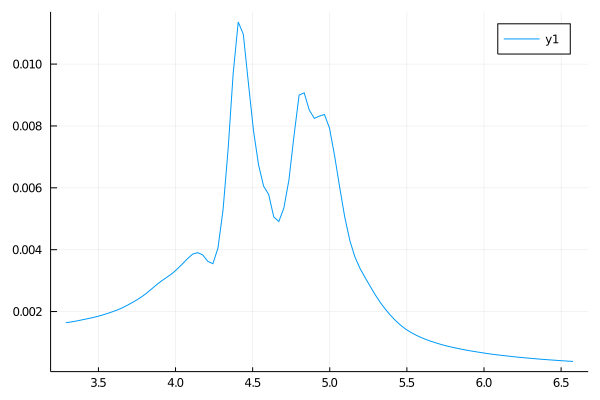

In [526]:
FouExc=ifft(ExcExp[:,2])*length(ExcExp[:,2])*deltaT
FreqsFFTMol=0.658*fftfreq(length(ExcExp[:,2]))*2*pi/deltaT
FreqsFFTMol=fftshift(FreqsFFTMol)
FouExc=fftshift(FouExc);
#plot(FreqsFFTMol[1950:2020],abs.(FouExc[1950:2020]))
plot(FreqsFFTMol[3957:4057],abs.(FouExc[3957:4057]))


# Analysis of the Molecular Fraction

In [387]:
CrossMol=readdlm("./MCTDH_Molecular/SmallDiss/gen_cross/cross_psi_Jul"); 

In [395]:
#extracting the cross-correlation function
TimeptsMol,columns=size(CrossMol);

CrossCorr=zeros(ComplexF64,(TimeptsMol,2))

for i in 1:TimeptsMol
    CrossCorr[i,1]=CrossMol[i,1] #time
    CrossCorr[i,2]=CrossMol[i,2] #real part of cross correlation
    CrossCorr[i,2]+=im*CrossMol[i,3]
    
end

deltaTMol=abs(CrossCorr[1,1]-CrossCorr[2,1]);



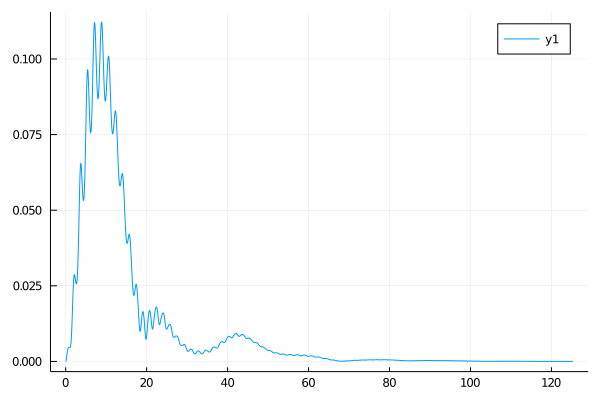

In [393]:
plot(real(CrossCorr[:,1]),abs.(CrossCorr[:,2]))

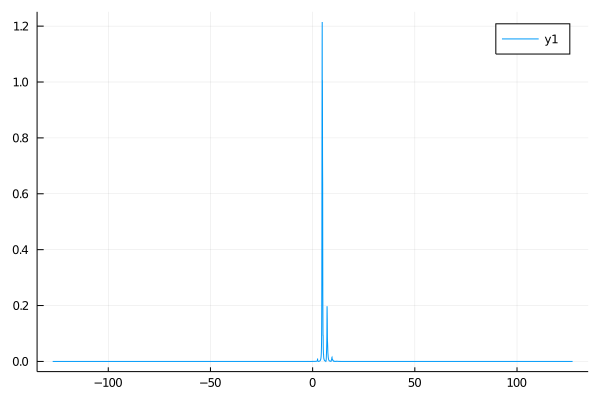

In [396]:
#Fourier analysis
FouMol=ifft(CrossCorr[:,2])*length(CrossCorr[:,2])*deltaTMol

FrFFTMol=0.658*fftfreq(length(CrossCorr[:,2]))*2*pi/deltaTMol ;#Here we take advantage of the equal size along all dimensions
  
FrFFTMol=fftshift(FrFFTMol)
FouMol=fftshift(FouMol);
plot(FrFFTMol,abs.(FouMol))




In [398]:
Timepts/2

3856.5

In [400]:
FrFFTMol[3900]

1.4183960752084028

In [407]:
zeroptEn=0.5*(2.309+2.314+0.2)

2.4115

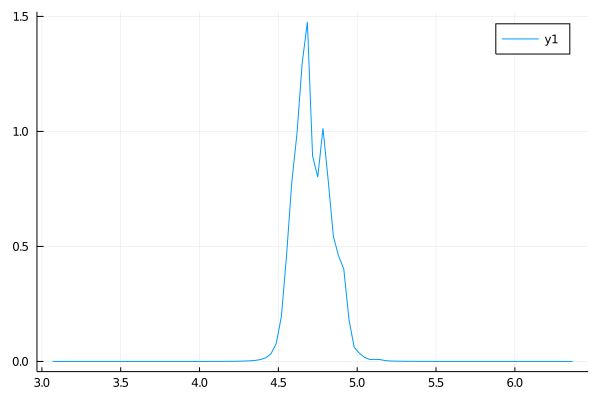

In [412]:
plot(FrFFTMol[3950:4050],abs.(FouMol[3950:4050]).^2)

In [422]:
length(FreqsFFTMol)

7713

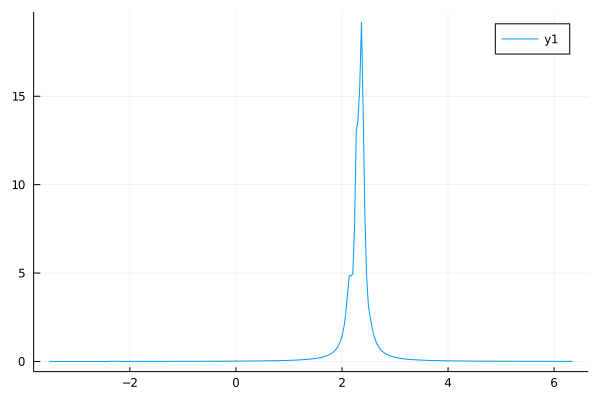

In [426]:
plot(FreqsFFTMol[3750:4050],abs.(FouBathMol[3750:4050]).^2)

In [414]:
5-2.4

2.6

# Clarifications for Fourier transforms

When we use the FFT routines implemented in common numerical packages, we have to take into account that those
consider the first sample point as the 'time zero' of the time series. This is in contrast with the common Fourier 
Tranform definition we find in physics and chemistry literature, where its discrete version consists of a symmetrized
sum (around zero), such that, if we have 2n+1 sampling points, the 'time zero' sampling points is located at
the n+1 position. Here I show how we deal with this issue with an example: the FFT of a gaussian function.

In [1]:
l=40
samplepts=2*l+1 #Total number of sampling points. We use an odd number for convenience
sample=LinRange(-2,2,samplepts)
Gauss=exp.(-sample.^2);

#Straight application of a FFT
FGauss=fft(Gauss);

freqs=2*pi*fftfreq(length(Gauss)); #we scale by 2\pi to obtain the frequencies

#since we want the 'symmetrized' form of the Fourier transform, we need to change the phase of each point of 
#the FFT:
for i in 1:length(FGauss)
    FGauss[i]=exp(im*l*freqs[i])*FGauss[i]
end

#We can reorder the freqs and FGauss arrays such that their zero component is in thee middle rather than at the start

FGauss=fftshift(FGauss)
freqs=fftshift(freqs);

LoadError: [91mUndefVarError: fft not defined[39m

In [2]:
plot(sample,Gauss)

LoadError: [91mUndefVarError: plot not defined[39m

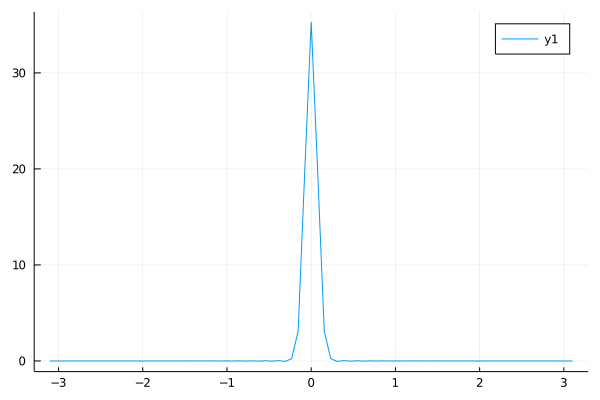

In [187]:
plot(freqs,real(FGauss))